In [54]:
# Importación de todas las librerías necesarias para el desarrollo del proyecto


from google.colab import drive
import os
import pandas as pd
import glob
import plotly.graph_objs as go
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras.layers import Input

# Carga de los datos y preprocesamiento



## Datos de la demanda de energía eléctrica nacional y de comunidades autónomas

In [55]:
!git clone "https://github.com/pauladomski8/TFM_borrador.git"

Cloning into 'TFM_borrador'...
remote: Enumerating objects: 219, done.
remote: Counting objects: 100% (219/219), done.
remote: Compressing objects: 100% (217/217), done.
remote: Total 219 (delta 148), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (219/219), 17.31 MiB | 10.83 MiB/s, done.
Resolving deltas: 100% (148/148), done.


In [56]:
folder_path = '/content/TFM_borrador'
os.chdir(folder_path)

Carga de los datos para la obtención de un Dataframe de la demanda de energía.

In [57]:
# Función para limpiar archivos CSV con formato estándar
def limpiar_csv(folder_path, comunidad):
    energia = pd.read_csv(folder_path, encoding='latin1', skiprows=4)
    energia = energia.rename(columns={energia.columns[0]: 'Descripción'})
    df_demanda = energia[energia['Descripción'] == 'Demanda']
    transpuesta = df_demanda.T.reset_index()
    transpuesta.columns = transpuesta.iloc[0]
    df_limpio_energia = transpuesta.drop(0).rename(columns={transpuesta.columns[0]: 'Fecha', transpuesta.columns[1]: 'Demanda'})
    df_limpio_energia = df_limpio_energia.dropna(subset=['Demanda'])
    df_limpio_energia['Demanda'] = df_limpio_energia['Demanda'].apply(lambda x: x.replace(',', '.') if isinstance(x, str) else x).astype(float)
    df_limpio_energia['Comunidad'] = comunidad
    return df_limpio_energia

# Función para limpiar archivos CSV con formato irregular (Asturias y Aragón)
def limpiar_archivos_irregulares(folder_path, comunidad):
    energia = pd.read_csv(folder_path, encoding='latin1', header=None)
    fechas_row = energia[energia.iloc[:, 0].str.contains("Fecha", na=False)].index[0]
    demandas_row = energia[energia.iloc[:, 0].str.contains("Demanda", na=False)].index[0]
    fechas = energia.iloc[fechas_row, 1:].values
    demandas = energia.iloc[demandas_row, 0].split('"')[1::2]
    df_limpio_energia = pd.DataFrame({'Fecha': fechas, 'Demanda': demandas})
    df_limpio_energia['Demanda'] = df_limpio_energia['Demanda'].str.replace(',', '.').astype(float)
    df_limpio_energia['Comunidad'] = comunidad
    return df_limpio_energia

# Procesamiento de archivos CSV
def procesar_archivos(csv_files, archivos_irregulares):
    dataframes = []
    for file in csv_files:
        comunidad = file.split('Energia')[0]
        if file in archivos_irregulares:
            df_cleaned = limpiar_archivos_irregulares(file, comunidad)
        else:
            df_cleaned = limpiar_csv(file, comunidad)
        if df_cleaned is not None:
            dataframes.append(df_cleaned)
    return pd.concat(dataframes, ignore_index=True) if dataframes else pd.DataFrame()

# Listar y procesar los archivos CSV
csv_files = glob.glob("*Energia*.csv")
archivos_irregulares = ['AsturiasEnergia_01-01-2019_31-12-2020.csv', 'AragonEnergia_01-01-2017_31-12-2018.csv']
df_energia = procesar_archivos(csv_files, archivos_irregulares)

print(df_energia.head(12))


      Fecha     Demanda Comunidad
0   01/2015  155901.049   LaRioja
1   02/2015  146872.170   LaRioja
2   03/2015  149748.231   LaRioja
3   04/2015  130672.637   LaRioja
4   05/2015  134176.512   LaRioja
5   06/2015  136539.991   LaRioja
6   07/2015  159923.630   LaRioja
7   08/2015  133745.782   LaRioja
8   09/2015  136483.334   LaRioja
9   10/2015  143567.720   LaRioja
10  11/2015  144637.781   LaRioja
11  12/2015  148082.746   LaRioja


In [58]:
df_energia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3162 entries, 0 to 3161
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Fecha      3162 non-null   object 
 1   Demanda    3162 non-null   float64
 2   Comunidad  3162 non-null   object 
dtypes: float64(1), object(2)
memory usage: 74.2+ KB


In [59]:
df_energia.sample(50)

Fecha       Demanda           Comunidad
411   03/2022  1.170168e+06       CastillaYLeon
2433  06/2023  1.183836e+05             LaRioja
2883  12/2023  2.537655e+06              Madrid
2046  05/2023  2.871645e+05           Cantabria
2752  01/2015  7.654842e+05              Murcia
1347  07/2018  9.110486e+05              Aragon
895   01/2011  4.342582e+06           Catalunia
0     01/2015  1.559010e+05             LaRioja
855   09/2011  1.668866e+04               Ceuta
121   02/2015  6.591107e+05       IslasCanarias
2132  06/2015  2.158283e+04             Espania
700   12/2019  2.211092e+04             Espania
1834  12/2022  1.573491e+04               Ceuta
2221  11/2018  1.444084e+06           PaisVasco
490   07/2023  1.079471e+06  CastillaDeLaMancha
3112  12/2011  9.072557e+05            Asturias
2222  12/2018  1.313162e+06           PaisVasco
338   02/2012  1.602977e+05             LaRioja
1674  03/2022  1.222745e+06             Galicia
3141  04/2021  8.355049e+05              Aragon
2495  07/2023  2.268427e+04             Espania
2139  01/2016  2.263302e+04             Espania
2024  07/2011  1.592422e+06             Galicia
3025  09/2022  5.947468e+05       IslasBaleares
2559  03/2017  1.724171e+06             Galicia
567   11/2020  1.391042e+05             LaRioja
1397  09/2014  3.836715e+06           Catalunia
2334  03/2011  3.363761e+06           Andalucia
37    02/2022  3.023662e+06           Andalucia
389   05/2014  8.291155e+05              Aragon
446   02/2023  7.194382e+05              Murcia
1573  05/2023  3.908776e+05             Navarra
1352  12/2018  8.707628e+05              Aragon
2661  08/2022  3.033050e+05           Cantabria
2898  02/2018  1.702964e+04             Melilla
1317  01/2022  2.272930e+04             Espania
135   04/2016  6.888099e+05       IslasCanarias
2190  04/2022  6.682153e+05              Murcia
2899  03/2018  1.670199e+04             Melilla
1947  02/2017  2.105145e+04             Espania
944   01/2012  2.950113e+06              Madrid
2062  08/2017  2.367768e+06              Madrid
950   07/2012  2.618446e+06              Madrid
2610  06/2013  2.227971e+06              Madrid
2231  09/2015  8.199757e+05            Asturias
513   05/2012  9.657882e+05  CastillaDeLaMancha
1945  12/2016  1.716895e+04             Melilla
2960  04/2011  1.039440e+06       CastillaYLeon
1143  07/2019  4.446351e+06           Catalunia
24    01/2021  3.806960e+06           Andalucia

In [60]:
# Convertir cada comunidad en columna y agregar el sufijo de Energia a cada una
cambio_columnas = df_energia.pivot(index='Fecha', columns='Comunidad', values='Demanda') \
                            .add_suffix('Energia') \
                            .reset_index()

print(cambio_columnas.head())


Comunidad    Fecha  AndaluciaEnergia  AragonEnergia  AsturiasEnergia  \
0          01/2011       3611370.158     956500.295      1020147.744   
1          01/2012       3603907.344     922987.660       963039.249   
2          01/2013       3427297.594     898060.795       916680.371   
3          01/2014       3406748.087     882108.476       926940.981   
4          01/2015       3485428.721     903645.512       956258.030   

Comunidad  CantabriaEnergia  CastillaDeLaManchaEnergia  CastillaYLeonEnergia  \
0                394458.733                1151079.404           1308023.490   
1                353760.208                1110101.866           1310529.090   
2                381780.480                1064945.693           1261244.110   
3                343029.447                1045902.927           1240207.395   
4                374887.914                1069550.840           1265447.012   

Comunidad  CataluniaEnergia  CeutaEnergia  EspaniaEnergia  ...  \
0               4342

In [61]:
# Renombrar el dataset
df_energia = cambio_columnas

In [62]:
df_energia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Fecha                      164 non-null    object 
 1   AndaluciaEnergia           158 non-null    float64
 2   AragonEnergia              158 non-null    float64
 3   AsturiasEnergia            158 non-null    float64
 4   CantabriaEnergia           157 non-null    float64
 5   CastillaDeLaManchaEnergia  157 non-null    float64
 6   CastillaYLeonEnergia       157 non-null    float64
 7   CataluniaEnergia           158 non-null    float64
 8   CeutaEnergia               162 non-null    float64
 9   EspaniaEnergia             164 non-null    float64
 10  ExtremaduraEnergia         157 non-null    float64
 11  GaliciaEnergia             157 non-null    float64
 12  IslasBalearesEnergia       157 non-null    float64
 13  IslasCanariasEnergia       157 non-null    float64

In [63]:
# Dividir los valores de las columnas de energía de comunidades (excluyendo 'EspaniaEnergia') por 1000
comunidades_columnas = df_energia.filter(regex='Energia').columns.difference(['EspaniaEnergia'])
df_energia[comunidades_columnas] /= 1000

In [64]:
df_energia

Comunidad    Fecha  AndaluciaEnergia  AragonEnergia  AsturiasEnergia  \
0          01/2011       3611.370158     956.500295      1020.147744   
1          01/2012       3603.907344     922.987660       963.039249   
2          01/2013       3427.297594     898.060795       916.680371   
3          01/2014       3406.748087     882.108476       926.940981   
4          01/2015       3485.428721     903.645512       956.258030   
..             ...               ...            ...              ...   
159        12/2019       3383.670228     875.169733       770.472528   
160        12/2020       3482.080542     873.158298       812.041784   
161        12/2021       3441.074577     895.918585       805.235909   
162        12/2022       3127.215411     828.154912       741.601993   
163        12/2023       3421.974695     790.003599       741.593527   

Comunidad  CantabriaEnergia  CastillaDeLaManchaEnergia  CastillaYLeonEnergia  \
0                394.458733                1151.079404           1308.023490   
1                353.760208                1110.101866           1310.529090   
2                381.780480                1064.945693           1261.244110   
3                343.029447                1045.902927           1240.207395   
4                374.887914                1069.550840           1265.447012   
..                      ...                        ...                   ...   
159              324.383453                1010.042555           1205.933214   
160              306.515675                1018.731820           1205.269286   
161              314.925718                1048.655126           1192.721645   
162              276.394369                 956.420809           1103.692928   
163              276.812956                1043.730568           1153.652620   

Comunidad  CataluniaEnergia  CeutaEnergia  EspaniaEnergia  ...  \
0               4342.582019     16.753994    24865.971404  ...   
1               4239.810333     18.519813    24314.612326  ...   
2               4219.945354     17.905936    23733.440188  ...   
3               4100.446945     18.805790    23201.370657  ...   
4               4166.773739     18.698456    23850.778461  ...   
..                      ...           ...             ...  ...   
159             3858.858012     17.711219    22110.920732  ...   
160             3983.099447     17.053994    22438.961596  ...   
161             3796.545717     16.848583    22029.944637  ...   
162             3660.750488     15.734913    20287.656712  ...   
163             3665.698858     15.417852    21141.967169  ...   

Comunidad  GaliciaEnergia  IslasBalearesEnergia  IslasCanariasEnergia  \
0             1856.313192            477.262173            744.518001   
1             1831.312857            459.496438            758.301698   
2             1820.899175            732.193363            445.255331   
3             1822.607310            721.426992            424.810960   
4             1865.880341            450.337744            728.282214   
..                    ...                   ...                   ...   
159           1639.128236            421.812285            747.518318   
160           1600.592994            436.982595            665.587715   
161           1521.980401            435.319025            719.893229   
162           1170.300268            398.799464            718.955051   
163           1219.129185            418.487160            733.350316   

Comunidad  LaRiojaEnergia  MadridEnergia  MelillaEnergia  MurciaEnergia  \
0              163.772454    2989.140888       18.094770     731.156254   
1              158.807984    2950.112966       18.997131     747.687612   
2              158.742347    2891.002527       17.900580     729.942927   
3              153.405823    2752.590443       17.999596     714.366236   
4              155.901049    2785.644732       18.439342     765.484164   
..                    ...            ...             .

In [65]:
df_energia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Fecha                      164 non-null    object 
 1   AndaluciaEnergia           158 non-null    float64
 2   AragonEnergia              158 non-null    float64
 3   AsturiasEnergia            158 non-null    float64
 4   CantabriaEnergia           157 non-null    float64
 5   CastillaDeLaManchaEnergia  157 non-null    float64
 6   CastillaYLeonEnergia       157 non-null    float64
 7   CataluniaEnergia           158 non-null    float64
 8   CeutaEnergia               162 non-null    float64
 9   EspaniaEnergia             164 non-null    float64
 10  ExtremaduraEnergia         157 non-null    float64
 11  GaliciaEnergia             157 non-null    float64
 12  IslasBalearesEnergia       157 non-null    float64
 13  IslasCanariasEnergia       157 non-null    float64

## Datos meteorologicos (temperatura máxima, temperatura mínima y duración del día) de cada comunidad autónoma.

In [66]:
# Función para elegir solo datos de interés en el csv
def limpiar_csv_meteo(folder_path, comunidad):
    columnas_interes = ['time', 'temperature_2m_max (Â°C)', 'temperature_2m_min (Â°C)', 'daylight_duration (s)']
    df_limpio = pd.read_csv(folder_path, encoding='latin1', skiprows=3)[columnas_interes]
    df_limpio['Comunidad'] = comunidad
    return df_limpio

# Funciín para leer los datos por comunidad autónoma y separar los datos en las columnas de interés
def procesar_archivos_meteo():
    csv_files = glob.glob("*DatosMeteo*.csv")
    dataframes = [
        limpiar_csv_meteo(file, file.split('DatosMeteo')[0].split('/')[-1])
        for file in csv_files
    ]
    return pd.concat(dataframes, ignore_index=True) if dataframes else pd.DataFrame()

df_meteo = procesar_archivos_meteo()
print(df_meteo.head(12))


          time  temperature_2m_max (Â°C)  temperature_2m_min (Â°C)  \
0   2011-01-01                      11.7                       4.3   
1   2011-01-02                       9.9                       4.4   
2   2011-01-03                       7.1                       0.8   
3   2011-01-04                      11.2                      -0.9   
4   2011-01-05                      11.2                       5.2   
5   2011-01-06                      13.8                       5.7   
6   2011-01-07                      13.8                       6.4   
7   2011-01-08                      15.7                       4.8   
8   2011-01-09                      11.2                       5.3   
9   2011-01-10                      12.3                       1.2   
10  2011-01-11                      15.0                       6.7   
11  2011-01-12                      15.3                       8.3   

    daylight_duration (s) Comunidad  
0                33200.80    Aragon  
1            

In [67]:
# Convertir la columna 'time' a formato de fecha y crear una columna de año/mes en formato 'MM/YYYY'
df_meteo['time'] = pd.to_datetime(df_meteo['time'], format='%Y-%m-%d')
df_meteo['Mes_Año'] = df_meteo['time'].dt.strftime('%m/%Y')
df_meteo = df_meteo.drop(columns=['time'])

# Agrupar por 'Comunidad' y 'Mes_Año' calculando el promedio de cada mes
df_meteo = df_meteo.groupby(['Comunidad', 'Mes_Año'], as_index=False).mean()

print(df_meteo)


      Comunidad  Mes_Año  temperature_2m_max (Â°C)  temperature_2m_min (Â°C)  \
0     Andalucia  01/2011                 13.258065                  5.003226   
1     Andalucia  01/2012                 13.890323                  2.151613   
2     Andalucia  01/2013                 12.587097                  3.477419   
3     Andalucia  01/2014                 12.983871                  5.177419   
4     Andalucia  01/2015                 13.287097                  2.506452   
...         ...      ...                       ...                       ...   
2985   Valencia  12/2019                 17.477419                  9.854839   
2986   Valencia  12/2020                 16.274194                  7.822581   
2987   Valencia  12/2021                 17.677419                  9.512903   
2988   Valencia  12/2022                 18.274194                 10.396774   
2989   Valencia  12/2023                 18.483871                  7.645161   

      daylight_duration (s)  
0        

In [68]:
# Agregar en el Dataframe los sufijos correspondientes a las comunidades y ponerlos en columnas
df_meteo_columnas = pd.concat([
    df_meteo.pivot(index='Mes_Año', columns='Comunidad', values='temperature_2m_max (Â°C)').add_suffix('TemperaturaMax'),
    df_meteo.pivot(index='Mes_Año', columns='Comunidad', values='temperature_2m_min (Â°C)').add_suffix('TemperaturaMin'),
    df_meteo.pivot(index='Mes_Año', columns='Comunidad', values='daylight_duration (s)').add_suffix('DuracionDia')
], axis=1)

# Restablecer el índice y renombrar la columna de 'Mes_Año' a 'Fecha'
df_meteo_columnas = df_meteo_columnas.reset_index().rename(columns={'Mes_Año': 'Fecha'})

# Mostrar el DataFrame final
print(df_meteo_columnas.head())


Comunidad    Fecha  AndaluciaTemperaturaMax  AragonTemperaturaMax  \
0          01/2011                13.258065             10.174194   
1          01/2012                13.890323             11.658065   
2          01/2013                12.587097             11.822581   
3          01/2014                12.983871             11.900000   
4          01/2015                13.287097             10.790323   

Comunidad  AsturiasTemperaturaMax  CantabriaTemperaturaMax  \
0                       10.616129                 9.041935   
1                       11.151613                 9.409677   
2                       11.432258                10.377419   
3                       11.225806                10.612903   
4                       10.877419                 9.206452   

Comunidad  CastillaDeLaManchaTemperaturaMax  CastillaYLeonTemperaturaMax  \
0                                 21.232258                     6.716129   
1                                 21.733871                 

In [69]:
# Renombrar el Dataframe

df_meteo = df_meteo_columnas

In [70]:
df_meteo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 58 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Fecha                             164 non-null    object 
 1   AndaluciaTemperaturaMax           157 non-null    float64
 2   AragonTemperaturaMax              157 non-null    float64
 3   AsturiasTemperaturaMax            157 non-null    float64
 4   CantabriaTemperaturaMax           157 non-null    float64
 5   CastillaDeLaManchaTemperaturaMax  164 non-null    float64
 6   CastillaYLeonTemperaturaMax       157 non-null    float64
 7   CataluniaTemperaturaMax           157 non-null    float64
 8   CeutaTemperaturaMax               157 non-null    float64
 9   ExtremaduraTemperaturaMax         157 non-null    float64
 10  GaliciaTemperaturaMax             157 non-null    float64
 11  IslasBalearesTemperaturaMax       157 non-null    float64
 12  IslasCan

## Datos de la poblacion nacional de España

Se realiza la carga del csv de población. Dado que se carga con caracteres no deseados, se hace elimina los mismos para su correcta lectura.

In [71]:
file_path = '/content/TFM_borrador/PoblacionTrimestral.csv'

poblacion = pd.read_csv(file_path, sep="\t")

# Eliminar caracteres no deseados en los nombres de las columnas y celdas
poblacion.columns = poblacion.columns.str.replace(r'[;""]', '', regex=True)
poblacion = poblacion.replace({r'[;""]': ''}, regex=True)

In [72]:
poblacion.head(10)

PERIODO       VALOR
0  2024T3  48,797,875
1  2024T2  48,730,508
2  2024T1  48,630,010
3  2023T4  48,522,035
4  2023T3  48,382,506
5  2023T2  48,237,948
6  2023T1  48,085,361
7  2022T4  47,940,295
8  2022T3  47,781,354
9  2022T2  47,609,145

In [73]:
poblacion.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   PERIODO  55 non-null     object
 1   VALOR    55 non-null     object
dtypes: object(2)
memory usage: 1008.0+ bytes


In [74]:
poblacion['VALOR'] = poblacion['VALOR'].str.replace(',', '').astype(int)

trimestre_a_mes = {'T1': '01', 'T2': '04', 'T3': '07', 'T4': '10'}
poblacion['Mes'] = poblacion['PERIODO'].str[-2:].replace(trimestre_a_mes)

# Función para generar los datos mensuales repitiendo el valor trimestral para cada uno de los tres meses
data_mensual = [
    [(pd.to_datetime(f"{row['Mes']}/{row['PERIODO'][:4]}", format='%m/%Y') + pd.DateOffset(months=i)).strftime('%m/%Y'), row['VALOR']]
    for _, row in poblacion.iterrows() for i in range(3)
]

df_poblacion = pd.DataFrame(data_mensual, columns=['Fecha', 'Poblacion'])
print(df_poblacion.head(12))

      Fecha  Poblacion
0   07/2024   48797875
1   08/2024   48797875
2   09/2024   48797875
3   04/2024   48730508
4   05/2024   48730508
5   06/2024   48730508
6   01/2024   48630010
7   02/2024   48630010
8   03/2024   48630010
9   10/2023   48522035
10  11/2023   48522035
11  12/2023   48522035


In [75]:
df_poblacion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha      165 non-null    object
 1   Poblacion  165 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.7+ KB


In [76]:
df_poblacion.head(10)

Fecha  Poblacion
0  07/2024   48797875
1  08/2024   48797875
2  09/2024   48797875
3  04/2024   48730508
4  05/2024   48730508
5  06/2024   48730508
6  01/2024   48630010
7  02/2024   48630010
8  03/2024   48630010
9  10/2023   48522035

## Datos del PIB de España



Se realiza la carga de los datos del PIB de España. Se comienza solo por tomar las columnas de interés del csv.

In [77]:
file_path = '/content/TFM_borrador/PIBTrimestral.csv'
pib = pd.read_csv(file_path, sep=";")

pib_filtrado = pib[['PERIODO', 'VALOR']]
pib_filtrado.head()

PERIODO   VALOR
0  2024T2  0,8024
1  2024T1  0,8330
2  2023T4  0,7148
3  2023T3  0,5067
4  2023T2  0,5020

In [78]:
trimestre_a_mes = {'T1': '01', 'T2': '04', 'T3': '07', 'T4': '10'}
pib_filtrado.loc[:, 'Mes'] = pib_filtrado['PERIODO'].str[-2:].replace(trimestre_a_mes)

# Función para generar los datos mensuales repitiendo el valor trimestral para cada uno de los tres meses
data_mensual = [
    [(pd.to_datetime(f"{row['Mes']}/{row['PERIODO'][:4]}", format='%m/%Y') + pd.DateOffset(months=i)).strftime('%m/%Y'), row['VALOR']]
    for _, row in pib_filtrado.iterrows() for i in range(3)
]

df_PIB = pd.DataFrame(data_mensual, columns=['Fecha', 'PIB'])
df_PIB.head(12)


<ipython-input-78-c7a6d0888aa5>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Fecha     PIB
0   04/2024  0,8024
1   05/2024  0,8024
2   06/2024  0,8024
3   01/2024  0,8330
4   02/2024  0,8330
5   03/2024  0,8330
6   10/2023  0,7148
7   11/2023  0,7148
8   12/2023  0,7148
9   07/2023  0,5067
10  08/2023  0,5067
11  09/2023  0,5067

## Unión de todos los datasets en uno solo

In [79]:
# Unir los DataFrames por la columna 'Fecha'
df_final = df_energia.merge(df_meteo, on='Fecha', how='outer')
df_final = df_final.merge(df_poblacion, on='Fecha', how='outer')
df_final = df_final.merge(df_PIB, on='Fecha', how='outer')

df_final.head()

Fecha  AndaluciaEnergia  AragonEnergia  AsturiasEnergia  \
0  01/2000               NaN            NaN              NaN   
1  01/2001               NaN            NaN              NaN   
2  01/2002               NaN            NaN              NaN   
3  01/2003               NaN            NaN              NaN   
4  01/2004               NaN            NaN              NaN   

   CantabriaEnergia  CastillaDeLaManchaEnergia  CastillaYLeonEnergia  \
0               NaN                        NaN                   NaN   
1               NaN                        NaN                   NaN   
2               NaN                        NaN                   NaN   
3               NaN                        NaN                   NaN   
4               NaN                        NaN                   NaN   

   CataluniaEnergia  CeutaEnergia  EspaniaEnergia  ...  \
0               NaN           NaN             NaN  ...   
1               NaN           NaN             NaN  ...   
2               NaN           NaN             NaN  ...   
3               NaN           NaN             NaN  ...   
4               NaN           NaN             NaN  ...   

   IslasCanariasDuracionDia  LaRiojaDuracionDia  MadridDuracionDia  \
0                       NaN                 NaN                NaN   
1                       NaN                 NaN                NaN   
2                       NaN                 NaN                NaN   
3                       NaN                 NaN                NaN   
4                       NaN                 NaN                NaN   

   MelillaDuracionDia  MurciaDuracionDia  NavarraDuracionDia  \
0                 NaN                NaN                 NaN   
1                 NaN                NaN                 NaN   
2                 NaN                NaN                 NaN   
3                 NaN                NaN                 NaN   
4                 NaN                NaN                 NaN   

   PaisVascoDuracionDia  ValenciaDuracionDia  Poblacion     PIB  
0                   NaN                  NaN        NaN  1,6051  
1                   NaN                  NaN        NaN  1,0669  
2                   NaN                  NaN        NaN  0,4307  
3                   NaN                  NaN        NaN  0,9365  
4                   NaN                  NaN        NaN  0,6086  

[5 rows x 80 columns]

In [80]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 80 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Fecha                             303 non-null    object 
 1   AndaluciaEnergia                  158 non-null    float64
 2   AragonEnergia                     158 non-null    float64
 3   AsturiasEnergia                   158 non-null    float64
 4   CantabriaEnergia                  157 non-null    float64
 5   CastillaDeLaManchaEnergia         157 non-null    float64
 6   CastillaYLeonEnergia              157 non-null    float64
 7   CataluniaEnergia                  158 non-null    float64
 8   CeutaEnergia                      162 non-null    float64
 9   EspaniaEnergia                    164 non-null    float64
 10  ExtremaduraEnergia                157 non-null    float64
 11  GaliciaEnergia                    157 non-null    float64
 12  IslasBal

Dado que algunos Dataframes tienen más datos de los correspondientes se hace un filtrado de las fechas según las columnas que tienen menos datos. En este caso se lo realiza según una de las columnas que tienen menos datos que es CantabriaEnergia

In [81]:
df_filtrado_fechas = df_final.dropna(subset=['CantabriaEnergia'])

df_filtrado_fechas.head()

Fecha  AndaluciaEnergia  AragonEnergia  AsturiasEnergia  \
11  01/2011       3611.370158     956.500295      1020.147744   
12  01/2012       3603.907344     922.987660       963.039249   
13  01/2013       3427.297594     898.060795       916.680371   
14  01/2014       3406.748087     882.108476       926.940981   
15  01/2015       3485.428721     903.645512       956.258030   

    CantabriaEnergia  CastillaDeLaManchaEnergia  CastillaYLeonEnergia  \
11        394.458733                1151.079404           1308.023490   
12        353.760208                1110.101866           1310.529090   
13        381.780480                1064.945693           1261.244110   
14        343.029447                1045.902927           1240.207395   
15        374.887914                1069.550840           1265.447012   

    CataluniaEnergia  CeutaEnergia  EspaniaEnergia  ...  \
11       4342.582019     16.753994    24865.971404  ...   
12       4239.810333     18.519813    24314.612326  ...   
13       4219.945354     17.905936    23733.440188  ...   
14       4100.446945     18.805790    23201.370657  ...   
15       4166.773739     18.698456    23850.778461  ...   

    IslasCanariasDuracionDia  LaRiojaDuracionDia  MadridDuracionDia  \
11              38126.874839        34162.099355       34788.384516   
12              38114.937097        34140.870000       34768.674516   
13              38156.688387        34215.098387       34837.594516   
14              38142.260323        34189.456129       34813.785161   
15              38129.184194        34166.208710       34792.200000   

    MelillaDuracionDia  MurciaDuracionDia  NavarraDuracionDia  \
11        36285.765161       35523.653548        33968.416774   
12        36269.603226       35505.699032        33946.712258   
13        36326.123226       35568.481290        34022.599032   
14        36306.595161       35546.789677        33996.386129   
15        36288.892903       35527.128387        33972.618710   

    PaisVascoDuracionDia  ValenciaDuracionDia   Poblacion      PIB  
11          34017.204194         35076.069032  46667175.0  -0,1500  
12          33995.620968         35057.050000  46818216.0  -0,9313  
13          34071.089677         35123.556129  46712650.0  -0,3076  
14          34045.018710         35100.578387  46495744.0   0,3675  
15          34021.384194         35079.749355  46425722.0   1,1476  

[5 rows x 80 columns]

In [82]:
# Renombrar el dataset final
df_final = df_filtrado_fechas

df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 157 entries, 11 to 302
Data columns (total 80 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Fecha                             157 non-null    object 
 1   AndaluciaEnergia                  157 non-null    float64
 2   AragonEnergia                     157 non-null    float64
 3   AsturiasEnergia                   157 non-null    float64
 4   CantabriaEnergia                  157 non-null    float64
 5   CastillaDeLaManchaEnergia         157 non-null    float64
 6   CastillaYLeonEnergia              157 non-null    float64
 7   CataluniaEnergia                  157 non-null    float64
 8   CeutaEnergia                      157 non-null    float64
 9   EspaniaEnergia                    157 non-null    float64
 10  ExtremaduraEnergia                157 non-null    float64
 11  GaliciaEnergia                    157 non-null    float64
 12  IslasBaleare

Por último, se formatean los datos que no están en el tipo correspondiente, en este caso sería la columna Fecha y PIB. También se reordenan los datos según la fecha correspondiente.

In [83]:
df_final['Fecha'] = pd.to_datetime(df_final['Fecha'], format='%m/%Y')

df_final['PIB'] = df_final['PIB'].str.replace('.', '', regex=False)
df_final['PIB'] = df_final['PIB'].str.replace(',', '.', regex=False)
df_final['PIB'] = pd.to_numeric(df_final['PIB'], errors='coerce')

df_final = df_final.sort_values(by='Fecha')

df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 157 entries, 11 to 24
Data columns (total 80 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Fecha                             157 non-null    datetime64[ns]
 1   AndaluciaEnergia                  157 non-null    float64       
 2   AragonEnergia                     157 non-null    float64       
 3   AsturiasEnergia                   157 non-null    float64       
 4   CantabriaEnergia                  157 non-null    float64       
 5   CastillaDeLaManchaEnergia         157 non-null    float64       
 6   CastillaYLeonEnergia              157 non-null    float64       
 7   CataluniaEnergia                  157 non-null    float64       
 8   CeutaEnergia                      157 non-null    float64       
 9   EspaniaEnergia                    157 non-null    float64       
 10  ExtremaduraEnergia                157 non-null    float

<ipython-input-83-42491c150657>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-83-42491c150657>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-83-42491c150657>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-83-42491c1

# Análisis de las características y de los datos

## Demanda de energía

### Estadísticas generales de la demanda de energía nacional

Se realiza un análisis de la columna objetivo que en este caso es EspaniaEnergia.

In [84]:
# se determinan estadísticas generales
estadisticas_energia = df_final['EspaniaEnergia'].describe()
estadisticas_energia

count      157.000000
mean     21708.926441
std       1365.873680
min      17060.911994
25%      20894.058890
50%      21587.349519
75%      22498.372167
max      24945.739132
Name: EspaniaEnergia, dtype: float64

### Grafico de líneas de la demanda de energía nacional

In [85]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df_final['Fecha'],
    y=df_final['EspaniaEnergia'],
    mode='lines+markers',
    name='Demanda de Energía en España'
))

fig.update_layout(
    title='Evolución de la Demanda de Energía en España',
    xaxis_title='Fecha',
    yaxis_title='Demanda de Energía (GWh)',
    template='plotly_white',
    hovermode='x unified'
)

fig.show()


Dado que la demanda de energía sugiere una serie temporal, se hace la descomposición de la misma.

### Descomposición de la serie de demanda de energía nacional

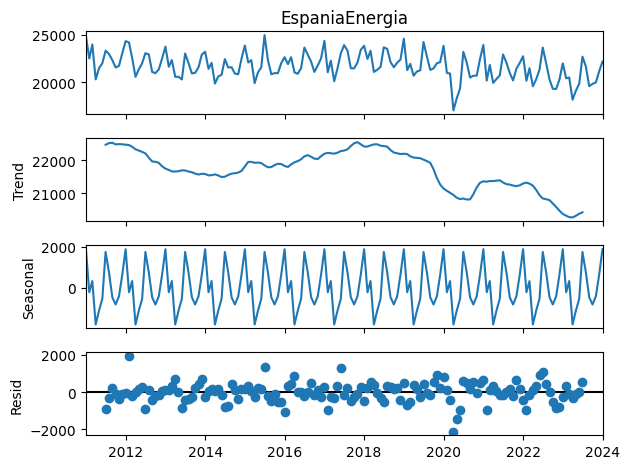

In [86]:
df_final.set_index('Fecha', inplace=True)
descomposicion = seasonal_decompose(df_final['EspaniaEnergia'], model='additive', period=12)
descomposicion.plot()
plt.show()


### Boxplot e histograma de demanda energía nacional

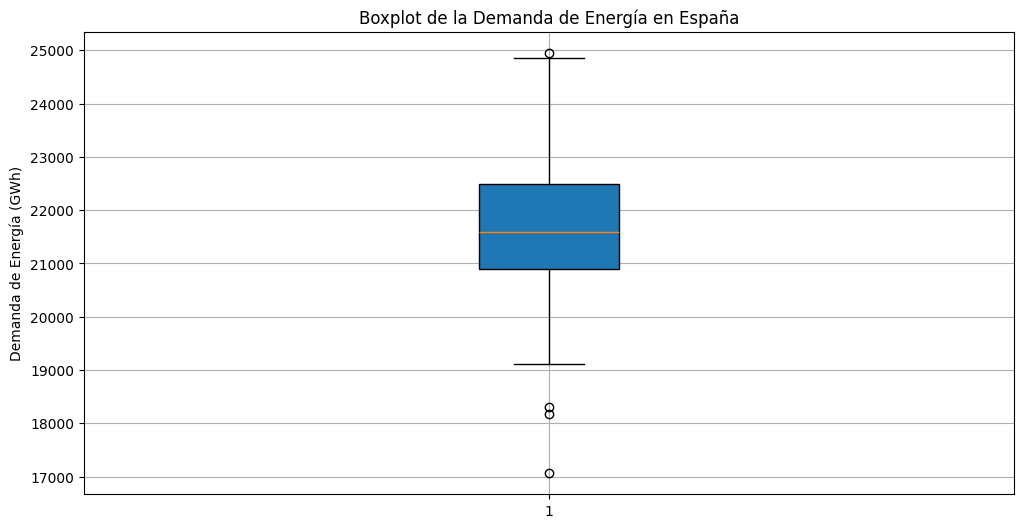

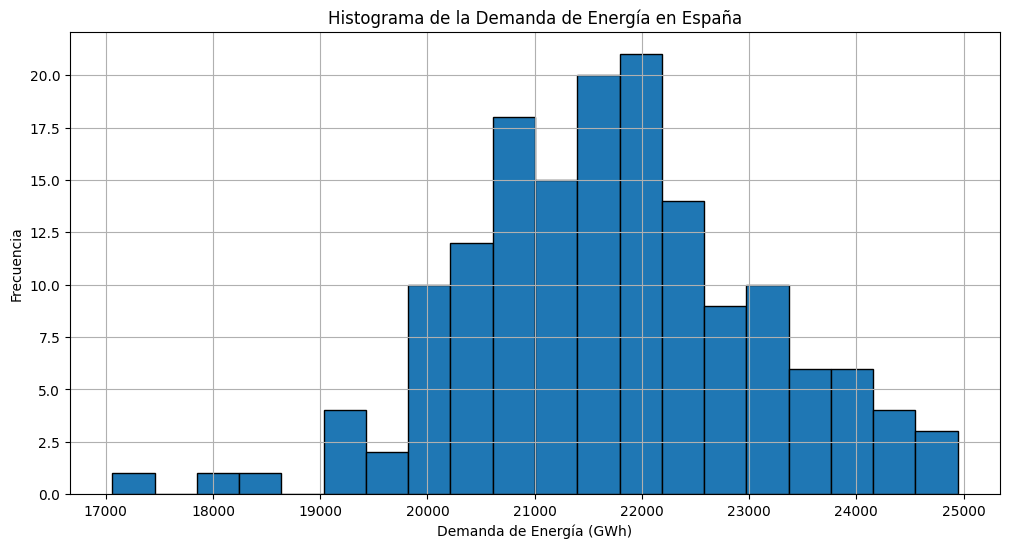

In [87]:
# Boxplot de la columna 'EspaniaEnergia'
plt.figure(figsize=(12, 6))
plt.boxplot(df_final['EspaniaEnergia'].dropna(), vert=True, patch_artist=True)
plt.title('Boxplot de la Demanda de Energía en España')
plt.ylabel('Demanda de Energía (GWh)')
plt.grid(True)
plt.show()

# Histograma de la columna 'EspaniaEnergia'
plt.figure(figsize=(12, 6))
plt.hist(df_final['EspaniaEnergia'].dropna(), bins=20, edgecolor='black')
plt.title('Histograma de la Demanda de Energía en España')
plt.xlabel('Demanda de Energía (GWh)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

### Autocorelación y autocorrelación parcial de la demanda de energía nacional

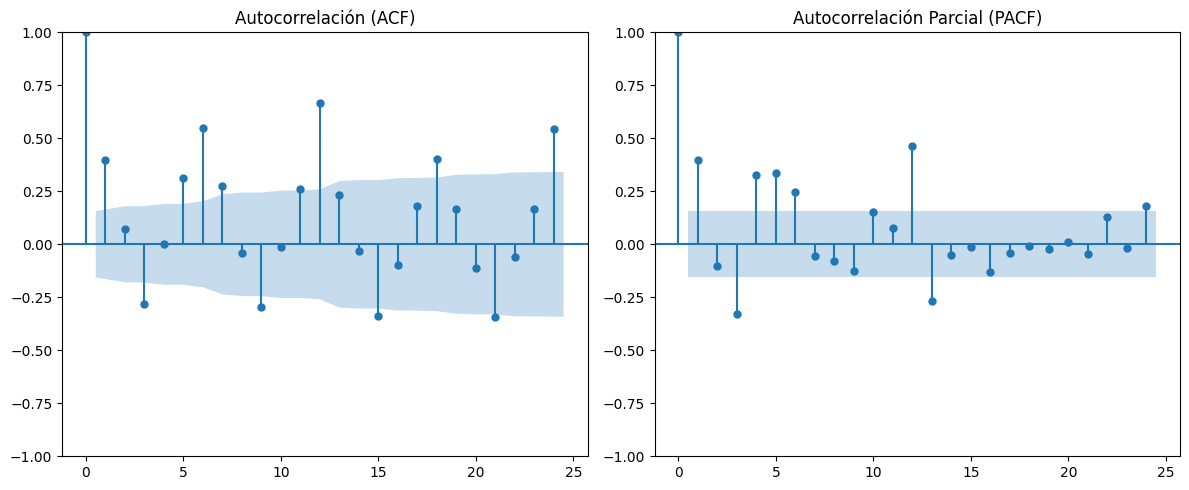

In [88]:
plt.figure(figsize=(12, 5))

# Gráfico de Autocorrelación (ACF)
plt.subplot(1, 2, 1)
plot_acf(df_final['EspaniaEnergia'].dropna(), lags=24, ax=plt.gca())
plt.title('Autocorrelación (ACF)')

# Gráfico de Autocorrelación Parcial (PACF)
plt.subplot(1, 2, 2)
plot_pacf(df_final['EspaniaEnergia'].dropna(), lags=24, ax=plt.gca())
plt.title('Autocorrelación Parcial (PACF)')

plt.tight_layout()
plt.show()

### Estadísticas generales de la demanda de energía de todas las comunidades autónomas

Ahora se realiza un análisis de estadísticas generales de las comunidades autónomas.

In [89]:
comunidades_energia_cols = [col for col in df_final.columns if 'Energia' in col and 'Espania' not in col]
estadisticas_comunidades = df_final[comunidades_energia_cols].describe()
estadisticas_comunidades

AndaluciaEnergia  AragonEnergia  AsturiasEnergia  CantabriaEnergia  \
count        157.000000     157.000000       157.000000        157.000000   
mean        3263.270890     860.723930       824.676126        345.521360   
std          287.106501      41.788548        82.434204         29.476291   
min         2680.249534     715.893499       650.440533        273.224970   
25%         3047.140450     834.865150       754.393956        333.667089   
50%         3188.665788     858.198920       843.168052        352.809120   
75%         3441.074577     887.513783       880.476311        365.297805   
max         3944.796050     957.420099      1020.147744        402.782196   

       CastillaDeLaManchaEnergia  CastillaYLeonEnergia  CataluniaEnergia  \
count                 157.000000            157.000000        157.000000   
mean                  985.475429           1146.612141       3849.633266   
std                    78.786716             72.280314        243.689018   
min                   807.391746            903.667226       2974.661857   
25%                   928.844406           1097.697698       3685.266366   
50%                   973.043007           1139.791713       3839.760626   
75%                  1043.730568           1197.806470       3979.236621   
max                  1194.776552           1310.529090       4505.638561   

       CeutaEnergia  ExtremaduraEnergia  GaliciaEnergia  IslasBalearesEnergia  \
count    157.000000          157.000000      157.000000            157.000000   
mean      16.903829          409.339083     1533.247546            518.904462   
std        1.145698           39.041684      216.169111            123.563620   
min       13.780955          326.020635     1005.822702            321.712013   
25%       15.983727          382.643638     1454.054616            418.652837   
50%       16.981579          403.783910     1590.862407            471.214692   
75%       17.754475          431.889831     1674.271751            639.478985   
max       19.186116          517.022438     1873.335316            767.882086   

       IslasCanariasEnergia  LaRiojaEnergia  MadridEnergia  MelillaEnergia  \
count            157.000000      157.000000     157.000000      157.000000   
mean             681.957889      139.941227    2386.948576       17.425948   
std              105.298744        9.577929     227.112563        1.715261   
min              354.468824      111.843378    1825.502090       14.461344   
25%              668.993423      133.648278    2227.555224       16.310472   
50%              717.470818      140.688459    2357.438710       17.057436   
75%              746.706563      146.311519    2539.186230       18.321295   
max              807.063419      163.772454    2989.140888       22.335731   

       MurciaEnergia  NavarraEnergia  PaisVascoEnergia  ValenciaEnergia  
count     157.000000      157.000000        157.000000       157.000000  
mean      744.713201      410.552909       1354.433009      2218.601555  
std        71.273384       22.113528        131.433557       184.710016  
min       592.383924      329.918004        964.746611      1658.367752  
25%       696.793257      397.391490       1303.370899      2096.139472  
50%       733.326986      410.373790       1356.782634      2192.118486  
75%       777.171494      424.695647       1438.251760      2335.792491  
max       934.973704      463.542521       1742.782999      2740.927677

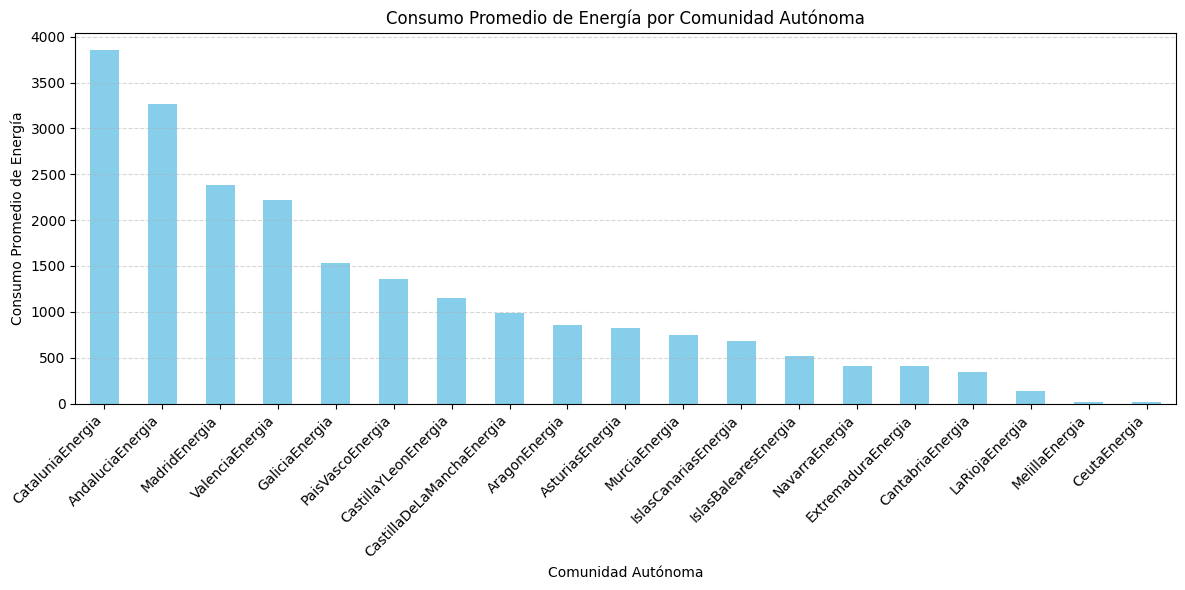

In [90]:
# Gráfico en orden de consumo de energía
consumo_promedio = estadisticas_comunidades.loc['mean']

consumo_promedio_ordenado = consumo_promedio.sort_values(ascending=False)
plt.figure(figsize=(12, 6))
consumo_promedio_ordenado.plot(kind='bar', color='skyblue')

plt.title('Consumo Promedio de Energía por Comunidad Autónoma')
plt.xlabel('Comunidad Autónoma')
plt.ylabel('Consumo Promedio de Energía')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

### Boxplots de la demanda de energía de todas las comunidades autónomas

Se realizan gráficos boxplot de la demanda de energía de todas las comunidades autónomas

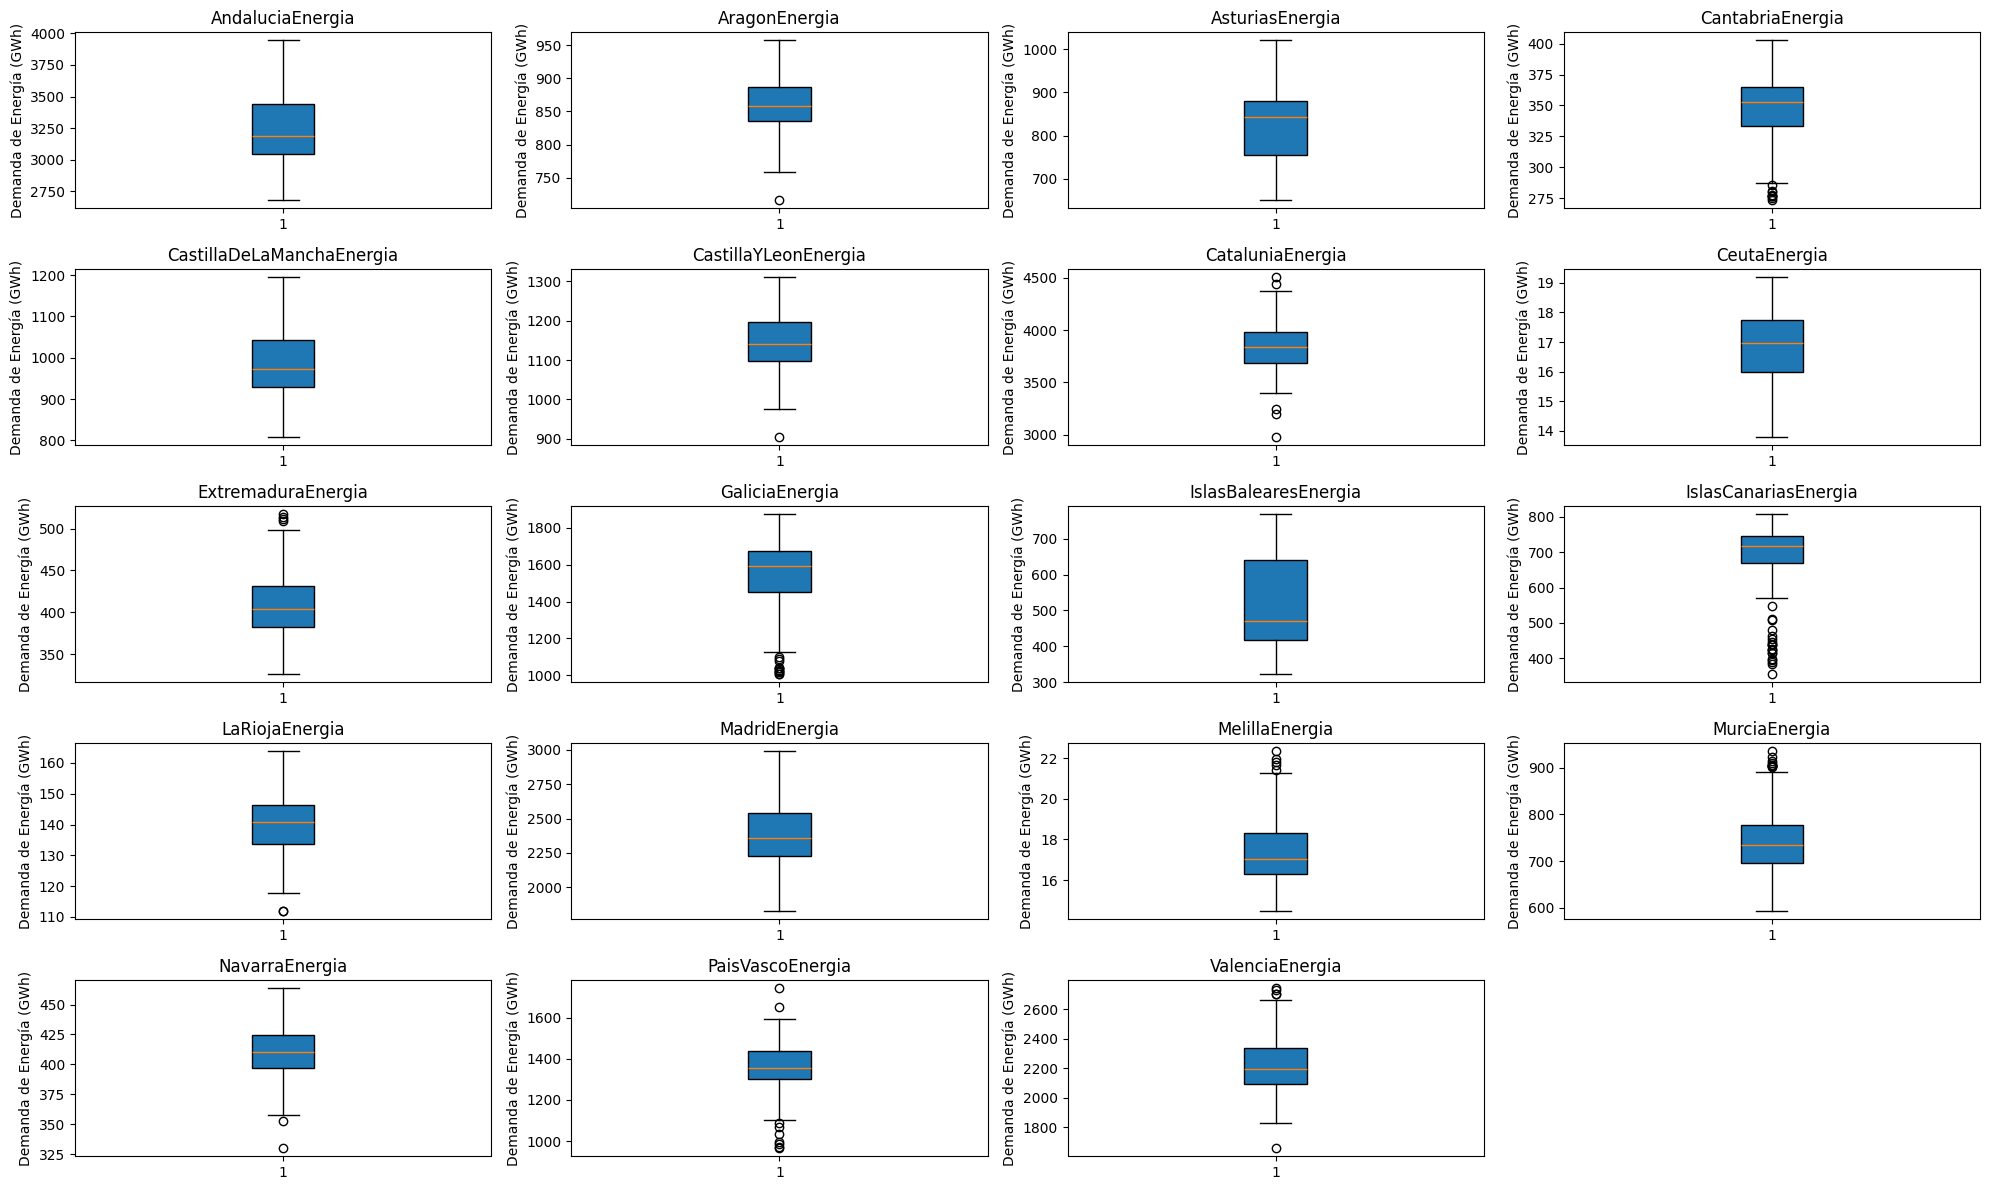

In [91]:
n_cols = 4
n_rows = -(-len(comunidades_energia_cols) // n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 12), squeeze=False)

for ax, col in zip(axs.flatten(), comunidades_energia_cols):
    ax.boxplot(df_final[col].dropna(), vert=True, patch_artist=True)
    ax.set_title(col)
    ax.set_ylabel('Demanda de Energía (GWh)')

for ax in axs.flatten()[len(comunidades_energia_cols):]:
    ax.remove()

plt.tight_layout()
plt.show()


### Graficos de línes de la demanda de energía de todas las comunidades autónomas

In [92]:
df_final_reset = df_final.reset_index()
for col in comunidades_energia_cols:
    fig = px.line(
        df_final_reset,
        x='Fecha',
        y=col,
        title=f'Evolución de la demanda {col} vs Tiempo',
        labels={'Fecha': 'Fecha', col: 'Demanda de Energía (GWh)'}
    )
    fig.show()


### Gráfico de correlaciones de la demanda de energía de todas las comunidades autónomas y nacional



Se reealiza un gráfico de correlación entre la demanda de energía de las diferentes comunidades autónomas y la nacional.

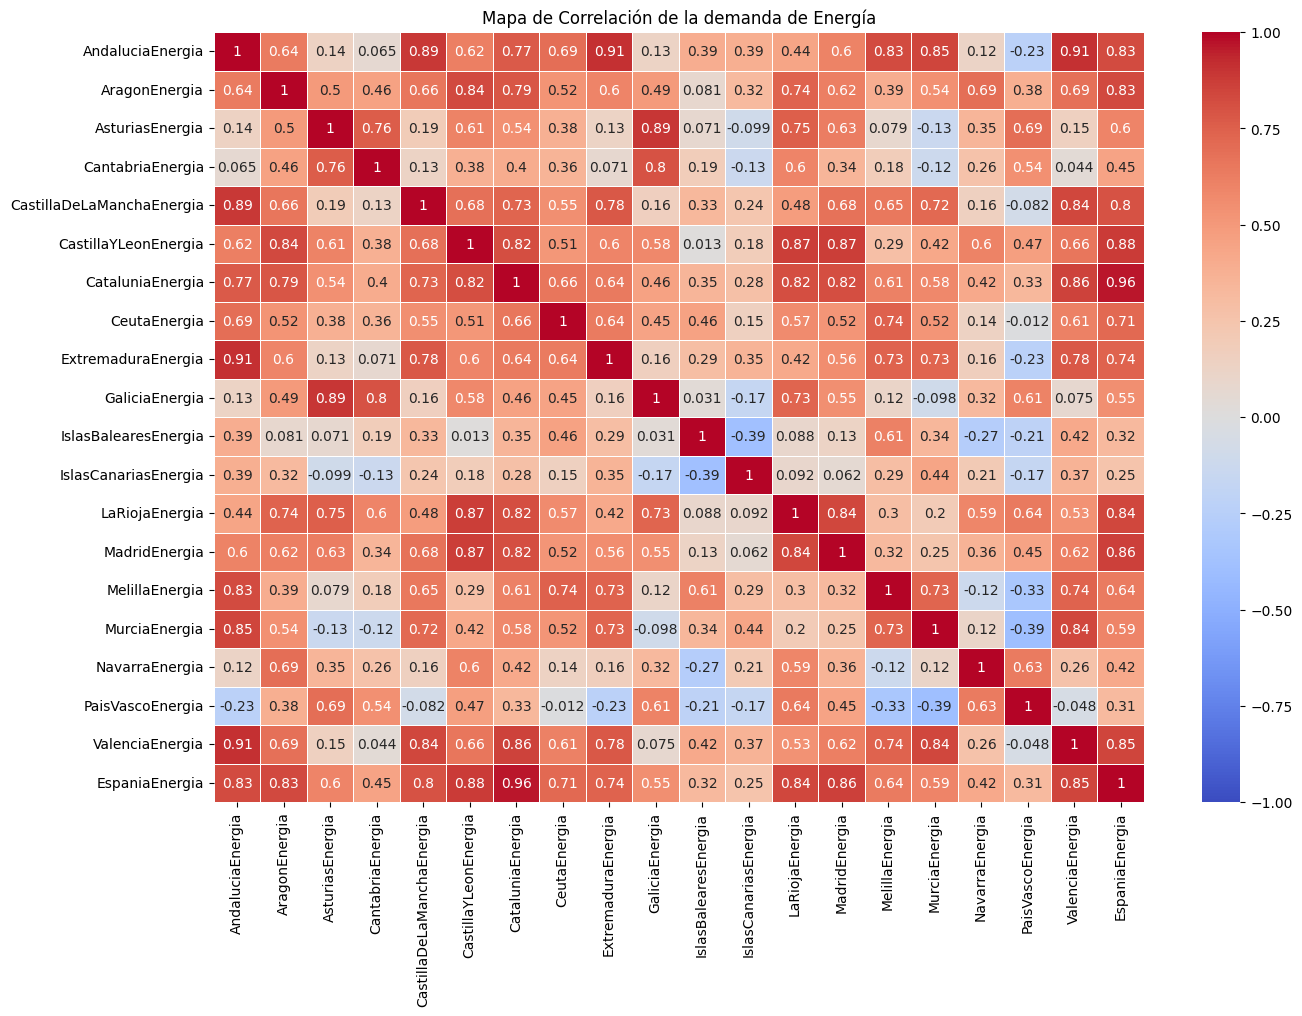

In [93]:
corr_energia = df_final[comunidades_energia_cols + ['EspaniaEnergia']]

plt.figure(figsize=(15, 10))
sns.heatmap(corr_energia.corr(), annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1, center=0)
plt.title('Mapa de Correlación de la demanda de Energía')
plt.show()


### Gráfico de dispersión de la demanda de energía de las comunidades autónomas y nacinonal

Se realizan gráficos de dispersión de la demanda de energía de las diferentes comunidades autónomas con la energía nacional.

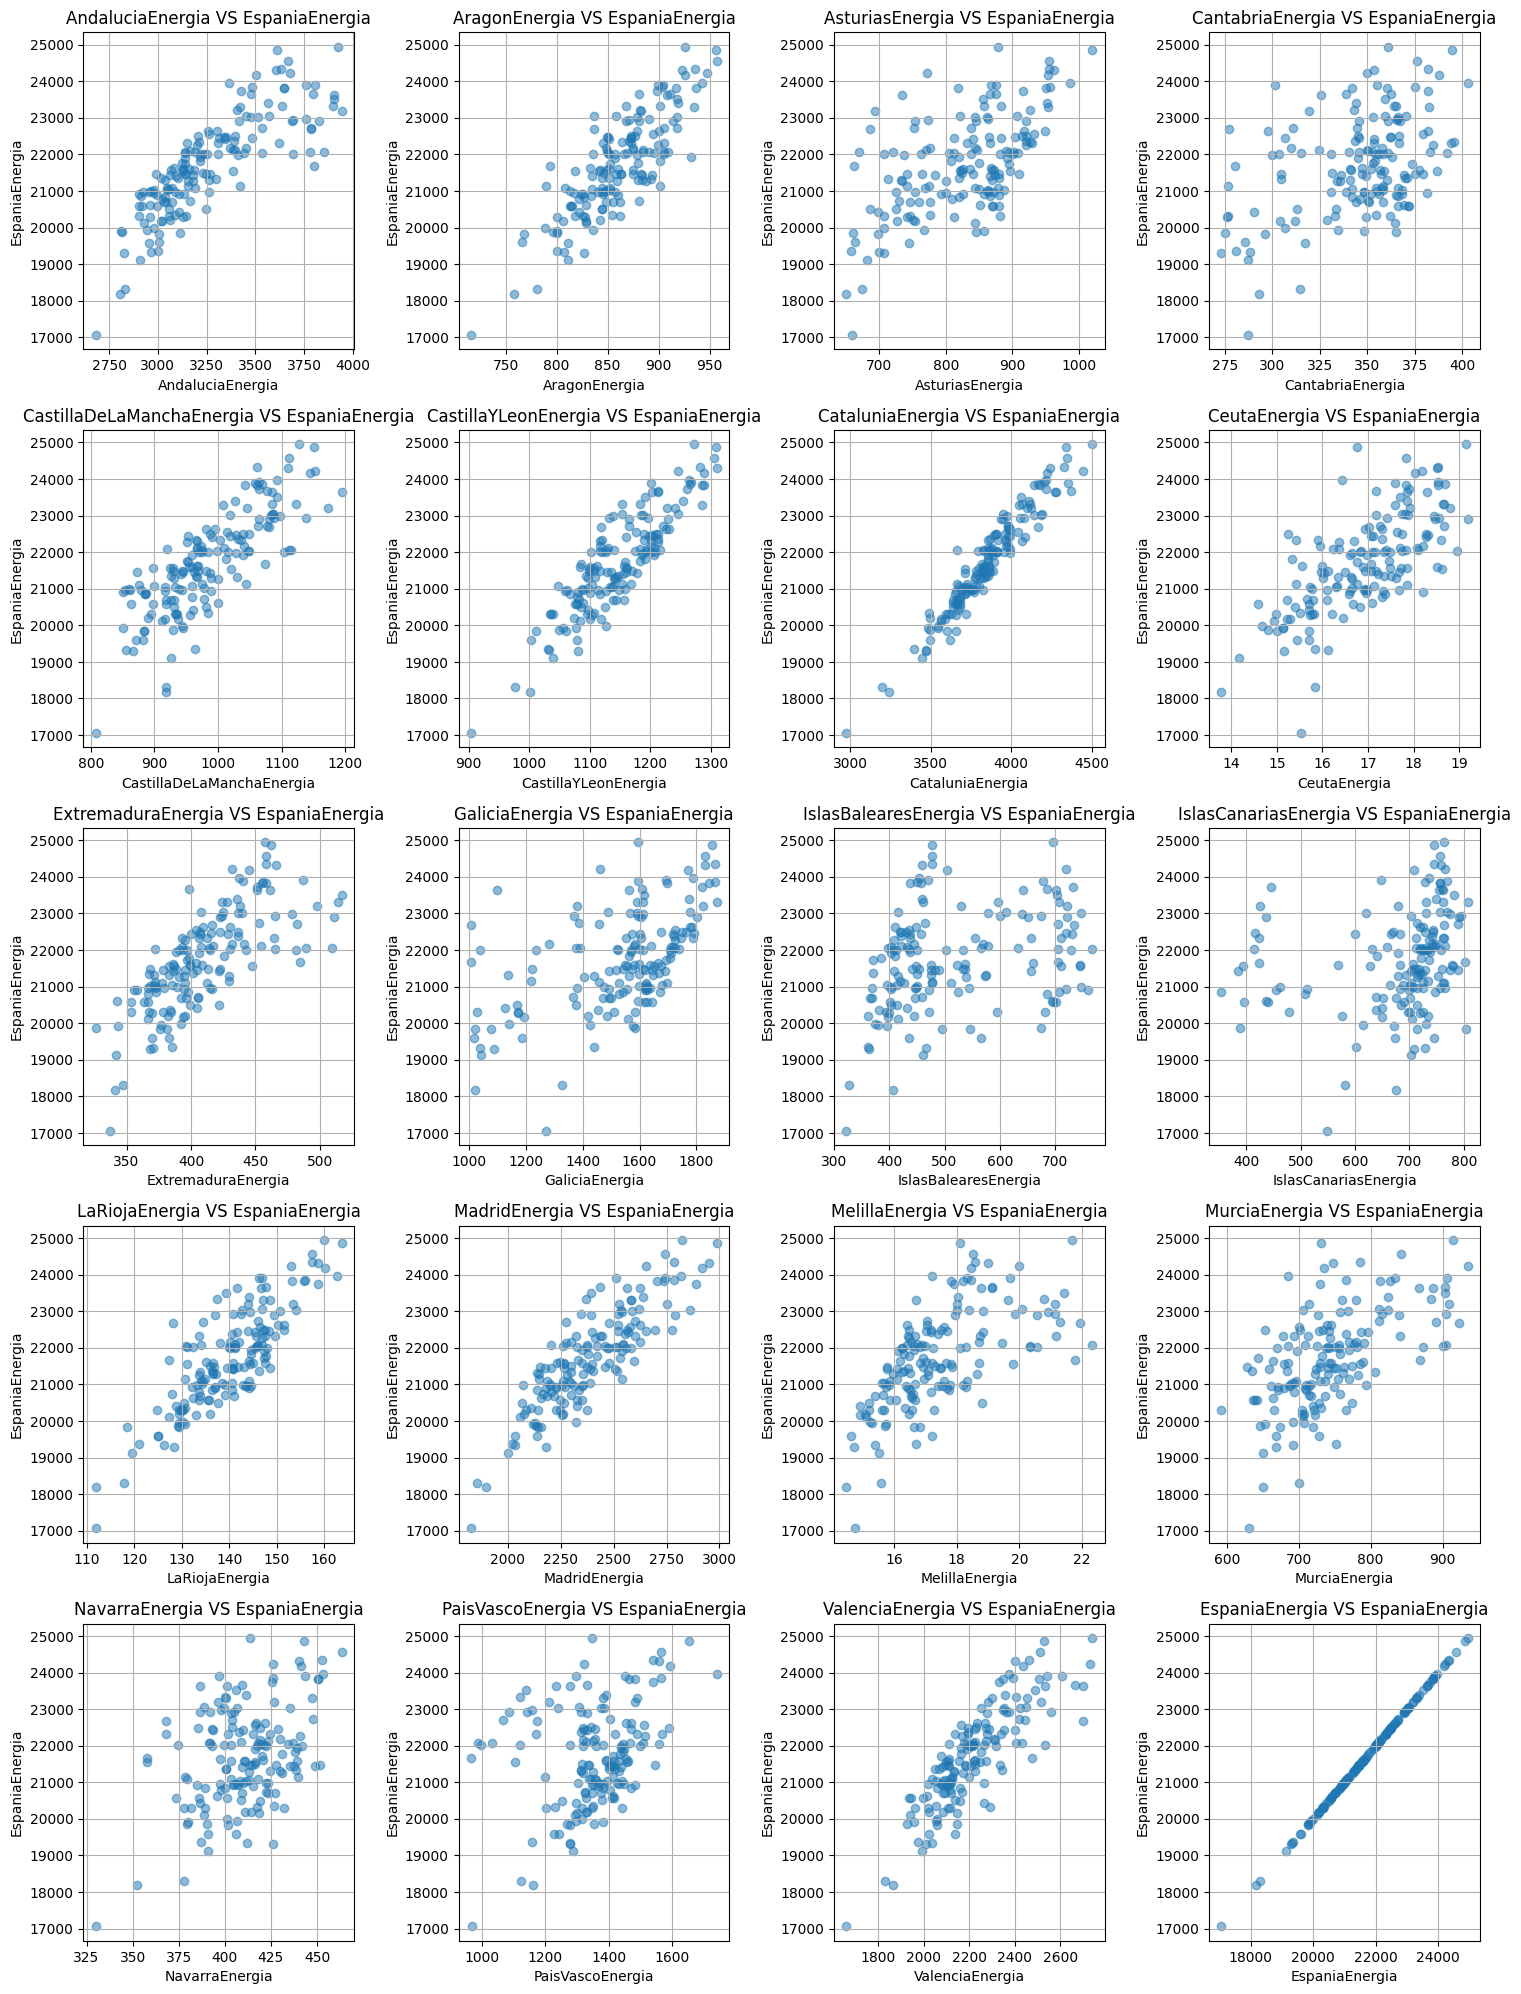

In [94]:
plt.figure(figsize=(15, len(corr_energia) * 2))

for i, col in enumerate(corr_energia):
    plt.subplot(len(corr_energia) // 2 + 1, 4, i + 1)
    plt.scatter(df_final[col], df_final['EspaniaEnergia'], alpha=0.5)
    plt.title(f'{col} VS EspaniaEnergia')
    plt.xlabel(col)
    plt.ylabel('EspaniaEnergia')
    plt.grid(True)

plt.tight_layout()
plt.show()

## Temperatura máxima

### Estadísticas generales de las variables de temperatura máxima.

In [95]:
temp_max_cols = [col for col in df_final.columns if 'TemperaturaMax' in col]

estadisticas_tempmax = df_final[temp_max_cols].describe()
estadisticas_tempmax

AndaluciaTemperaturaMax  AragonTemperaturaMax  AsturiasTemperaturaMax  \
count               157.000000            157.000000              157.000000   
mean                 23.028664             21.173572               16.110909   
std                   7.466574              7.843922                3.765710   
min                  12.264286              9.554839                9.096429   
25%                  16.048387             13.580645               12.748387   
50%                  22.150000             20.483871               15.796667   
75%                  29.276667             27.903333               19.620000   
max                  37.141935             34.906452               22.993548   

       CantabriaTemperaturaMax  CastillaDeLaManchaTemperaturaMax  \
count               157.000000                        157.000000   
mean                 16.507126                         24.694307   
std                   4.747661                          3.631298   
min                   6.714286                         17.445161   
25%                  12.712903                         21.590000   
50%                  16.132258                         24.590323   
75%                  21.116667                         27.636667   
max                  24.861290                         32.053226   

       CastillaYLeonTemperaturaMax  CataluniaTemperaturaMax  \
count                   157.000000               157.000000   
mean                     17.849572                20.782173   
std                       7.902835                 5.437861   
min                       6.277419                11.689286   
25%                      10.190323                15.954839   
50%                      17.230000                20.109677   
75%                      24.600000                25.823333   
max                      33.309677                31.190323   

       CeutaTemperaturaMax  ExtremaduraTemperaturaMax  GaliciaTemperaturaMax  \
count           157.000000                 157.000000             157.000000   
mean             20.525961                  22.259333              15.752760   
std               4.282590                   7.890658               5.542473   
min              13.807143                  10.683871               7.457143   
25%              16.722581                  14.970968              10.603226   
50%              20.277419                  21.377419              15.641935   
75%              24.367742                  29.280000              20.251613   
max              30.261290                  37.819355              27.435484   

       IslasBalearesTemperaturaMax  IslasCanariasTemperaturaMax  \
count                   157.000000                   157.000000   
mean                     22.403624                    20.354923   
std                       6.434398                     3.270711   
min                      11.144828                    13.914286   
25%                      16.567857                    17.632258   
50%                      21.433333                    19.973333   
75%                      28.326667                    23.203226   
max                      34.435484                    27.125806   

       LaRiojaTemperaturaMax  MadridTemperaturaMax  MelillaTemperaturaMax  \
count             157.000000            157.000000             157.000000   
mean               15.009829             20.710530              22.359682   
std                 6.654493              8.330067               4.853429   
min                 2.679310              7.832258              14.568966   
25%                 9.350000             12.896667              17.882759   
50%                14.254839             19.641935              21.822581   
75%                20.813333             28.013333              26.251613   
max                27.893548             36.700000              33.319355   

       MurciaTemperaturaMax  NavarraTemperaturaMax  PaisVascoTemperaturaMax  \
count  

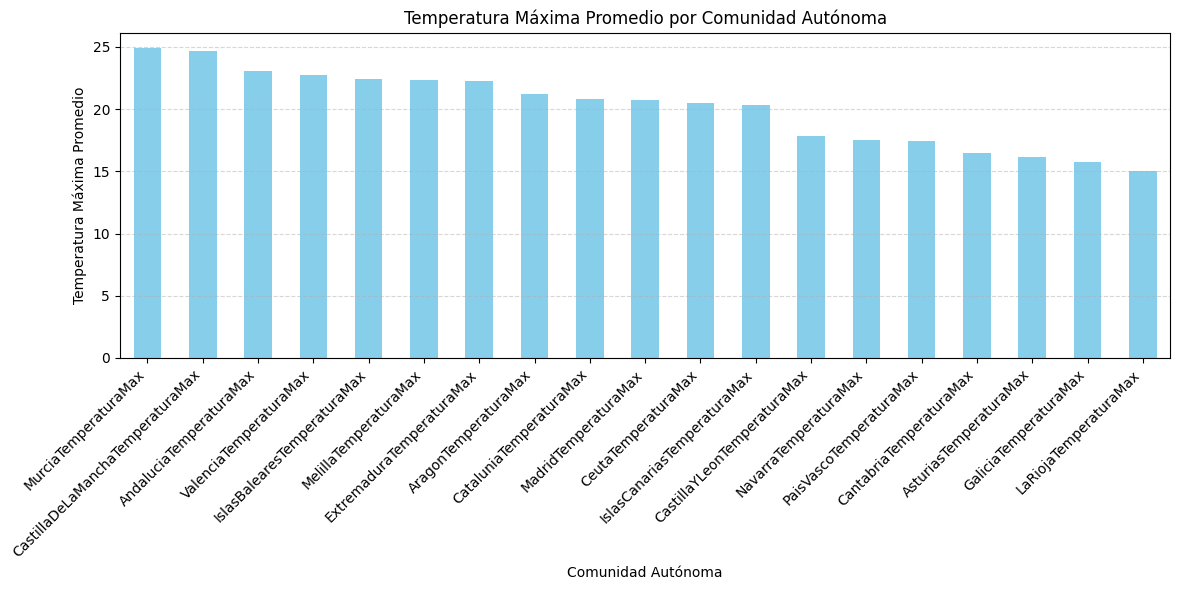

In [96]:
# Gráfico en orden de consumo de energía
temperatura_promedio = estadisticas_tempmax.loc['mean']

temperatura_promedio_ordenado = temperatura_promedio.sort_values(ascending=False)
plt.figure(figsize=(12, 6))
temperatura_promedio_ordenado.plot(kind='bar', color='skyblue')

plt.title('Temperatura Máxima Promedio por Comunidad Autónoma')
plt.xlabel('Comunidad Autónoma')
plt.ylabel('Temperatura Máxima Promedio')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

### Boxplots de temperatura máxima

Se realizan gráficos boxplots de la temperatura máxima de las diferentes comunidades autónomas.

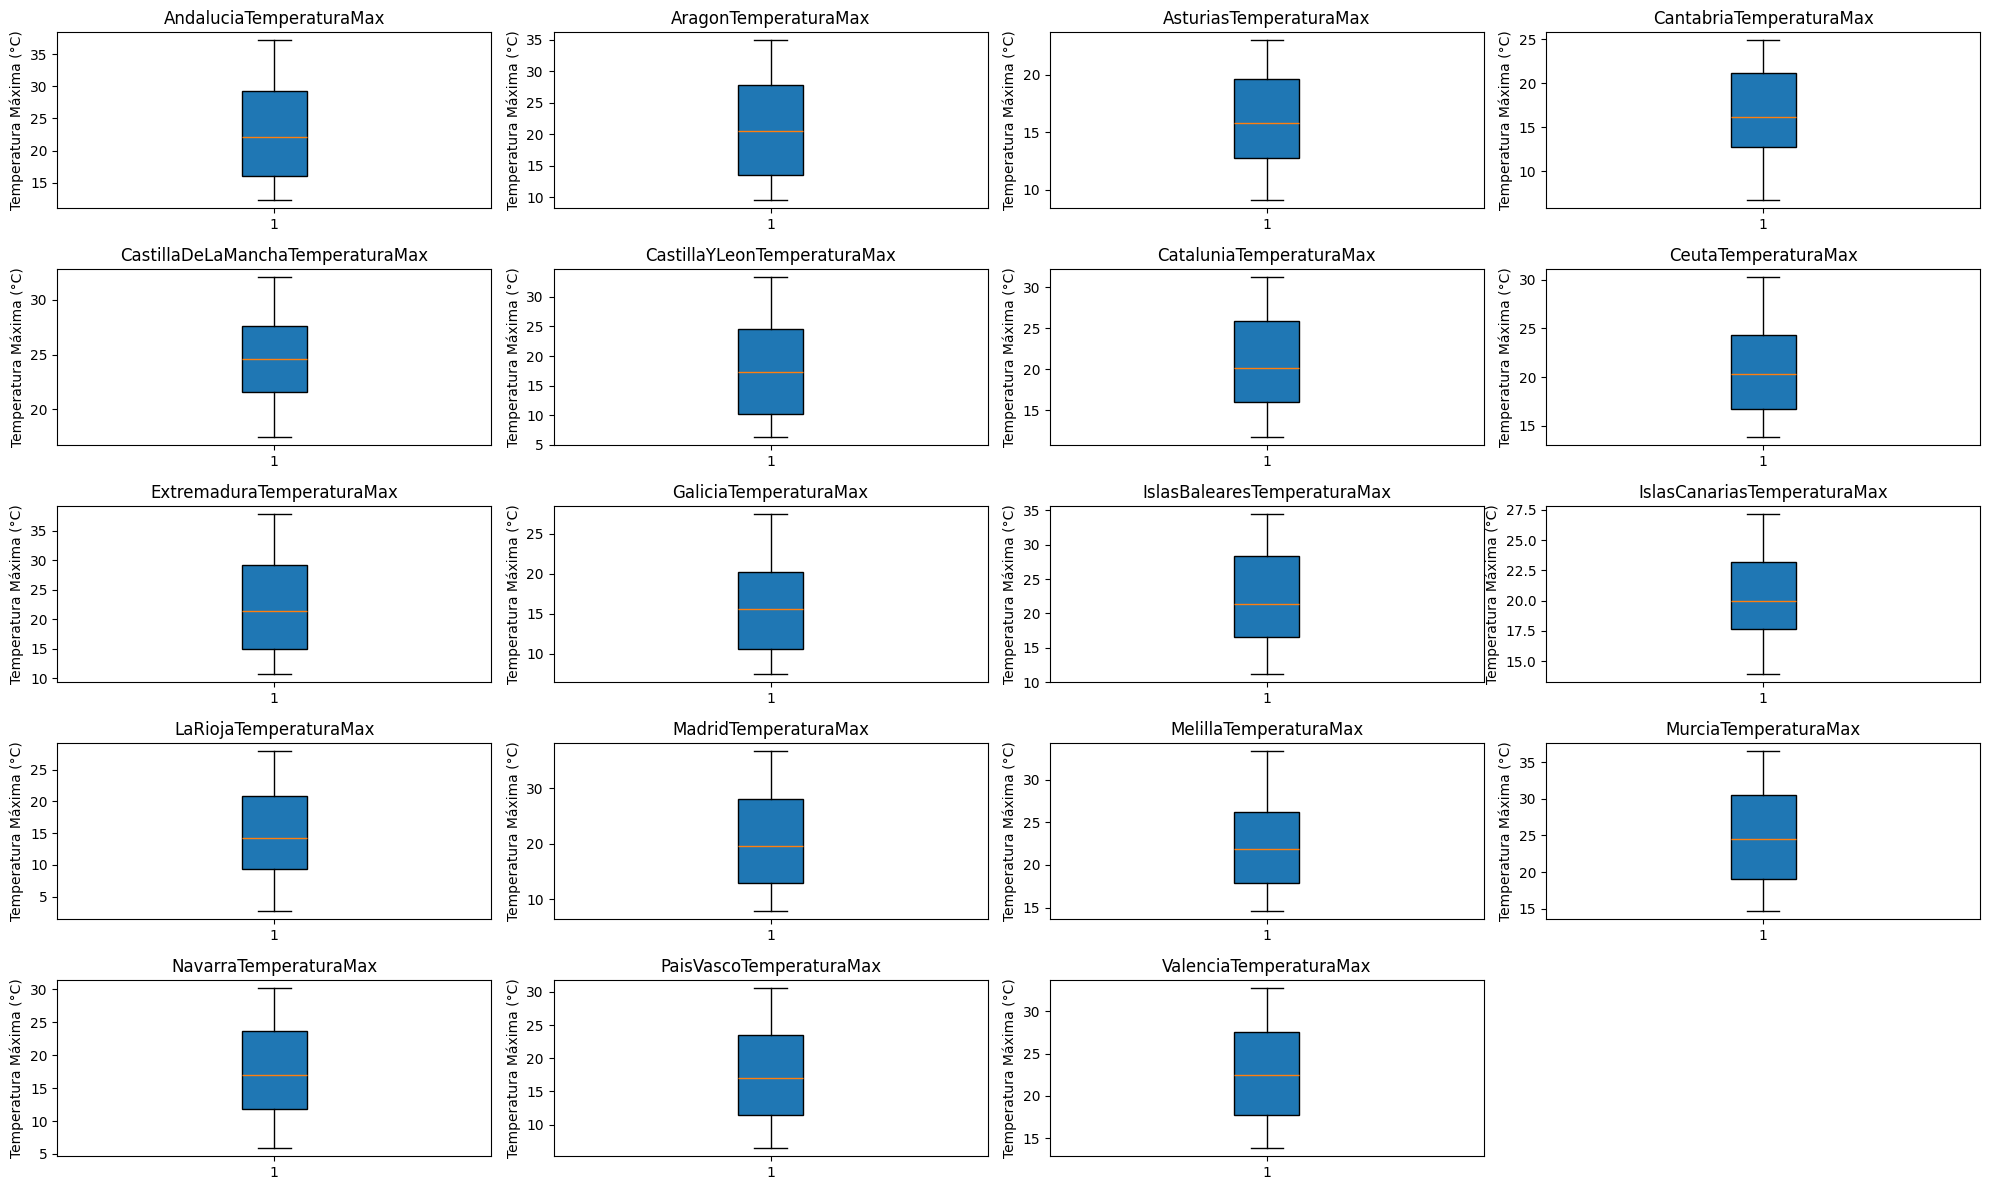

In [97]:
n_cols = 4
n_rows = -(-len(temp_max_cols) // n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 12), squeeze=False)

for ax, col in zip(axs.flatten(), temp_max_cols):
    ax.boxplot(df_final[col].dropna(), vert=True, patch_artist=True)
    ax.set_title(col)
    ax.set_ylabel('Temperatura Máxima (°C)')

for ax in axs.flatten()[len(temp_max_cols):]:
    ax.remove()

plt.tight_layout()
plt.show()


### Gráfico de líneas de temperatura máxima

Se realizan los diferentes gráficos de líneas de la temperatura máxima para cada una de las comunidades autónomas.

In [98]:
for col in temp_max_cols:
    fig = px.line(
        df_final_reset,
        x='Fecha',
        y=col,
        title=f'Evolución de la temperatura {col} vs Tiempo',
        labels={'Fecha': 'Fecha', col: 'Temperatura Máxima (°C)'}
    )
    fig.show()


### Correlación entre temperatura máxima y demanda de energía nacional

Se realiza la correlación entre las temperaturas máximas de cada comunidad autónoma y de la demanda de energía nacional.



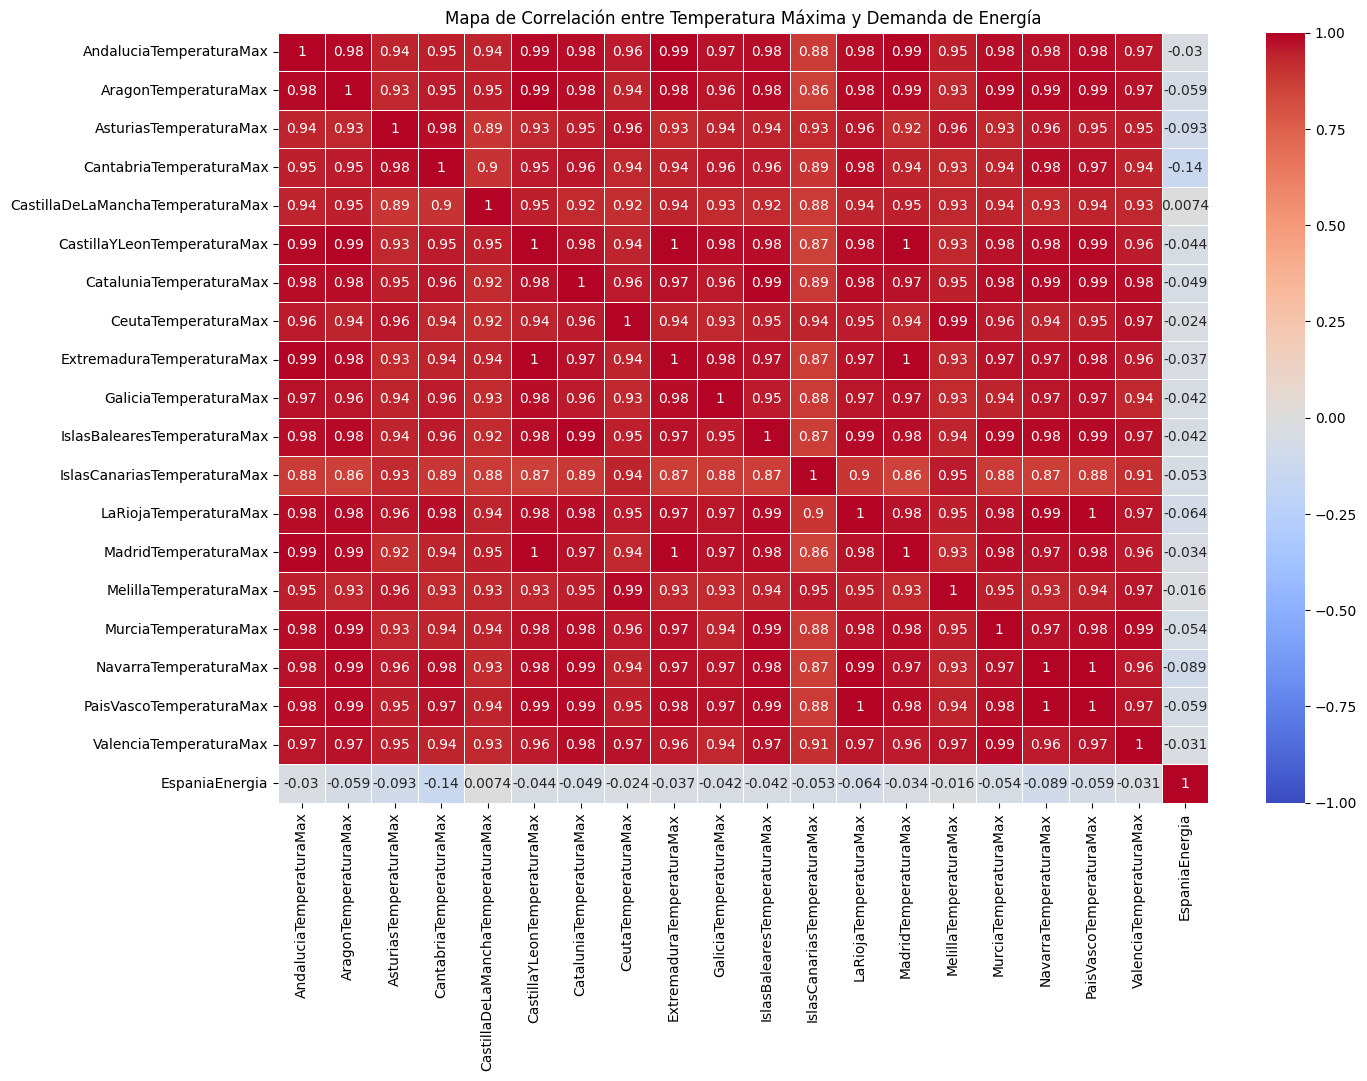

In [99]:
temp_max_espania_energia = temp_max_cols + ['EspaniaEnergia']

df_tempmax = df_final[temp_max_espania_energia]

plt.figure(figsize=(15, 10))
sns.heatmap(df_tempmax.corr(), annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1, center=0)
plt.title('Mapa de Correlación entre Temperatura Máxima y Demanda de Energía')
plt.show()

### Gráficos de dispersión de temperatura máxima versus demanda de energía nacional

Se realizan distintos gráficos de dispersión entre temperatura máxima y la demanda de energía nacional.

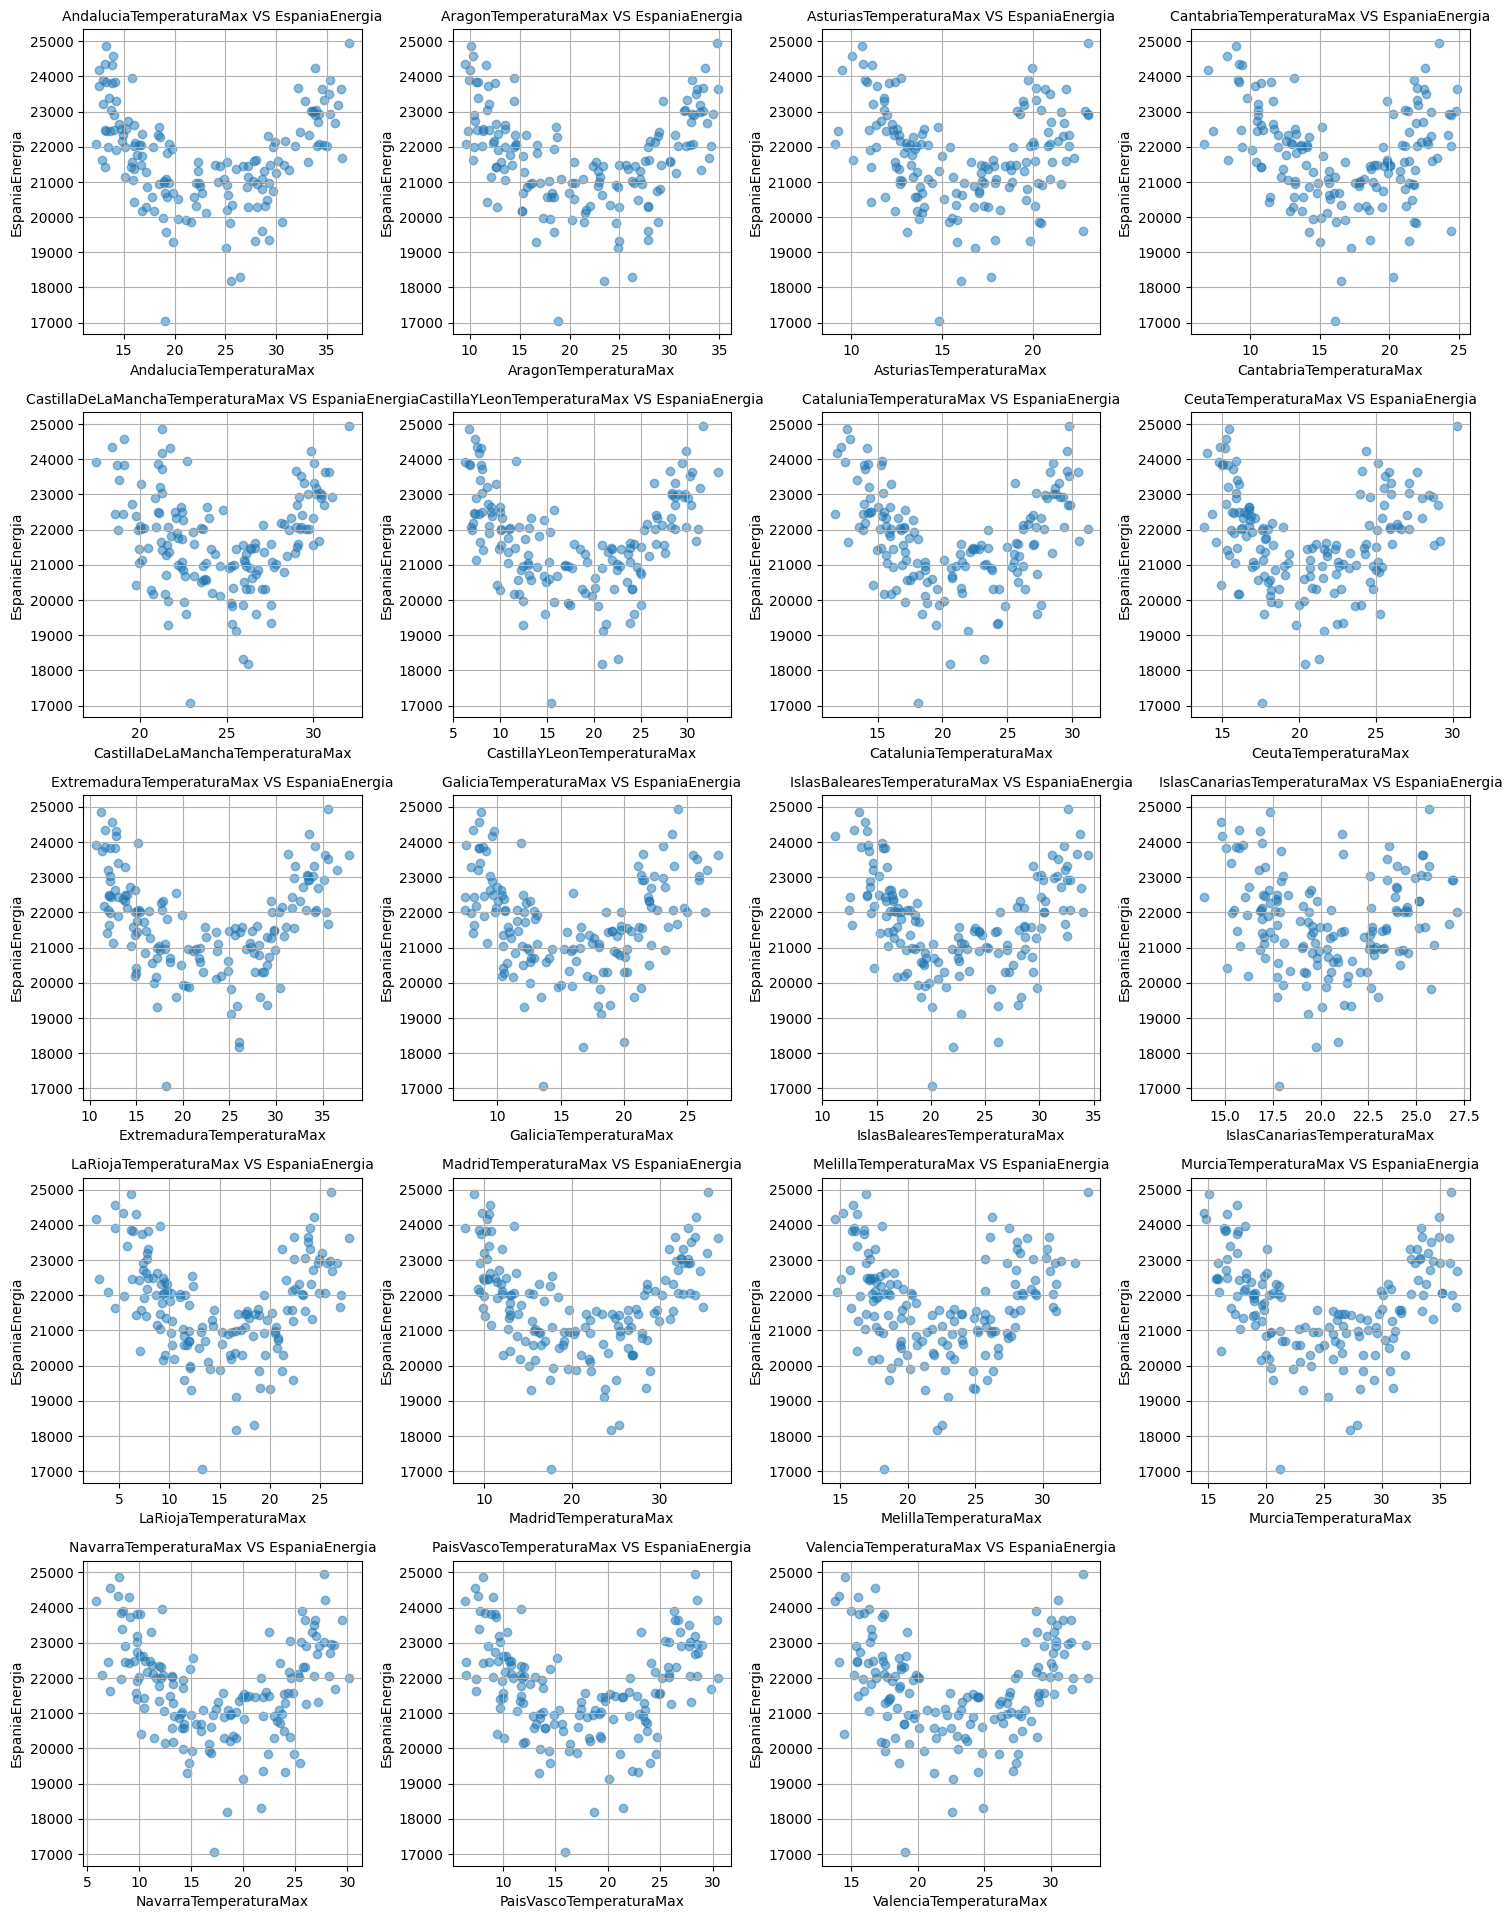

In [100]:
plt.figure(figsize=(15, len(temp_max_cols) * 2))

for i, col in enumerate(temp_max_cols):
    plt.subplot(len(temp_max_cols) // 2 + 1, 4, i + 1)
    plt.scatter(df_final[col], df_final['EspaniaEnergia'], alpha=0.5)
    plt.title(f'{col} VS EspaniaEnergia', fontsize=10)
    plt.xlabel(col)
    plt.ylabel('EspaniaEnergia')
    plt.grid(True)

plt.tight_layout()
plt.show()

## Temperatura Mínima

### Estadísticas generales de las variables de temperatura mínima.

In [101]:
temp_min_cols = [col for col in df_final.columns if 'TemperaturaMin' in col]

estadisticas_tempmin = df_final[temp_min_cols].describe()
estadisticas_tempmin

AndaluciaTemperaturaMin  AragonTemperaturaMin  AsturiasTemperaturaMin  \
count               157.000000            157.000000              157.000000   
mean                 11.739468             10.596459               10.251446   
std                   5.826556              5.732219                3.639466   
min                   0.441379             -0.151724                3.727586   
25%                   6.750000              5.632143                7.106667   
50%                  10.958065             10.256667                9.619355   
75%                  16.890000             16.096667               13.719355   
max                  22.545161             20.958065               16.500000   

       CantabriaTemperaturaMin  CastillaDeLaManchaTemperaturaMin  \
count               157.000000                        157.000000   
mean                  8.402316                         17.234400   
std                   4.225771                          2.893119   
min                  -0.262069                         11.743103   
25%                   4.813333                         14.938710   
50%                   7.946667                         17.105000   
75%                  12.416129                         19.540000   
max                  15.738710                         26.268750   

       CastillaYLeonTemperaturaMin  CataluniaTemperaturaMin  \
count                   157.000000               157.000000   
mean                      6.918701                12.872109   
std                       5.387858                 5.846135   
min                      -2.103448                 2.877419   
25%                       2.112903                 7.793548   
50%                       6.333333                12.206667   
75%                      11.973333                18.533333   
max                      16.529032                23.258065   

       CeutaTemperaturaMin  ExtremaduraTemperaturaMin  GaliciaTemperaturaMin  \
count           157.000000                 157.000000             157.000000   
mean             15.978611                  11.399954               7.350906   
std               3.552755                   5.969623               4.045961   
min               9.089655                   0.831034              -0.586207   
25%              12.790323                   6.461290               3.806667   
50%              15.509677                  10.843333               6.966667   
75%              19.393548                  16.560000              11.270968   
max              22.306452                  22.406452              14.716129   

       IslasBalearesTemperaturaMin  IslasCanariasTemperaturaMin  \
count                   157.000000                   157.000000   
mean                     13.798570                    14.696329   
std                       5.391405                     2.900448   
min                       4.800000                     9.274194   
25%                       9.003226                    12.372414   
50%                      13.109677                    14.536667   
75%                      18.826667                    17.213333   
max                      23.087097                    20.045161   

       LaRiojaTemperaturaMin  MadridTemperaturaMin  MelillaTemperaturaMin  \
count             157.000000            157.000000             157.000000   
mean                5.387826              9.463202              16.008703   
std                 4.966601              6.586588               4.512173   
min                -5.337931             -1.482759               7.344828   
25%                 1.000000              3.692857              12.110714   
50%                 4.906667              8.506667              15.274194   
75%                10.213333             15.236667              20.443333   
max                14.412903             21.622581              23.861290   

       MurciaTemperaturaMin  NavarraTemperaturaMin  PaisVascoTemperaturaMin  \
count  

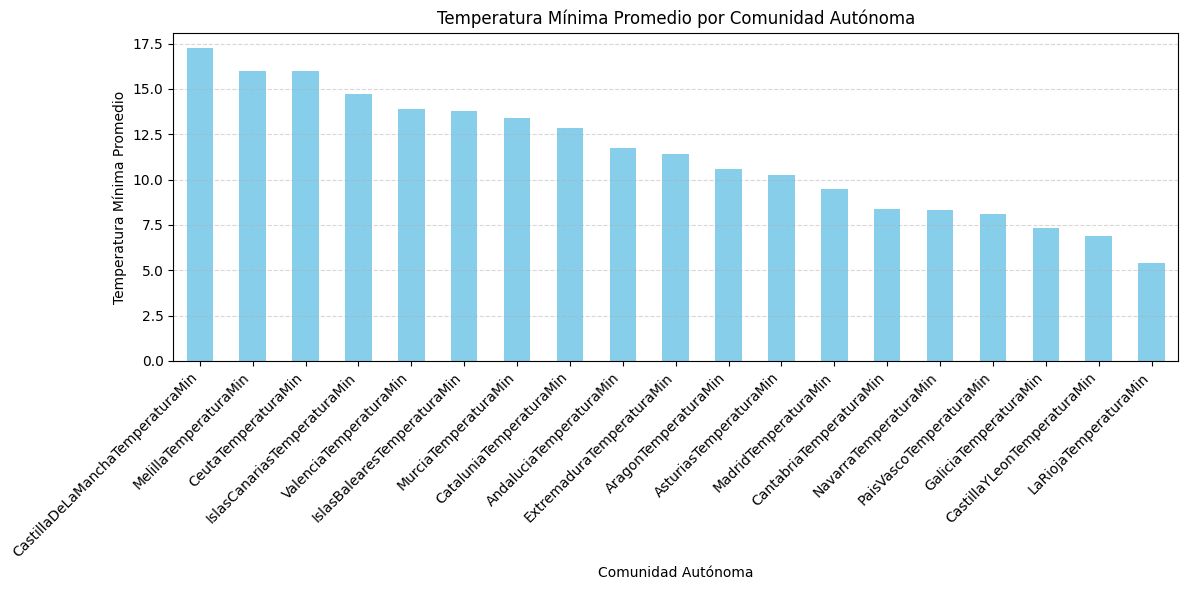

In [102]:
# Gráfico en orden de consumo de energía
temperatura_promedio = estadisticas_tempmin.loc['mean']

temperatura_promedio_ordenado = temperatura_promedio.sort_values(ascending=False)
plt.figure(figsize=(12, 6))
temperatura_promedio_ordenado.plot(kind='bar', color='skyblue')

plt.title('Temperatura Mínima Promedio por Comunidad Autónoma')
plt.xlabel('Comunidad Autónoma')
plt.ylabel('Temperatura Mínima Promedio')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

### Boxplots de temperatura mínima

Se realizan gráficos boxplots de la temperatura mínima de las diferentes comunidades autónomas.

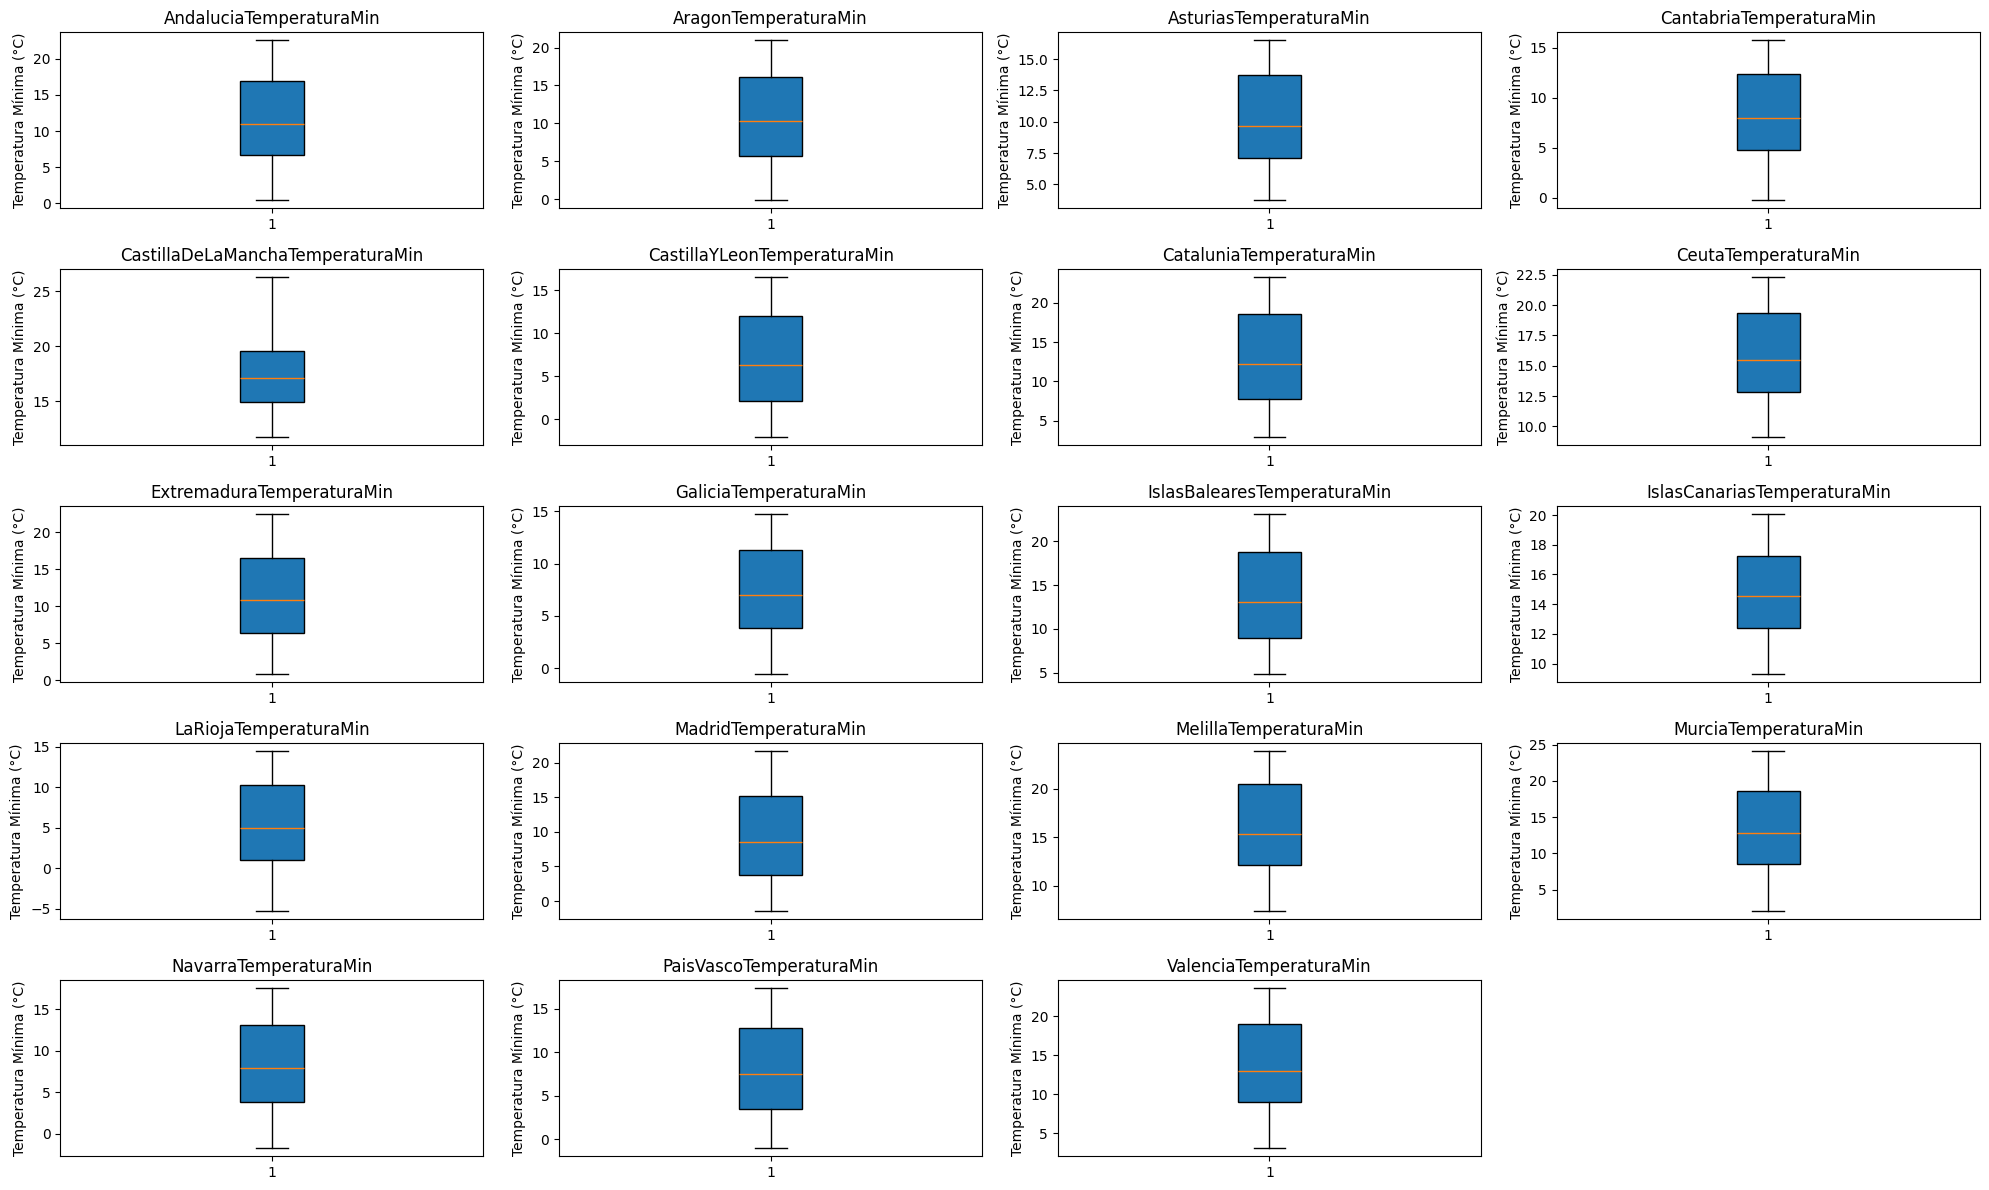

In [103]:
n_cols = 4
n_rows = -(-len(temp_min_cols) // n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 12), squeeze=False)

for ax, col in zip(axs.flatten(), temp_min_cols):
    ax.boxplot(df_final[col].dropna(), vert=True, patch_artist=True)
    ax.set_title(col)
    ax.set_ylabel('Temperatura Mínima (°C)')

for ax in axs.flatten()[len(temp_min_cols):]:
    ax.remove()

plt.tight_layout()
plt.show()


### Gráfico de líneas de temperatura mínima

Se realizan los diferentes gráficos de líneas de la temperatura mínima para cada una de las comunidades autónomas.


In [104]:
for col in temp_min_cols:
    fig = px.line(
        df_final_reset,
        x='Fecha',
        y=col,
        title=f'Evolución de la temperatura {col} vs Tiempo',
        labels={'Fecha': 'Fecha', col: 'Temperatura Mínima (°C)'}
    )
    fig.show()


### Correlación entre temperatura mínima y demanda de energía nacional

Se realiza la correlación entre las temperaturas mínima de cada comunidad autónoma y de la demanda de energía nacional.

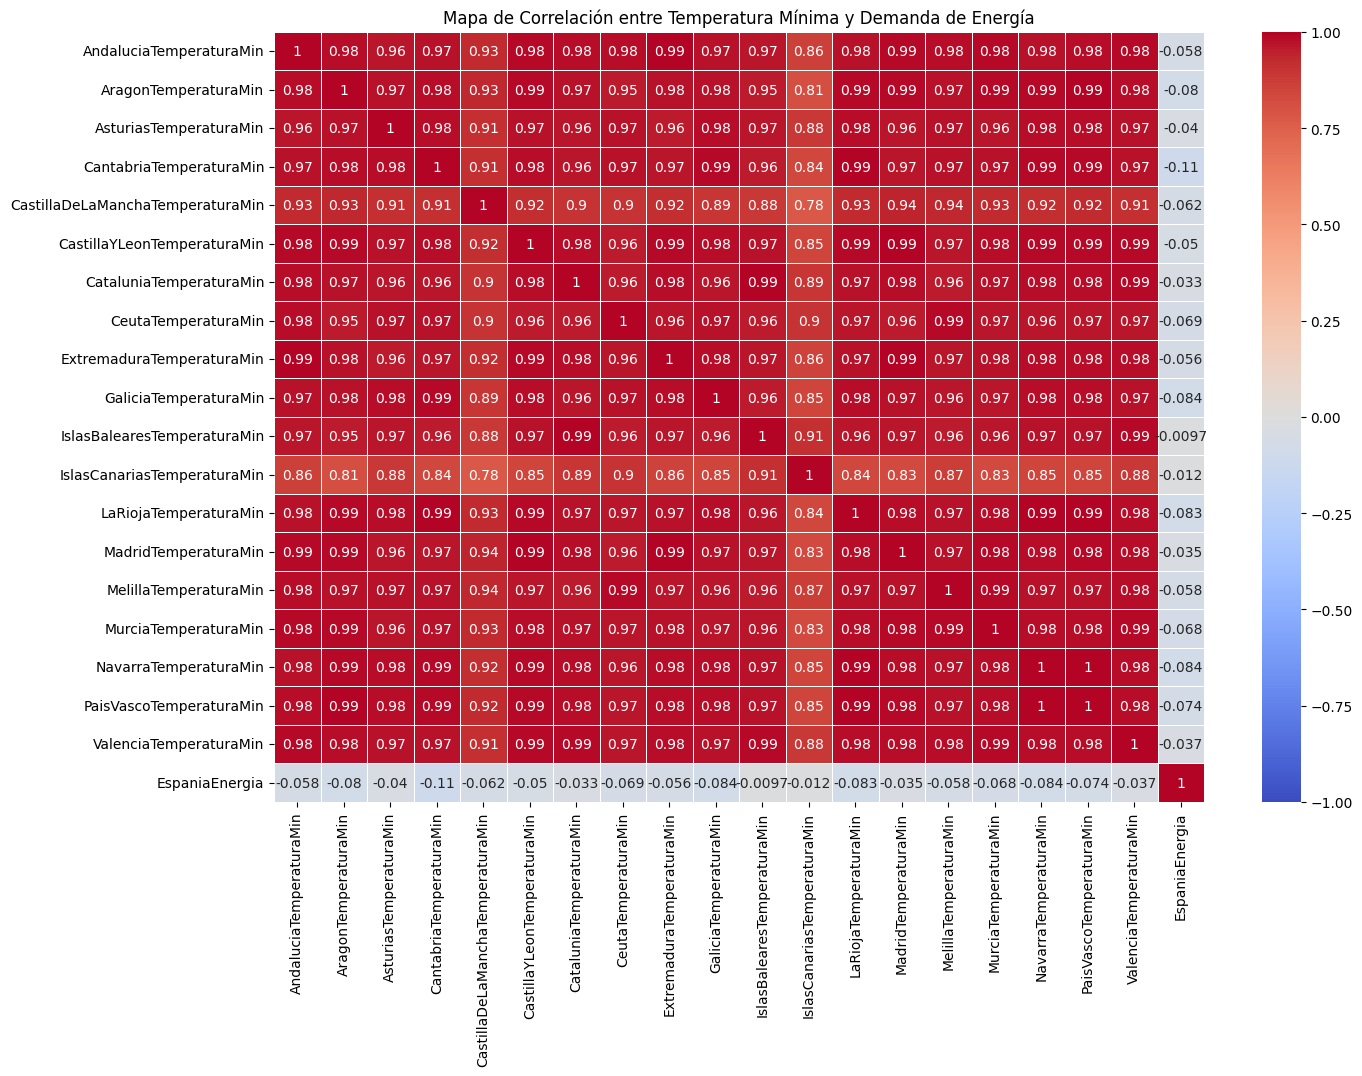

In [105]:
temp_min_espania_energia = temp_min_cols + ['EspaniaEnergia']

df_tempmin = df_final[temp_min_espania_energia]

plt.figure(figsize=(15, 10))
sns.heatmap(df_tempmin.corr(), annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1, center=0)
plt.title('Mapa de Correlación entre Temperatura Mínima y Demanda de Energía')
plt.show()

### Gráficos de dispersión entre temperatura mínima y demanda de energía nacional

Se realizan distintos gráficos de dispersión entre temperatura máxima y la demanda de energía nacional.

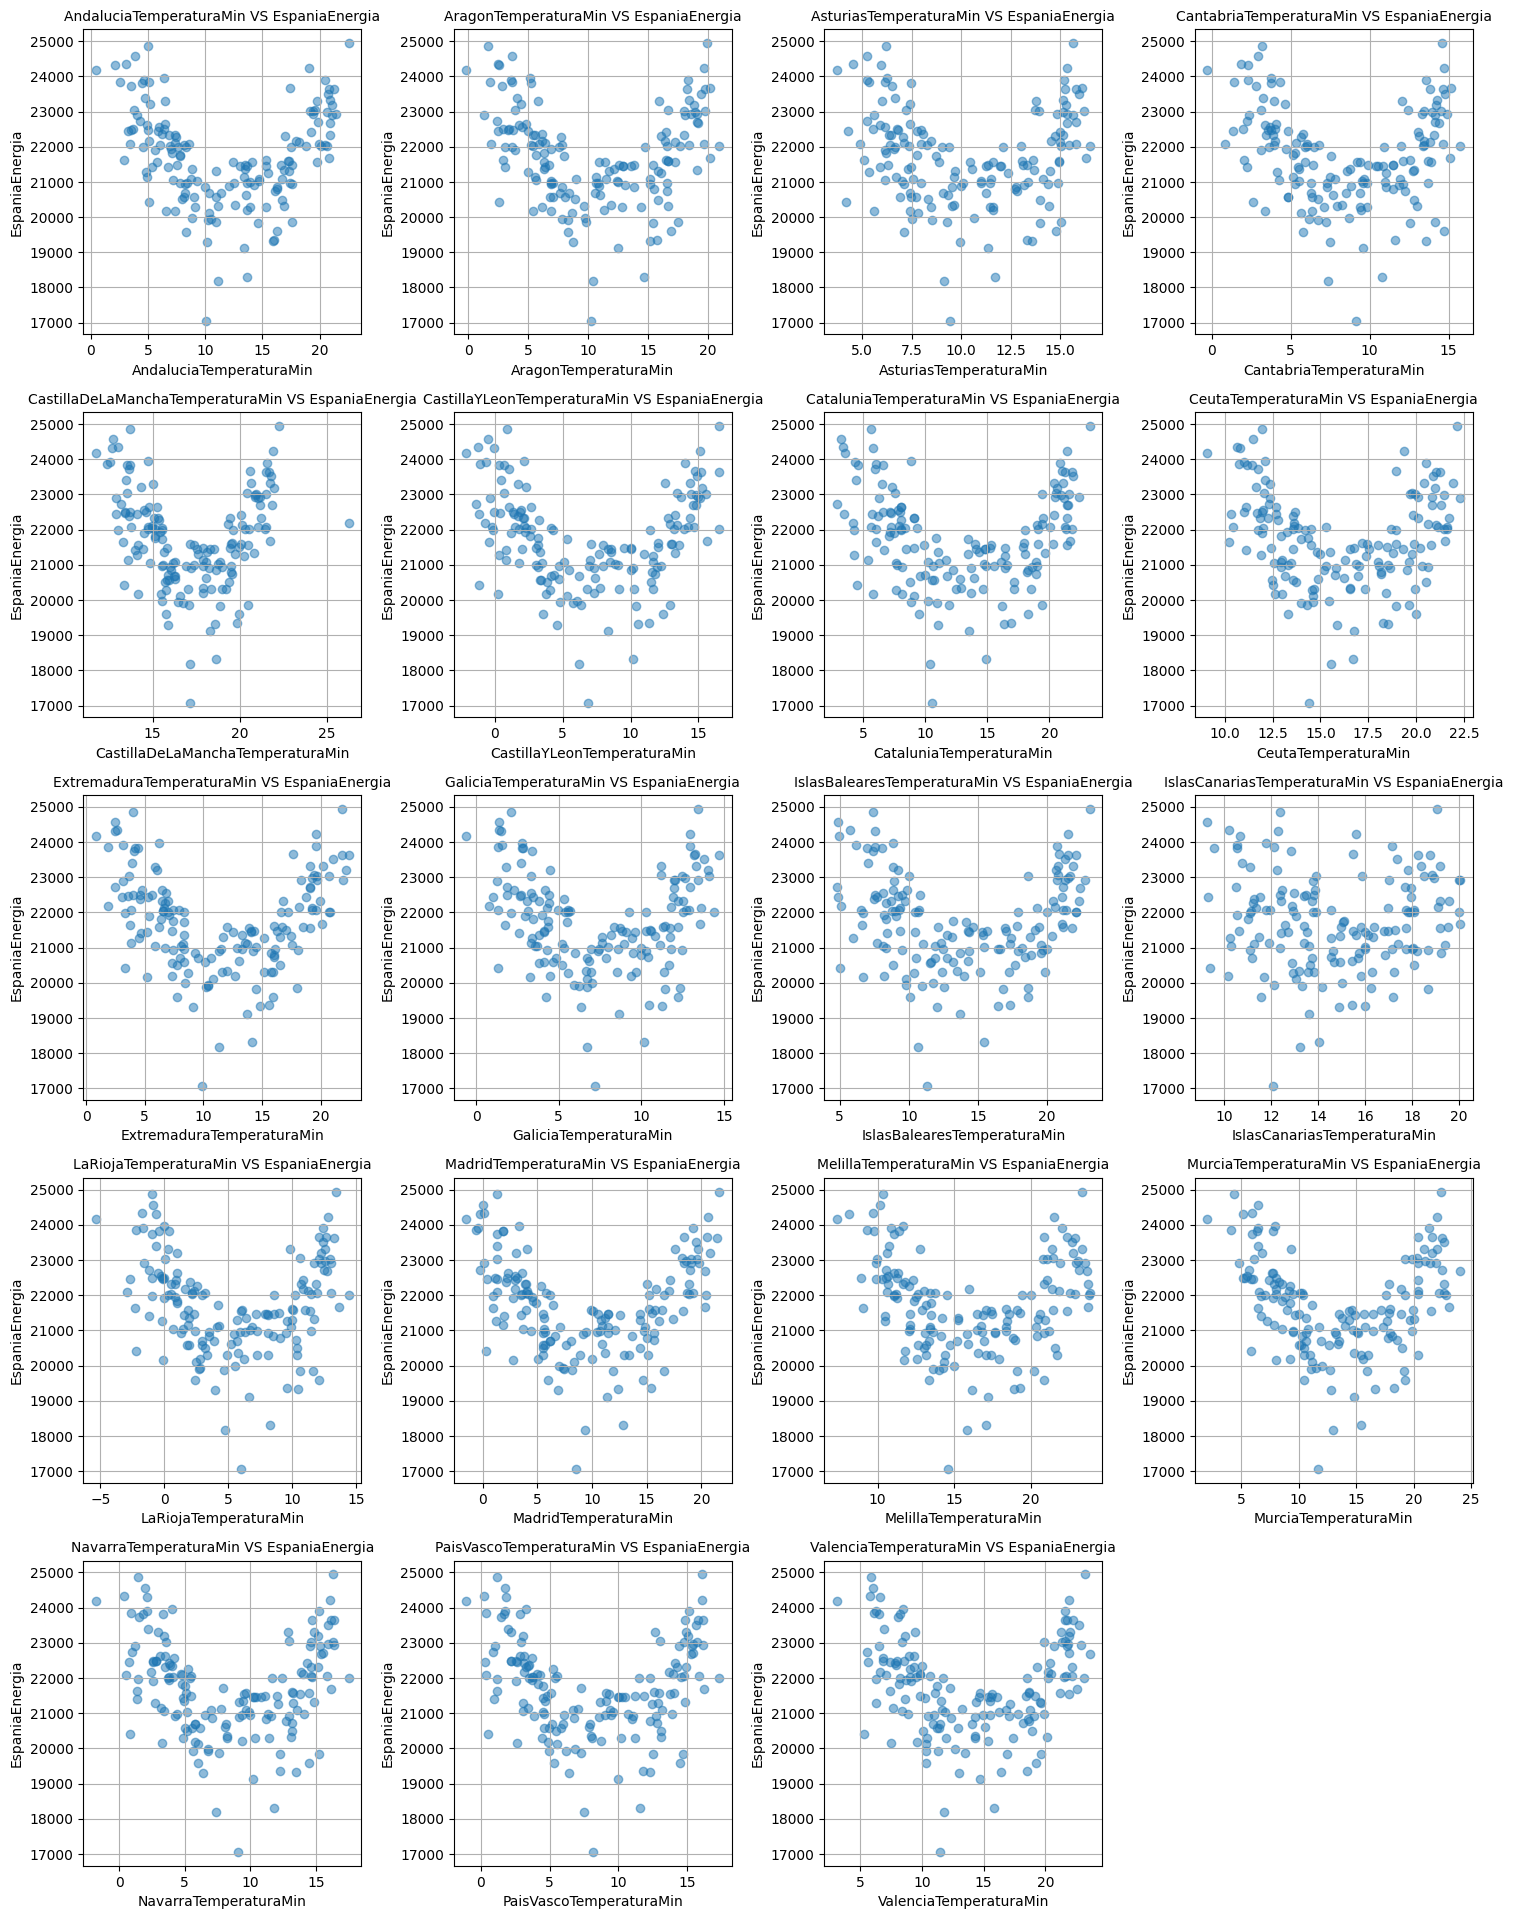

In [106]:
plt.figure(figsize=(15, len(temp_min_cols) * 2))

for i, col in enumerate(temp_min_cols):
    plt.subplot(len(temp_min_cols) // 2 + 1, 4, i + 1)
    plt.scatter(df_final[col], df_final['EspaniaEnergia'], alpha=0.5)
    plt.title(f'{col} VS EspaniaEnergia', fontsize=10)
    plt.xlabel(col)
    plt.ylabel('EspaniaEnergia')
    plt.grid(True)

plt.tight_layout()
plt.show()

### Gráfico de correlación entre temperaturas máxima y mínima

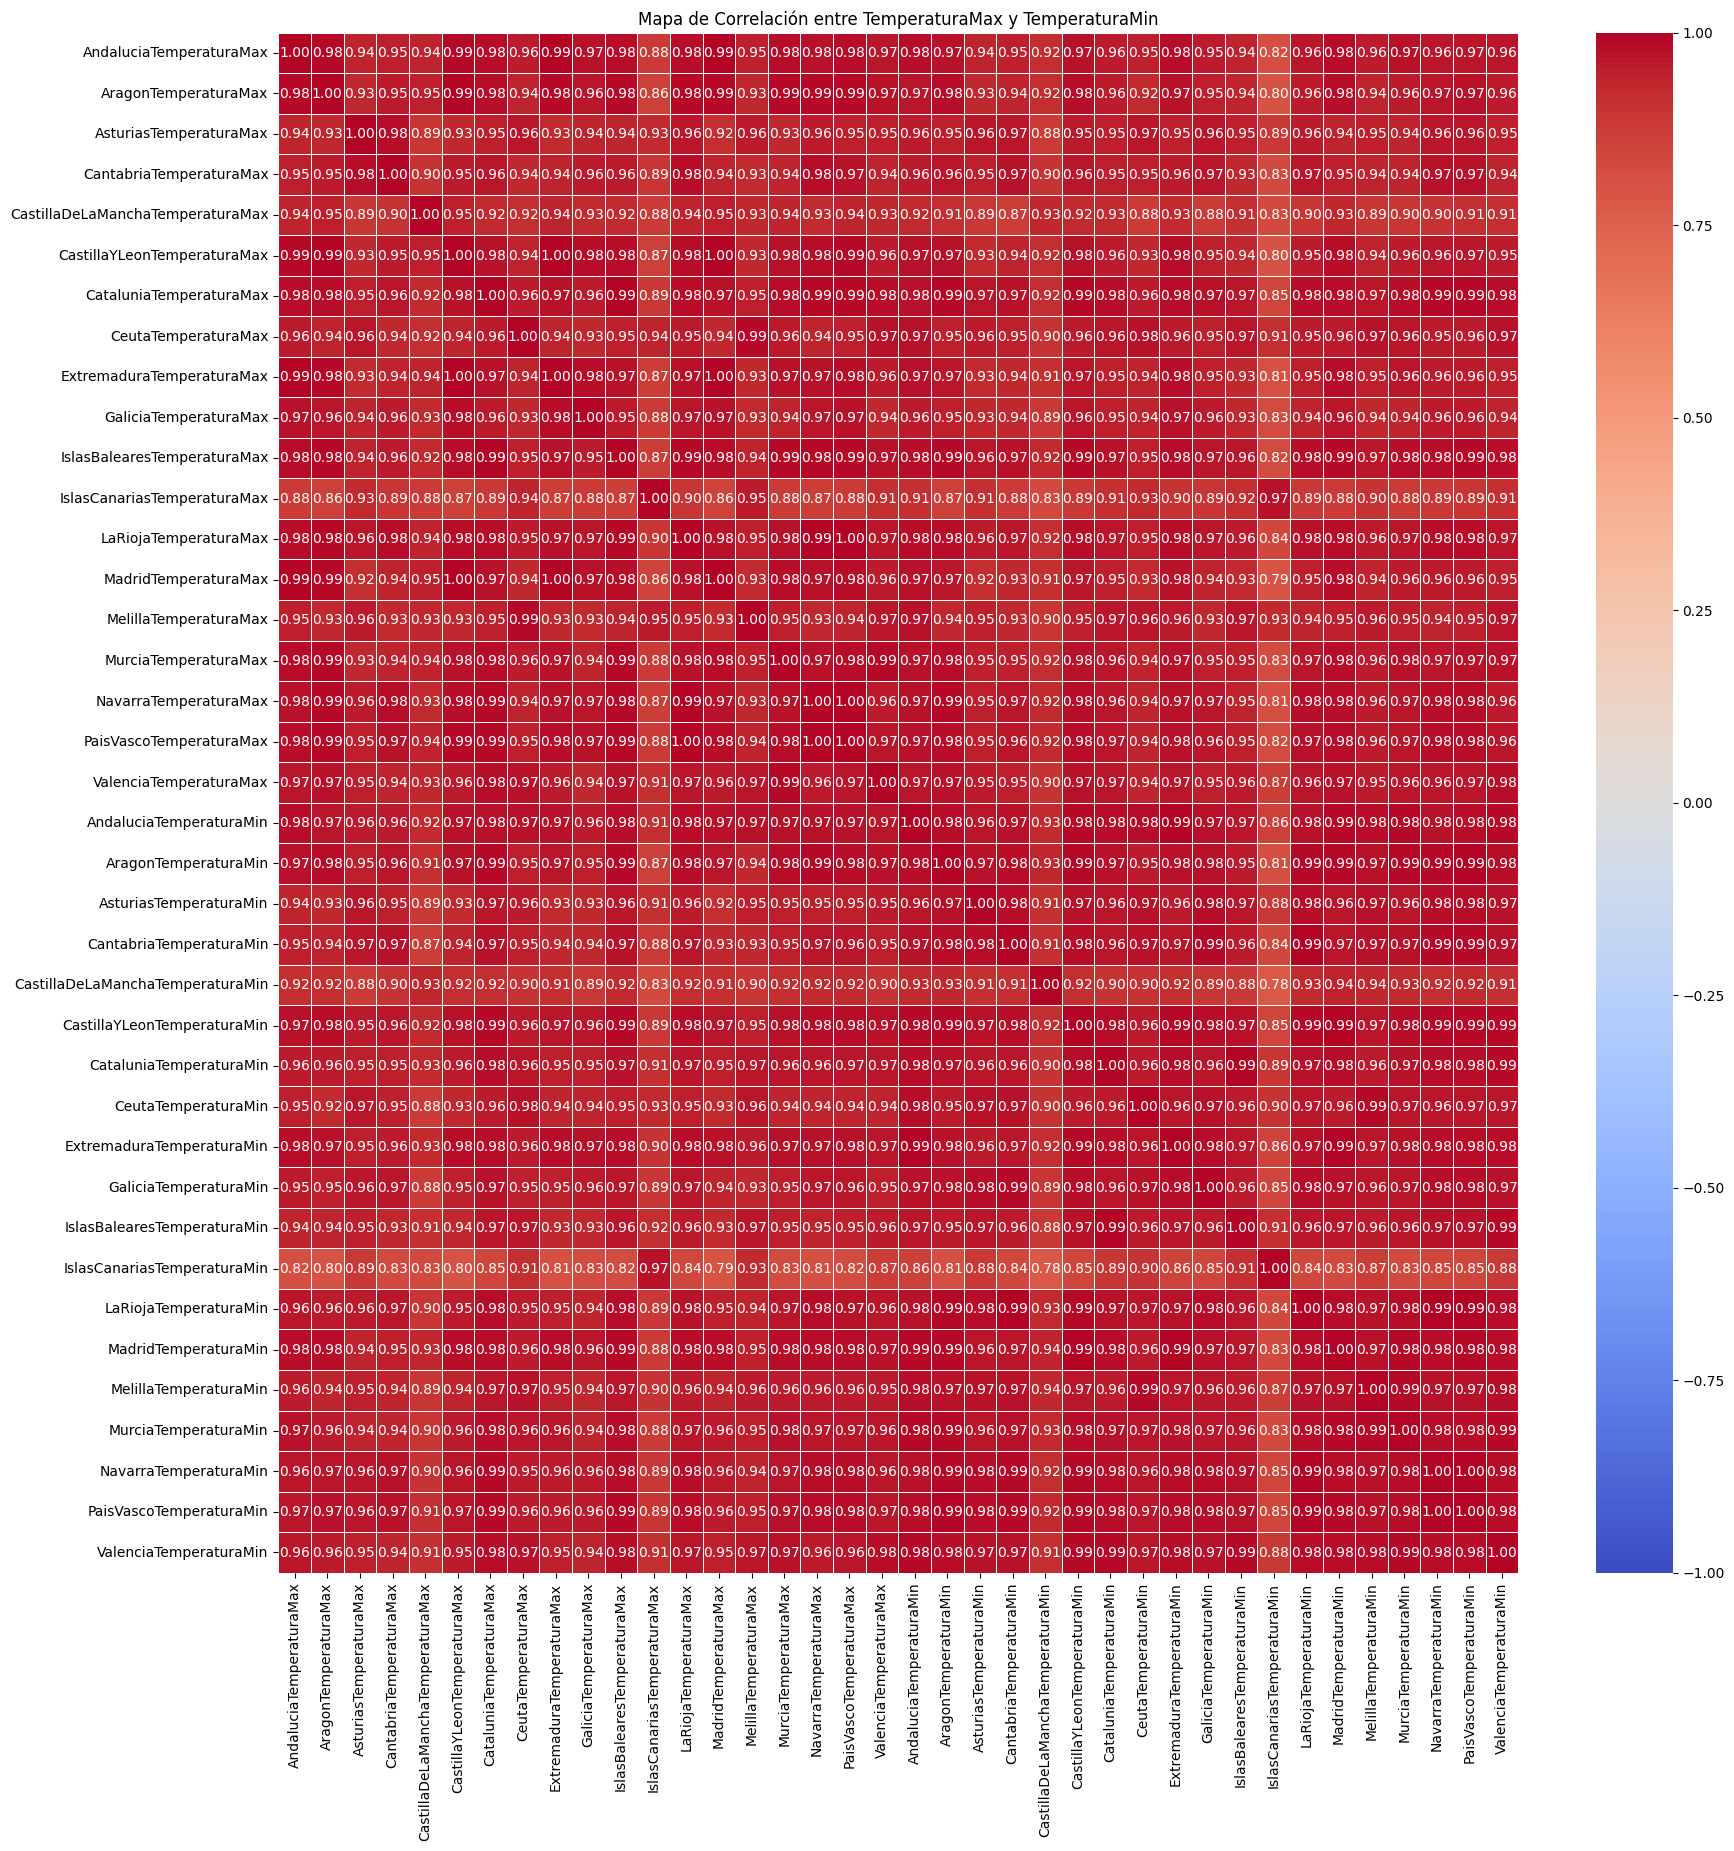

In [107]:
columnas_temperatura = [col for col in df_final.columns if 'TemperaturaMax' in col or 'TemperaturaMin' in col]
df_temperaturas = df_final[columnas_temperatura].dropna()

correlacion_temperaturas = df_temperaturas.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(correlacion_temperaturas, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1, center=0)

plt.title('Mapa de Correlación entre TemperaturaMax y TemperaturaMin')

plt.show()

## Duración del día

### Estadísticas generales de las variables de duración del día.

In [108]:
dura_dia_cols = [col for col in df_final.columns if 'DuracionDia' in col]

estadisticas_duradia = df_final[dura_dia_cols].describe()
estadisticas_duradia

AndaluciaDuracionDia  AragonDuracionDia  AsturiasDuracionDia  \
count            157.000000         157.000000           157.000000   
mean           43808.681288       43860.130621         43888.468557   
std             6342.733304        7408.823099          7961.951625   
min            34686.587419       33190.430323         32413.547742   
25%            36677.723333       35538.738667         34951.127000   
50%            43174.702258       43120.346452         43093.520000   
75%            48858.256774       49740.568710         50196.481290   
max            52901.507333       54502.143333         55338.690333   

       CantabriaDuracionDia  CastillaDeLaManchaDuracionDia  \
count            157.000000                     157.000000   
mean           43883.173831                   43752.888525   
std             7860.182870                    3109.773077   
min            32556.529355                   39225.605000   
25%            35059.065000                   41316.879464   
50%            43098.388065                   44041.208125   
75%            50112.714516                   46205.375000   
max            55184.447333                   48226.591667   

       CastillaYLeonDuracionDia  CataluniaDuracionDia  CeutaDuracionDia  \
count                157.000000            157.000000        157.000000   
mean               43863.019711          43857.274714      43793.146078   
std                 7466.202507           7351.869172       6001.446958   
min                33109.863226          33270.391935      35165.406774   
25%                35477.673333          35599.375333      37044.084667   
50%                43117.522258          43123.159677      43192.905806   
75%                49787.932258          49693.542903      48575.060968   
max                54588.722333          54416.251000      52392.143333   

       ExtremaduraDuracionDia  GaliciaDuracionDia  IslasBalearesDuracionDia  \
count              157.000000          157.000000                157.000000   
mean             43832.984391        43873.907006              43834.700743   
std               6857.459068         7680.364380               6893.013603   
min              33964.352903        32809.115806              33914.457097   
25%              36126.765000        35249.977667              36088.778333   
50%              43148.002258        43107.065161              43146.190000   
75%              49284.756129        49964.571935              49314.186452   
max              53672.471667        54912.276333              53725.850000   

       IslasCanariasDuracionDia  LaRiojaDuracionDia  MadridDuracionDia  \
count                157.000000          157.000000         157.000000   
mean               43726.498616        43869.893428       43844.372244   
std                 4386.941550         7601.790196        7091.548545   
min                37431.554194        32919.467419       33635.818710   
25%                38788.372000        35333.478333       35876.834667   
50%                43285.081935        43110.887097       43136.144839   
75%                47233.067419        49899.789677       49478.426129   
max                50000.777333        54793.491333       54024.223000   

       MelillaDuracionDia  MurciaDuracionDia  NavarraDuracionDia  \
count          157.000000         157.000000          157.000000   
mean         43787.519024       43815.698733        43877.984400   
std           5875.173204        6493.626497         7759.758795   
min          35342.565806       34474.878387        32697.600323   
25%          37179.845000       36516.011000        35165.654333   
50%          43199.746129       43166.783548        43103.224194   
75%          48470.210323       48983.369677        50030.000323   
max          52204.037333       53127.171000        55032.388667   

       PaisVascoDuracionDia  ValenciaDuracionDia  
count            157.000000           157.000000  
mean           43875.937721         43

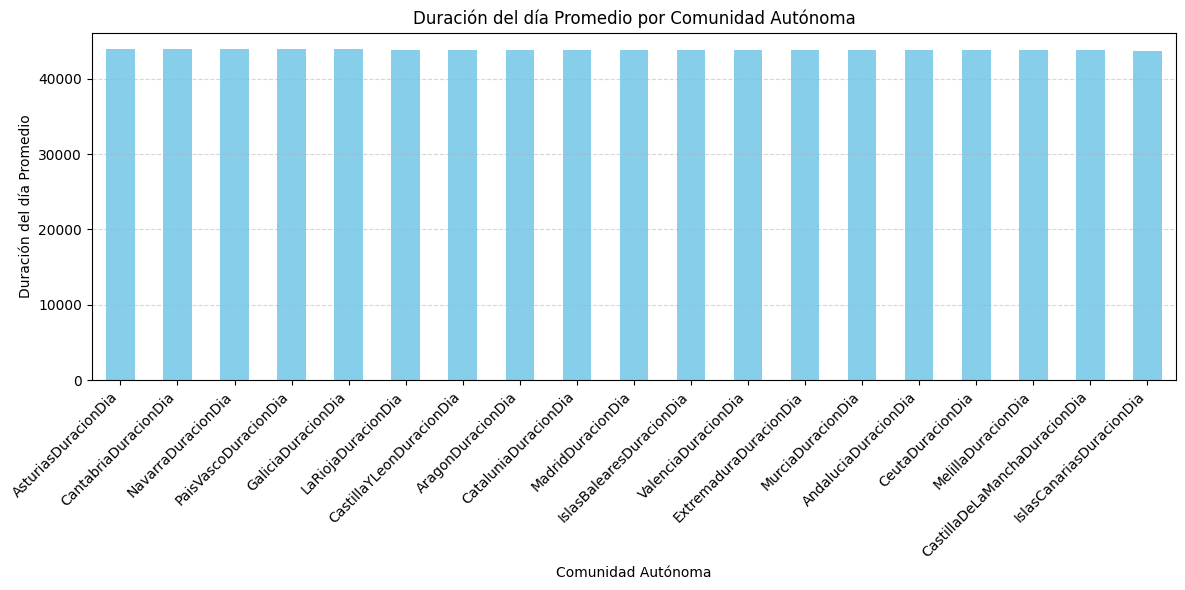

In [109]:
# Gráfico en orden de duración día
duracion_promedio = estadisticas_duradia.loc['mean']

duracion_promedio_ordenado = duracion_promedio.sort_values(ascending=False)
plt.figure(figsize=(12, 6))
duracion_promedio_ordenado.plot(kind='bar', color='skyblue')

plt.title('Duración del día Promedio por Comunidad Autónoma')
plt.xlabel('Comunidad Autónoma')
plt.ylabel('Duración del día Promedio')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

### Boxplots de duración del día

Se realizan gráficos boxplots de la duración del día de las diferentes comunidades autónomas.

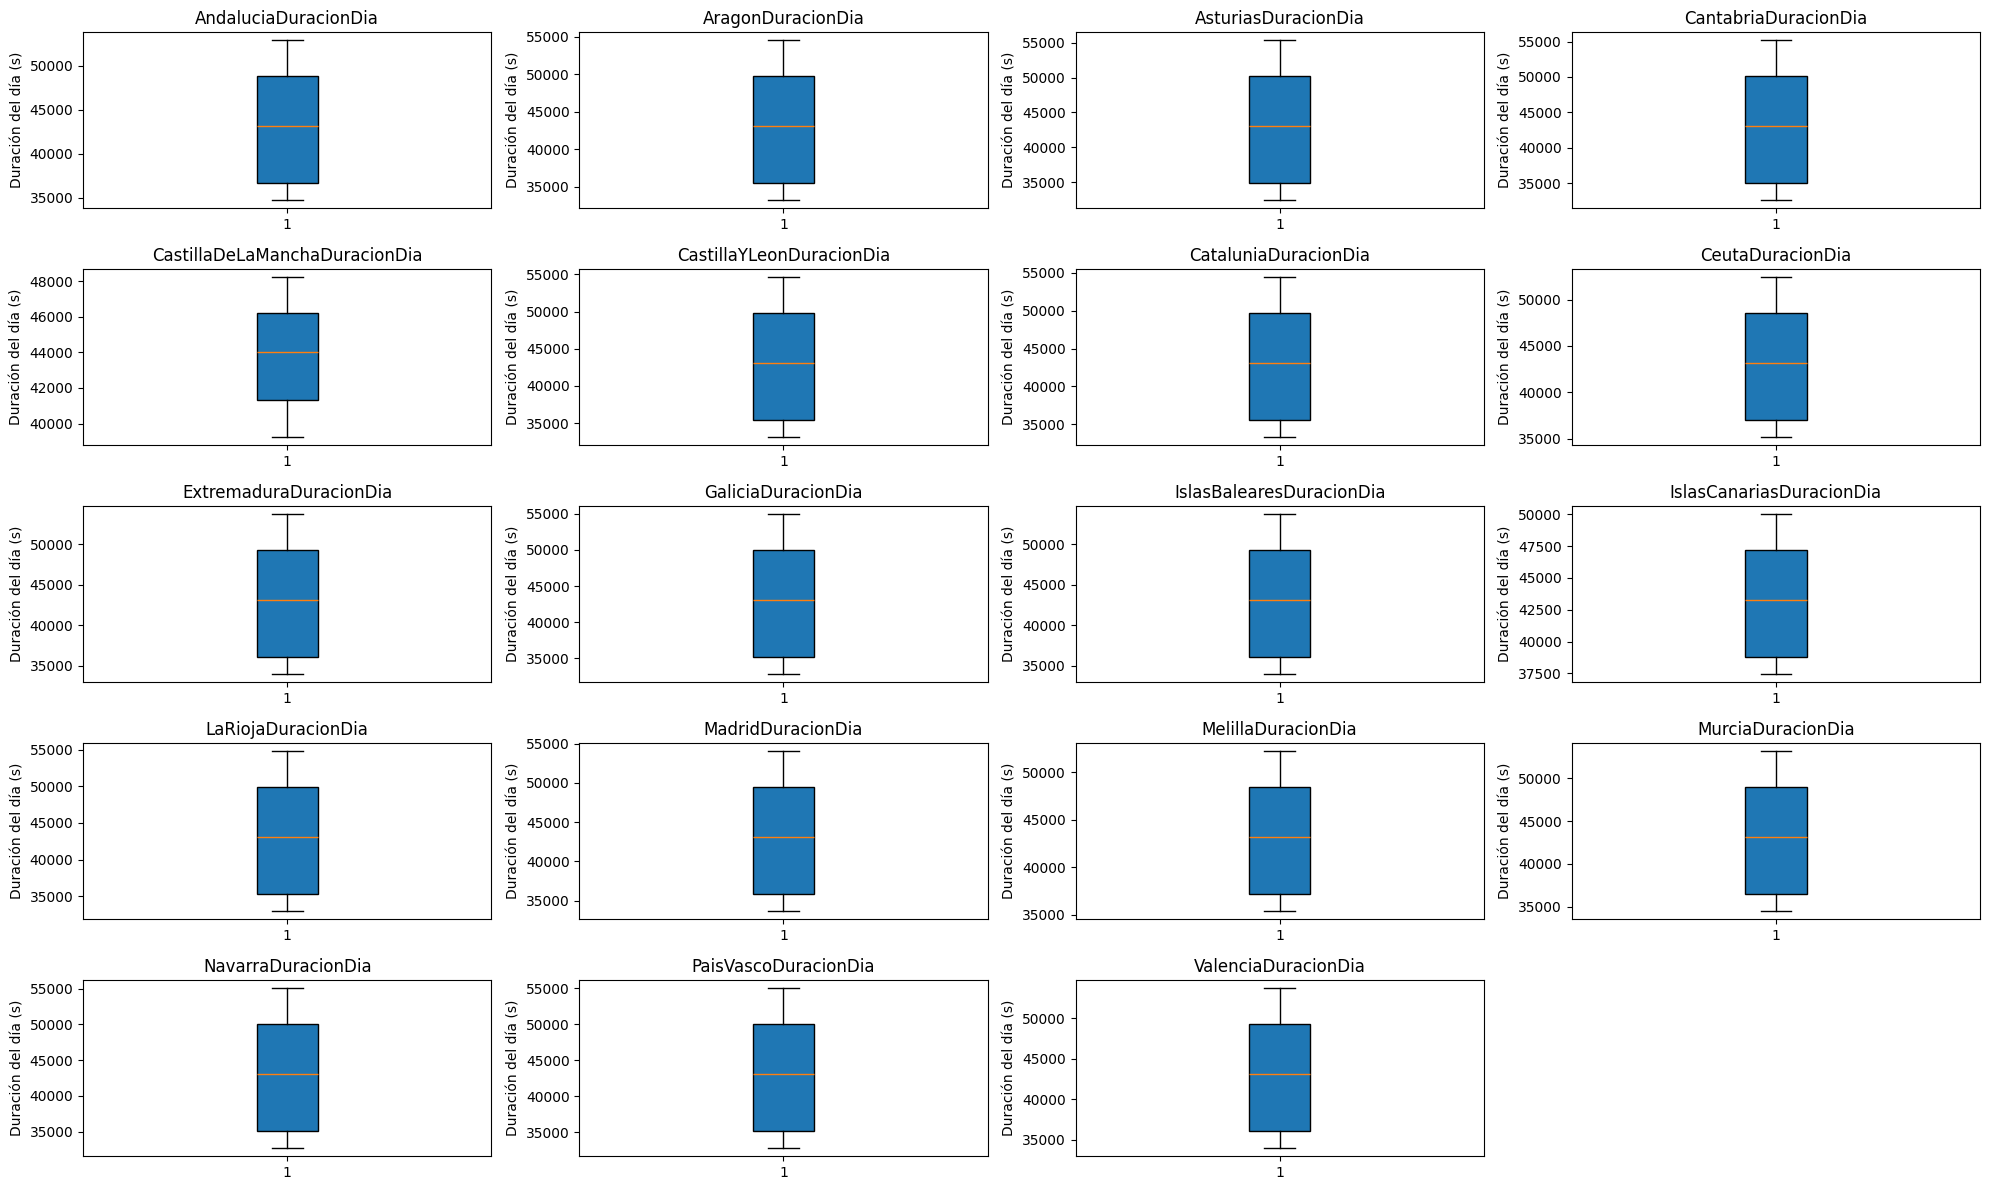

In [110]:
dura_dia_cols = [col for col in df_final.columns if 'DuracionDia' in col]

n_cols = 4
n_rows = -(-len(dura_dia_cols) // n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 12), squeeze=False)

for ax, col in zip(axs.flatten(), dura_dia_cols):
    ax.boxplot(df_final[col].dropna(), vert=True, patch_artist=True)
    ax.set_title(col)
    ax.set_ylabel('Duración del día (s)')

for ax in axs.flatten()[len(dura_dia_cols):]:
    ax.remove()

plt.tight_layout()
plt.show()


### Gráficos de líneas de duración día

Se realizan los diferentes gráficos de líneas de la duración del día para cada una de las comunidades autónomas.

In [111]:
for col in dura_dia_cols:
    fig = px.line(
        df_final_reset,
        x='Fecha',
        y=col,
        title=f'Evolución de duración del día {col} vs Tiempo',
        labels={'Fecha': 'Fecha', col: 'Duración del día (s)'}
    )
    fig.show()


### Correlación entre duración día y demanda de energía nacional

Se realiza la correlación de duración del día de cada comunidad autónoma y de la demanda de energía nacional.

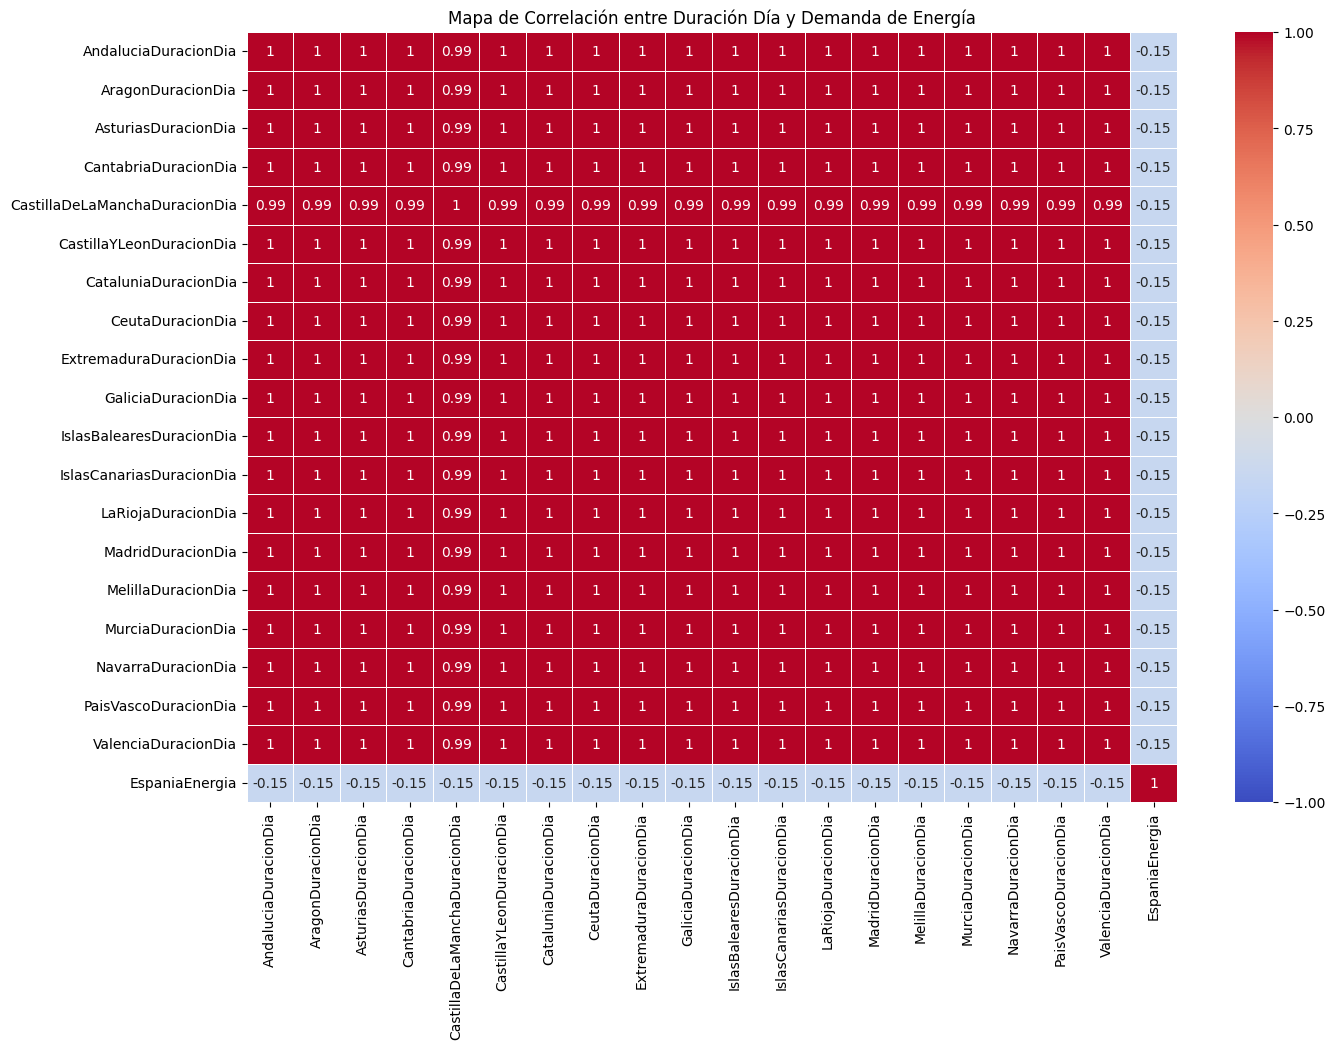

In [112]:
dura_dia_espania_energia = dura_dia_cols + ['EspaniaEnergia']

df_duradia = df_final[dura_dia_espania_energia]

plt.figure(figsize=(15, 10))
sns.heatmap(df_duradia.corr(), annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1, center=0)
plt.title('Mapa de Correlación entre Duración Día y Demanda de Energía')
plt.show()

### Gráficos de dispersión entre duración dia y demanda de energía nacional

Se realizan distintos gráficos de dispersión entre duración del día y la demanda de energía nacional.

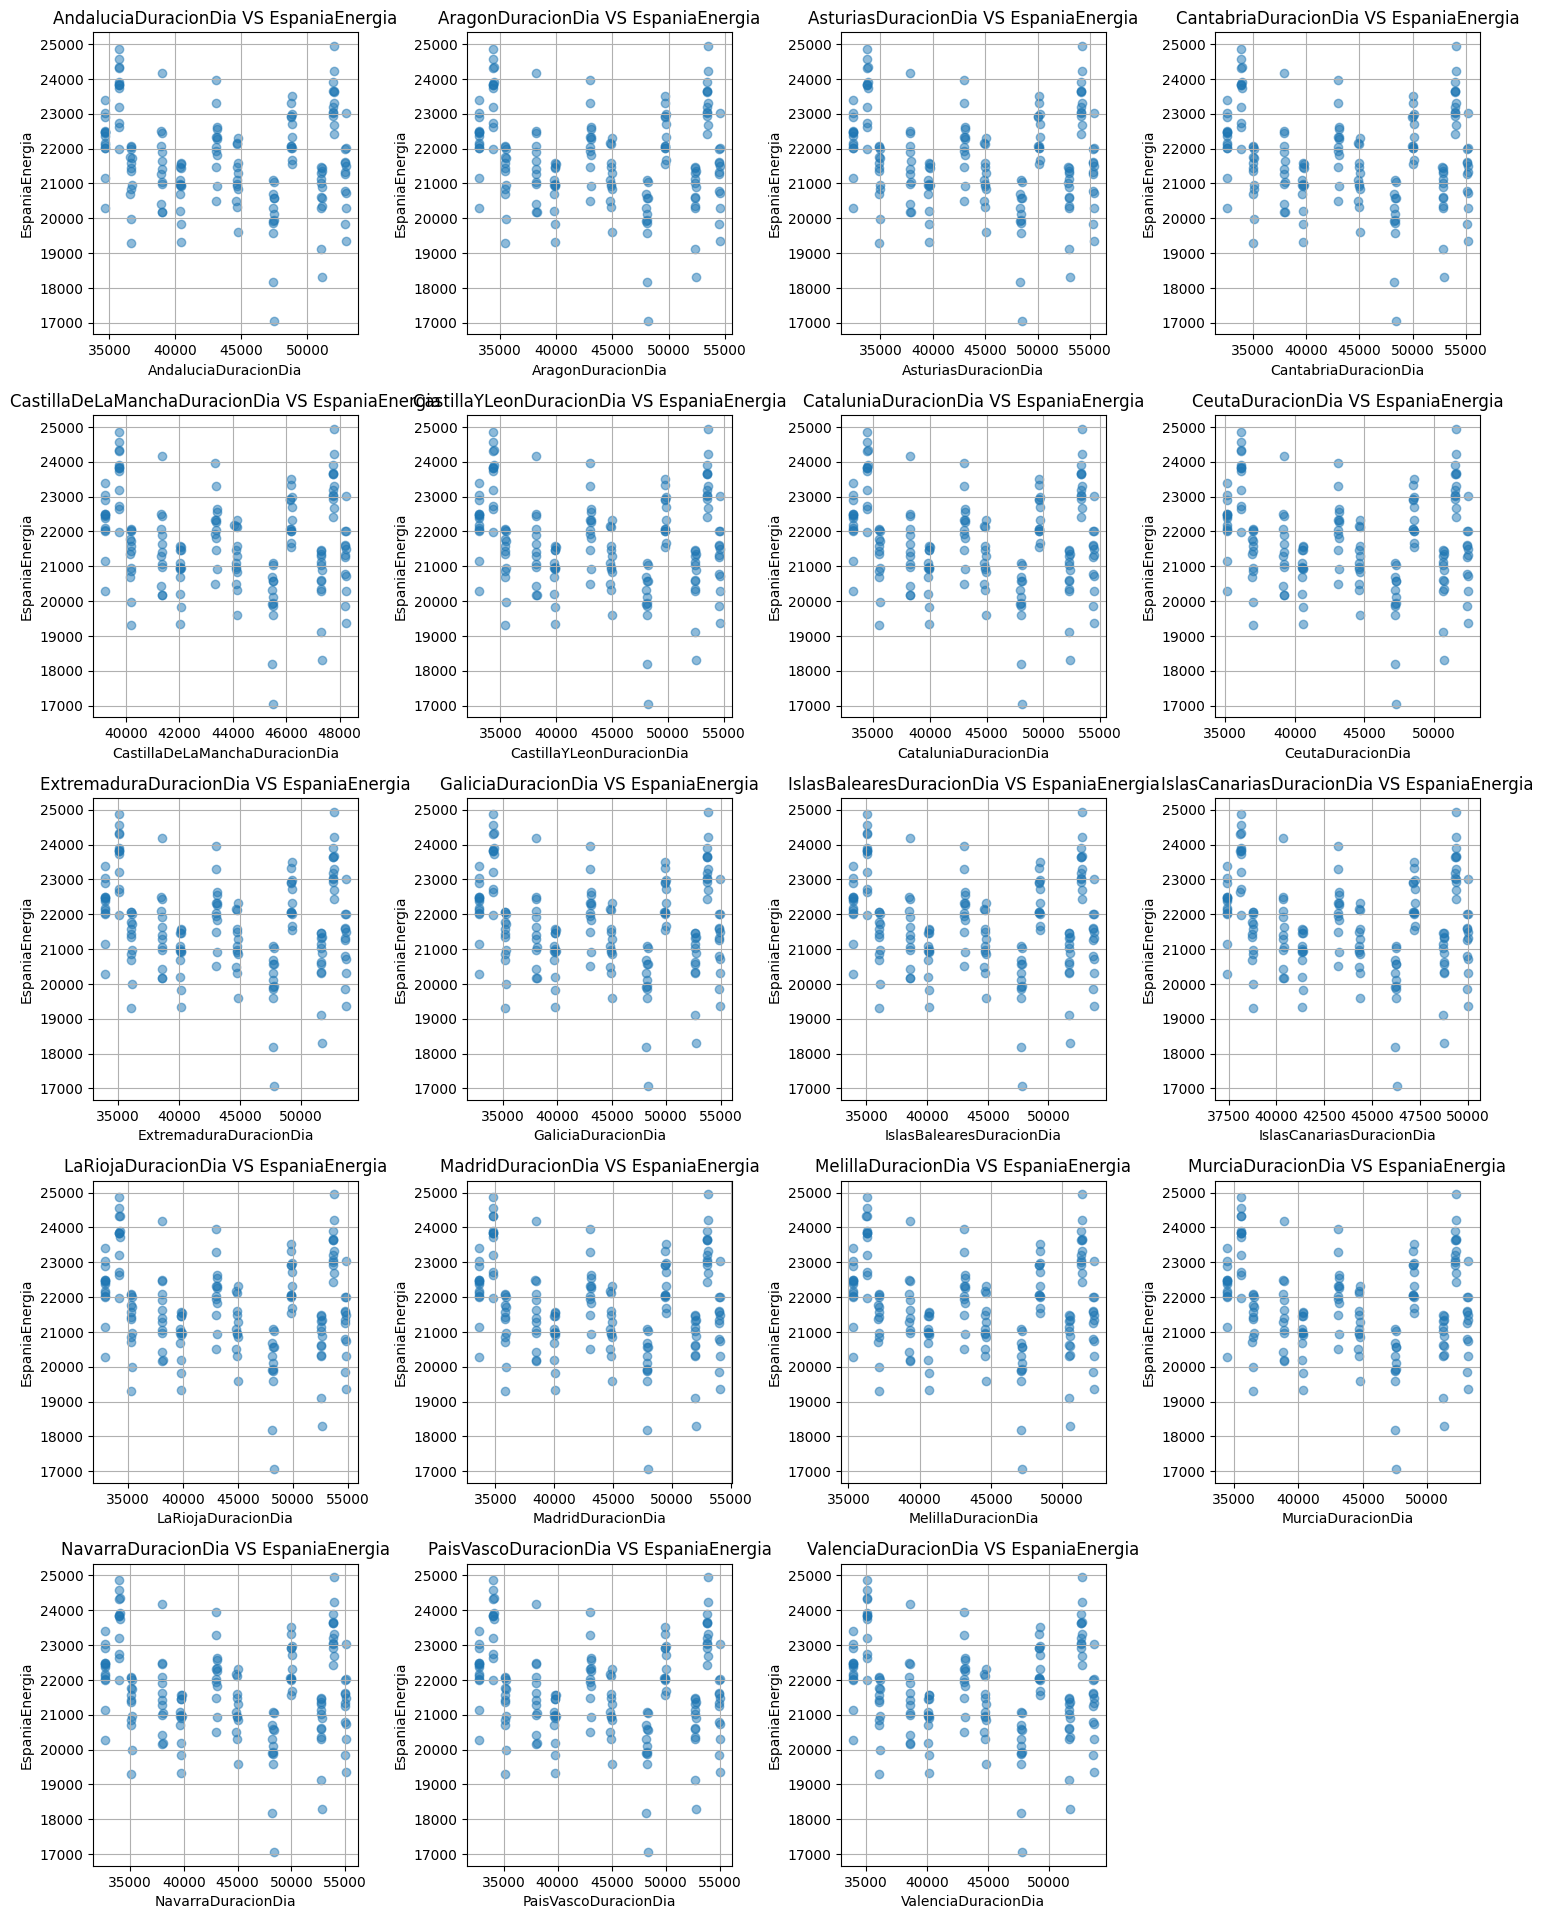

In [113]:
plt.figure(figsize=(15, len(dura_dia_cols) * 2))

for i, col in enumerate(dura_dia_cols):
    plt.subplot(len(dura_dia_cols) // 2 + 1, 4, i + 1)
    plt.scatter(df_final[col], df_final['EspaniaEnergia'], alpha=0.5)
    plt.title(f'{col} VS EspaniaEnergia')
    plt.xlabel(col)
    plt.ylabel('EspaniaEnergia')
    plt.grid(True)

plt.tight_layout()
plt.show()

## Población

### Estadísticas generales de la Población.

In [114]:
estadisticas_poblacion = df_final['Poblacion'].describe()
estadisticas_poblacion

count    1.570000e+02
mean     4.695972e+07
std      5.762329e+05
min      4.638438e+07
25%      4.649739e+07
50%      4.673626e+07
75%      4.734485e+07
max      4.863001e+07
Name: Poblacion, dtype: float64

### Boxplot de población

Se realiza un boxplot de la población de España.

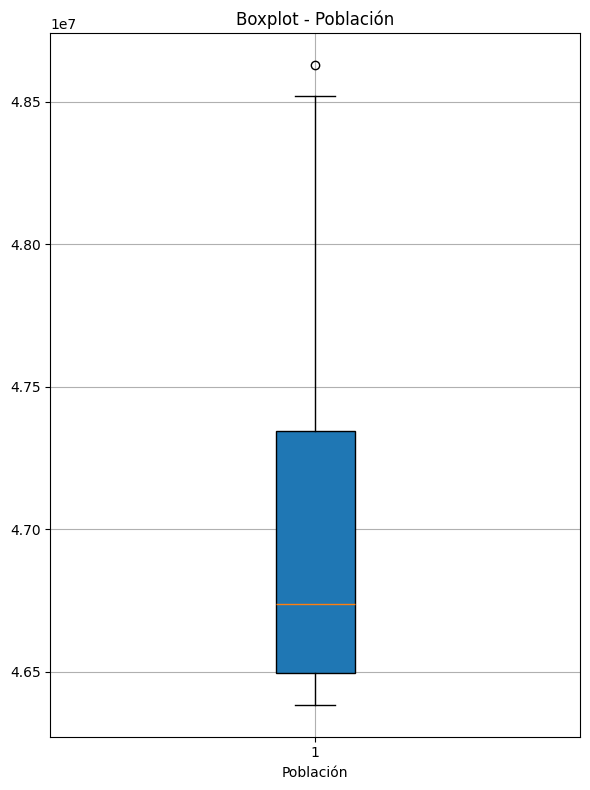

In [115]:
plt.figure(figsize=(6, 8))
plt.boxplot(df_final['Poblacion'].dropna(), patch_artist=True)
plt.title('Boxplot - Población')
plt.xlabel('Población')
plt.grid(True)
plt.tight_layout()
plt.show()


### Gráfico de líneas de población

Se realiza un gráfico de líneas de la población.

In [116]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_final_reset['Fecha'],
    y=df_final_reset['Poblacion'],
    mode='lines+markers',
    line=dict(color='blue'),
    marker=dict(size=6),
    name='Población'
))

fig.update_layout(
    title='Gráfico de Líneas - Población',
    xaxis_title='Fecha',
    yaxis_title='Población',
    xaxis=dict(showgrid=True, tickangle=45),
    yaxis=dict(showgrid=True),
    template='plotly_white'
)

# Mostrar el gráfico
fig.show()


### Correlación entre Población y demanda de energía nacional

Se realiza un gráfico de correlación entre población y la demanda de energía nacional de España.

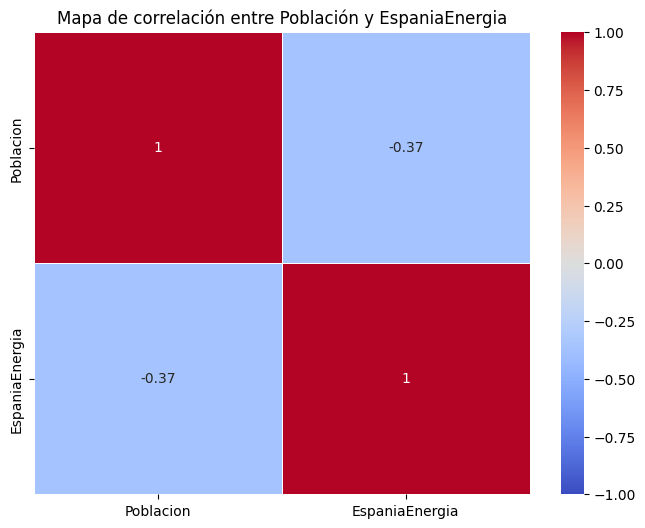

In [117]:
poblacion_espania_energia = df_final[['Poblacion', 'EspaniaEnergia']].dropna()

plt.figure(figsize=(8, 6))
sns.heatmap(poblacion_espania_energia.corr(), annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1, center=0)
plt.title('Mapa de correlación entre Población y EspaniaEnergia')
plt.show()


### Gráfico de dispersión entre población y demanda de energía nacional

Se realiza un gráfico de dispersión con un histograma de las variables población y demanda de energía nacional de España.

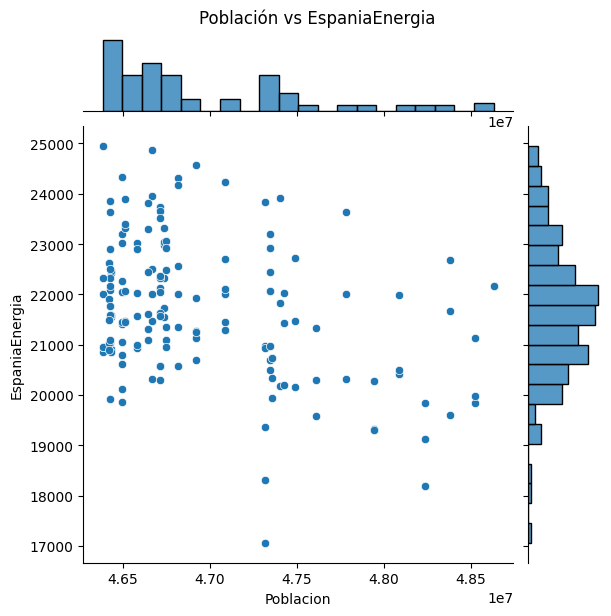

In [118]:
sns.jointplot(x='Poblacion', y='EspaniaEnergia', data=poblacion_espania_energia, kind='scatter', marginal_kws=dict(bins=20, fill=True))

plt.suptitle('Población vs EspaniaEnergia', y=1.02)

plt.show()


## PIB

### Estadísticas generales del PIB

In [119]:
estadisticas_pib = df_final['PIB'].describe()
estadisticas_pib

count    157.000000
mean       0.323738
std        3.497644
min      -17.640200
25%        0.166100
50%        0.502000
75%        0.785200
max       16.243700
Name: PIB, dtype: float64

### Boxplot de PIB

Se realiza un boxplot del PIB de España.

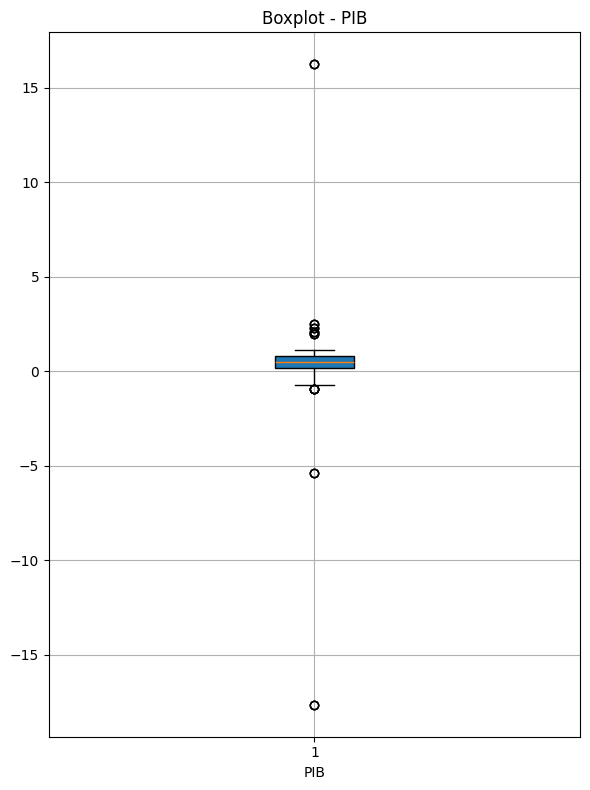

In [120]:
plt.figure(figsize=(6, 8))
plt.boxplot(df_final['PIB'].dropna(), patch_artist=True)
plt.title('Boxplot - PIB')
plt.xlabel('PIB')
plt.grid(True)
plt.tight_layout()
plt.show()


### Gráfico de líneas de PIB

Se realiza un gráfico de líneas del PIB.

In [121]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_final_reset['Fecha'],
    y=df_final_reset['PIB'],
    mode='lines+markers',
    line=dict(color='blue'),
    marker=dict(size=6),
    name='PIB'
))

fig.update_layout(
    title='Gráfico de Líneas Interactivo - PIB',
    xaxis_title='Fecha',
    yaxis_title='PIB',
    xaxis=dict(showgrid=True, tickangle=45),
    yaxis=dict(showgrid=True),
    template='plotly_white'
)

fig.show()


### Correlación entre PIB y demanda de energía nacional

Se realiza un gráfico de correlación entre el PIB y la demanda de energía nacional de España.

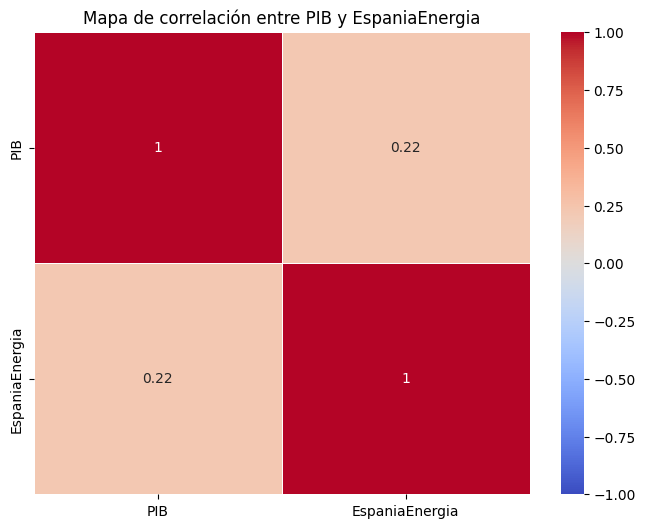

In [122]:
pib_espania_energia = df_final[['PIB', 'EspaniaEnergia']].dropna()

plt.figure(figsize=(8, 6))
sns.heatmap(pib_espania_energia.corr(), annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1, center=0)
plt.title('Mapa de correlación entre PIB y EspaniaEnergia')
plt.show()

### Gráfico de dispersión entre PIB y demanda de energía nacional

Se realiza un gráfico de dispersión con un histograma de las variables PIB y demanda de energía nacional de España.

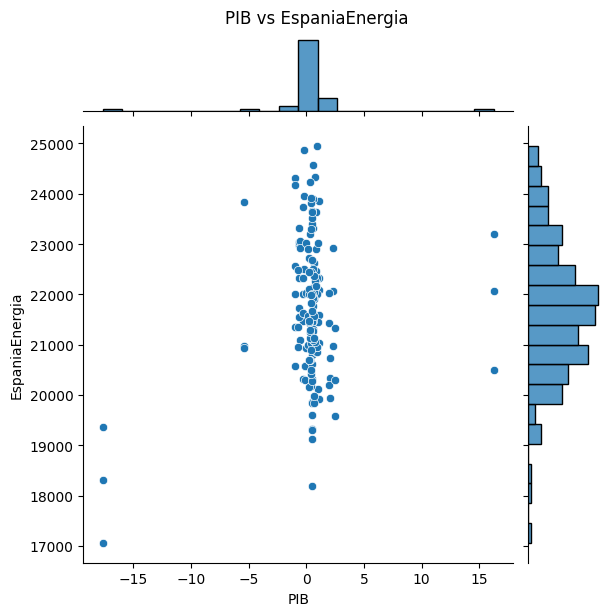

In [123]:
sns.jointplot(x='PIB', y='EspaniaEnergia', data=pib_espania_energia, kind='scatter', marginal_kws=dict(bins=20, fill=True))

plt.suptitle('PIB vs EspaniaEnergia', y=1.02)

plt.show()

# Transformación

## Selección de características

In [124]:
# se realiza una copia de df_final

df_sincorr = df_final.copy()

In [125]:
comunidades_a_conservar = ['Madrid']

df_sincorr = df_sincorr.drop(columns=[col for col in df_sincorr.columns
                                  if 'DuracionDia' in col and
                                  not any(comunidad in col for comunidad in comunidades_a_conservar)])

In [126]:
df_sincorr = df_sincorr.drop(columns=['ExtremaduraTemperaturaMax', 'PaisVascoTemperaturaMax', 'CastillaYLeonTemperaturaMax'])

In [127]:
df_sincorr = df_sincorr.drop(columns=['PaisVascoTemperaturaMin'])

Se opta por realizar un análisis de correlación entre todas las variables del dataset.

In [128]:
matriz_corr_general = df_sincorr.corr()

matriz_corr_general.head()

AndaluciaEnergia  AragonEnergia  AsturiasEnergia  \
AndaluciaEnergia                   1.000000       0.636753         0.140377   
AragonEnergia                      0.636753       1.000000         0.499084   
AsturiasEnergia                    0.140377       0.499084         1.000000   
CantabriaEnergia                   0.064960       0.456478         0.758661   
CastillaDeLaManchaEnergia          0.887559       0.663968         0.191023   

                           CantabriaEnergia  CastillaDeLaManchaEnergia  \
AndaluciaEnergia                   0.064960                   0.887559   
AragonEnergia                      0.456478                   0.663968   
AsturiasEnergia                    0.758661                   0.191023   
CantabriaEnergia                   1.000000                   0.130625   
CastillaDeLaManchaEnergia          0.130625                   1.000000   

                           CastillaYLeonEnergia  CataluniaEnergia  \
AndaluciaEnergia                       0.623593          0.771674   
AragonEnergia                          0.835812          0.788088   
AsturiasEnergia                        0.608372          0.543358   
CantabriaEnergia                       0.381558          0.399381   
CastillaDeLaManchaEnergia              0.681510          0.732369   

                           CeutaEnergia  EspaniaEnergia  ExtremaduraEnergia  \
AndaluciaEnergia               0.687781        0.825252            0.912309   
AragonEnergia                  0.524573        0.833898            0.595716   
AsturiasEnergia                0.378422        0.600854            0.126006   
CantabriaEnergia               0.356477        0.448216            0.070683   
CastillaDeLaManchaEnergia      0.549458        0.803941            0.777207   

                           ...  IslasCanariasTemperaturaMin  \
AndaluciaEnergia           ...                     0.208515   
AragonEnergia              ...                    -0.204822   
AsturiasEnergia            ...                    -0.232257   
CantabriaEnergia           ...                     0.035762   
CastillaDeLaManchaEnergia  ...                     0.021105   

                           LaRiojaTemperaturaMin  MadridTemperaturaMin  \
AndaluciaEnergia                        0.258914              0.290135   
AragonEnergia                          -0.132249             -0.087659   
AsturiasEnergia                        -0.466007             -0.412008   
CantabriaEnergia                       -0.172214             -0.107090   
CastillaDeLaManchaEnergia               0.093630              0.148880   

                           MelillaTemperaturaMin  MurciaTemperaturaMin  \
AndaluciaEnergia                        0.297812              0.276661   
AragonEnergia                          -0.116887             -0.108565   
AsturiasEnergia                        -0.461568             -0.456168   
CantabriaEnergia                       -0.158053             -0.150640   
CastillaDeLaManchaEnergia               0.105460              0.105583   

                           NavarraTemperaturaMin  ValenciaTemperaturaMin  \
AndaluciaEnergia                        0.237919                0.270284   
AragonEnergia                          -0.132233               -0.116422   
AsturiasEnergia                        -0.434349               -0.388170   
CantabriaEnergia                       -0.130135               -0.086144   
CastillaDeLaManchaEnergia               0.074510                0.105148   

                           MadridDuracionDia  Poblacion       PIB  
AndaluciaEnergia                    0.054333  -0.012278  0.264178  
AragonEnergia                      -0.113997  -0.322928  0.241973  
AsturiasEnergia                    -0.287466  -0.766964  0.003373  
CantabriaEnergia                    0.015374  -0.775946  0.077615  
CastillaDeLaManchaEnergia           0.078569   0.003337  0.187404  

[5 rows x 57 columns]

Se revisa si existen correlaciones de 1 o -1 en toda la matriz

In [129]:
correlation_matrix = df_sincorr.corr()

np.fill_diagonal(matriz_corr_general.values, np.nan)

filtro_corr_altas = matriz_corr_general[(matriz_corr_general == 1) | (matriz_corr_general == -1)]

filtro_corr_altas = filtro_corr_altas.stack().reset_index()
filtro_corr_altas.columns = ['Variable 1', 'Variable 2', 'Correlation']

unique_filtered_df = filtro_corr_altas[filtro_corr_altas['Variable 1'] != filtro_corr_altas['Variable 2']]

unique_filtered_df


Empty DataFrame
Columns: [Variable 1, Variable 2, Correlation]
Index: []

No hay correlaciones ya de 1 o - 1 entre las variables por lo que por el moento no se opta por eliminar más características del Dataframe.

## Generación de nuevas características

In [130]:
# Generación de columna mes
df_sincorr = df_sincorr.reset_index()
df_sincorr['Mes'] = df_sincorr['Fecha'].dt.month


# Generación de columnas con las diferentes estaciones
def get_estacion(mes):
    if mes in [12, 1, 2]:
        return 'Invierno'
    elif mes in [3, 4, 5]:
        return 'Primavera'
    elif mes in [6, 7, 8]:
        return 'Verano'
    else:
        return 'Otoño'

df_sincorr['Estacion'] = df_sincorr['Mes'].apply(get_estacion)

In [131]:
# se realiza One hot encoding
df_sincorr = pd.get_dummies(df_sincorr, columns=['Estacion'], drop_first=True)

In [132]:
# Crear promedios móviles usando diferentes ventanas
df_sincorr['Demanda_Media3'] = df_sincorr['EspaniaEnergia'].rolling(window=3, min_periods=1).mean()
df_sincorr['Demanda_Media6'] = df_sincorr['EspaniaEnergia'].rolling(window=6, min_periods=1).mean()
df_sincorr['Demanda_Media12'] = df_sincorr['EspaniaEnergia'].rolling(window=12, min_periods=1).mean()

# Crear una media acumulativa que expande a medida que avanzan los datos
df_sincorr['Demanda_Media_Expanding'] = df_sincorr['EspaniaEnergia'].expanding().mean()

In [133]:
df_sincorr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 66 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Fecha                             157 non-null    datetime64[ns]
 1   AndaluciaEnergia                  157 non-null    float64       
 2   AragonEnergia                     157 non-null    float64       
 3   AsturiasEnergia                   157 non-null    float64       
 4   CantabriaEnergia                  157 non-null    float64       
 5   CastillaDeLaManchaEnergia         157 non-null    float64       
 6   CastillaYLeonEnergia              157 non-null    float64       
 7   CataluniaEnergia                  157 non-null    float64       
 8   CeutaEnergia                      157 non-null    float64       
 9   EspaniaEnergia                    157 non-null    float64       
 10  ExtremaduraEnergia                157 non-null    

In [134]:
df_sincorr

Fecha  AndaluciaEnergia  AragonEnergia  AsturiasEnergia  \
0   2011-01-01       3611.370158     956.500295      1020.147744   
1   2011-02-01       3206.557695     872.527978       920.399066   
2   2011-03-01       3363.760649     942.539985       986.152384   
3   2011-04-01       2902.823703     825.725543       881.845117   
4   2011-05-01       2988.726944     874.732192       910.096249   
..         ...               ...            ...              ...   
152 2023-09-01       3006.602444     765.643217       664.492400   
153 2023-10-01       3003.718883     767.601167       697.903882   
154 2023-11-01       2981.726852     788.203623       707.637896   
155 2023-12-01       3421.974695     790.003599       741.593527   
156 2024-01-01       3453.378827     848.686060       775.794512   

     CantabriaEnergia  CastillaDeLaManchaEnergia  CastillaYLeonEnergia  \
0          394.458733                1151.079404           1308.023490   
1          366.574242                1039.329384           1189.416356   
2          402.782196                1092.285257           1264.476681   
3          361.935178                 895.004912           1039.440167   
4          379.054143                 942.660376           1106.830540   
..                ...                        ...                   ...   
152        285.815691                 881.309115           1002.483013   
153        296.378489                 884.290549           1060.383098   
154        306.606421                 942.604793           1126.147200   
155        276.812956                1043.730568           1153.652620   
156        310.049228                1040.760144           1201.844588   

     CataluniaEnergia  CeutaEnergia  EspaniaEnergia  ...   Poblacion     PIB  \
0         4342.582019     16.753994    24865.971404  ...  46667175.0 -0.1500   
1         3908.142365     15.248486    22494.540055  ...  46667175.0 -0.1500   
2         4218.751172     16.429358    23960.347443  ...  46667175.0 -0.1500   
3         3592.544226     14.974756    20308.197362  ...  46667175.0 -0.3105   
4         3886.563827     16.125928    21474.032006  ...  46667175.0 -0.3105   
..                ...           ...             ...  ...         ...     ...   
152       3617.954842     15.704710    19596.284758  ...  48382506.0  0.5067   
153       3604.422609     15.703419    19833.832527  ...  48522035.0  0.7148   
154       3546.276030     14.661887    19983.539977  ...  48522035.0  0.7148   
155       3665.698858     15.417852    21141.967169  ...  48522035.0  0.7148   
156       3969.654188     15.936548    22172.444796  ...  48630010.0  0.8330   

     Mes  Estacion_Otoño  Estacion_Primavera  Estacion_Verano  Demanda_Media3  \
0      1           False               False            False    24865.971404   
1      2           False               False            False    23680.255730   
2      3           False                True            False    23773.619634   
3      4           False                True            False    22254.361620   
4      5           False                True            False    21914.192270   
..   ...             ...                 ...              ...             ...   
152    9            True               False            False    21318.556214   
153   10            True               False            False    20368.411309   
154   11            True               False            False    19804.552421   
155   12           False               False            False    20319.779891   
156    1           False               False            False    21099.317314   

     Demanda_Media6  Demanda_Media12  Demanda_Media_Expanding  
0      24865.971404     24865.971404             24865.971404  
1      23680.255730     23680.255730             23680.255730  
2      23773.619634     23773.619634             23773.619634  
3      22907.264066     22907.264066             22907.264066  
4      22620.617654     22620.617654             

## División del DataFrame en train y test

> Agregar bloque entrecomillado



In [135]:
# Se realiza una copia del dataset

df_final_limpio = df_sincorr.copy()

In [136]:
df_final_limpio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 66 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Fecha                             157 non-null    datetime64[ns]
 1   AndaluciaEnergia                  157 non-null    float64       
 2   AragonEnergia                     157 non-null    float64       
 3   AsturiasEnergia                   157 non-null    float64       
 4   CantabriaEnergia                  157 non-null    float64       
 5   CastillaDeLaManchaEnergia         157 non-null    float64       
 6   CastillaYLeonEnergia              157 non-null    float64       
 7   CataluniaEnergia                  157 non-null    float64       
 8   CeutaEnergia                      157 non-null    float64       
 9   EspaniaEnergia                    157 non-null    float64       
 10  ExtremaduraEnergia                157 non-null    

In [137]:
df_final_limpio.set_index('Fecha', inplace=True)

Se hace la división del dataset en train y test. Se toma 70% para datos de entrenamiento y 30% para datos de prueba.

<Figure size 1500x800 with 0 Axes>

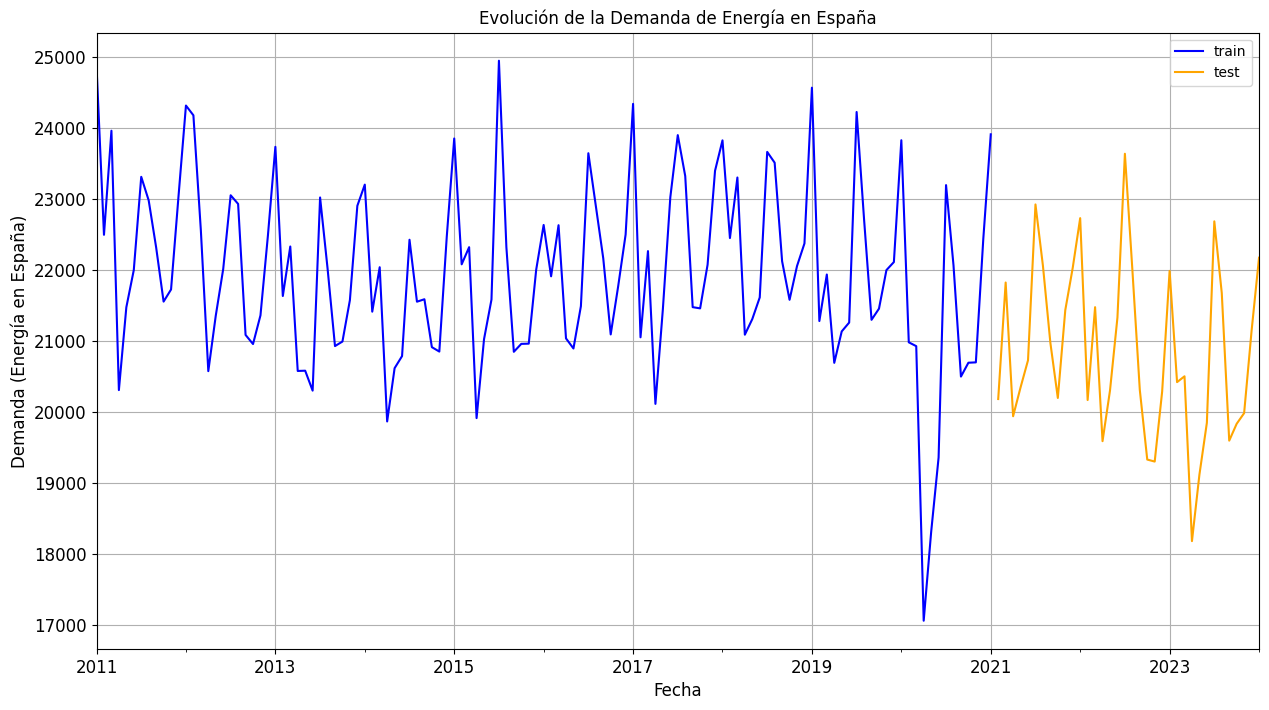

In [138]:
train = df_final_limpio.loc['2011-01-01':'2021-01-31']
test = df_final_limpio.loc['2021-02-01':]


train_test_combinados = train.rename(columns={'EspaniaEnergia': 'train'}) \
    .join(test.rename(columns={'EspaniaEnergia': 'test'}), how='outer', rsuffix='_test')

plt.figure(figsize=(15, 8))
train_test_combinados.plot(y=['train', 'test'], figsize=(15, 8), fontsize=12, color=['blue', 'orange'])
plt.title("Evolución de la Demanda de Energía en España")
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Demanda (Energía en España)', fontsize=12)
plt.grid(True)
plt.show()

# Minería de Datos y Evaluación

## Randomforest

In [139]:
train.reset_index(drop = True, inplace = True)

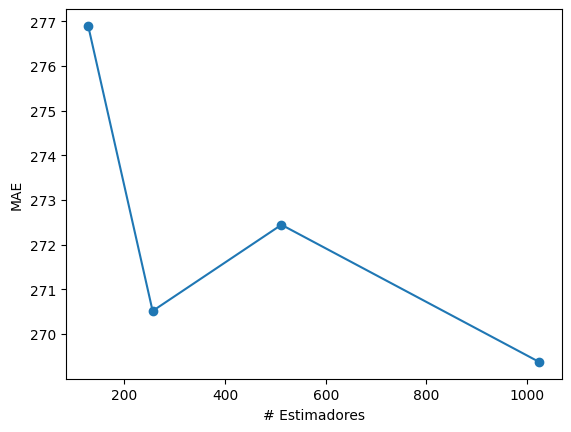

In [140]:
cv = TimeSeriesSplit()
l_estimators = [128, 256, 512, 1024]#, 2, 4, 8, 16, 32, 64,]

total_scores = []
for estimators in l_estimators:
   fold_accuracy = []
   regressor =  RandomForestRegressor(n_estimators= estimators,
                  criterion='absolute_error', random_state=0)
   for train_fold, test_fold in cv.split(train):
      # División train test aleatoria
      f_train = train.loc[train_fold]
      f_test = train.loc[test_fold]
      # entrenamiento y ejecución del modelo
      regressor.fit( X = f_train.drop(['EspaniaEnergia'], axis=1),
                           y = f_train['EspaniaEnergia'])
      y_pred = regressor.predict(X = f_test.drop(['EspaniaEnergia'], axis = 1))
      # evaluación del modelo
      mae = mean_absolute_error(f_test['EspaniaEnergia'], y_pred)
      fold_accuracy.append(mae)
   total_scores.append(sum(fold_accuracy)/len(fold_accuracy))


plt.plot(l_estimators, total_scores, marker='o')
plt.ylabel('MAE')
plt.xlabel('# Estimadores')
plt.show()


In [141]:
best_est = l_estimators[np.argmin(total_scores)]
best_mae = min(total_scores)
print ("Min Value (estimators = %i, MAE = %6.2f)"  % (best_est, best_mae))

Min Value (estimators = 1024, MAE = 269.38)


In [142]:
# Modelo
RF =  RandomForestRegressor(n_estimators= best_est, criterion='absolute_error',
                                   random_state=0)
# Predicción
RF.fit( X = train.drop(['EspaniaEnergia'], axis=1), y = train['EspaniaEnergia'])
y_pred = RF.predict(X = test.drop(['EspaniaEnergia'], axis = 1))

In [143]:
# Cálculo de errores de las predicciones
mae = mean_absolute_error(test['EspaniaEnergia'], y_pred)
print ('MAE', mae)
mape = mean_absolute_percentage_error(test['EspaniaEnergia'], y_pred) * 100
print(f"MAPE: {mape:.2f}%")
rmse = np.sqrt(mean_squared_error(test['EspaniaEnergia'], y_pred))
print(f"RMSE: {rmse:.2f}")

MAE 288.8418261536959
MAPE: 1.38%
RMSE: 380.84


In [146]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 65 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   AndaluciaEnergia                  121 non-null    float64
 1   AragonEnergia                     121 non-null    float64
 2   AsturiasEnergia                   121 non-null    float64
 3   CantabriaEnergia                  121 non-null    float64
 4   CastillaDeLaManchaEnergia         121 non-null    float64
 5   CastillaYLeonEnergia              121 non-null    float64
 6   CataluniaEnergia                  121 non-null    float64
 7   CeutaEnergia                      121 non-null    float64
 8   EspaniaEnergia                    121 non-null    float64
 9   ExtremaduraEnergia                121 non-null    float64
 10  GaliciaEnergia                    121 non-null    float64
 11  IslasBalearesEnergia              121 non-null    float64
 12  IslasCan

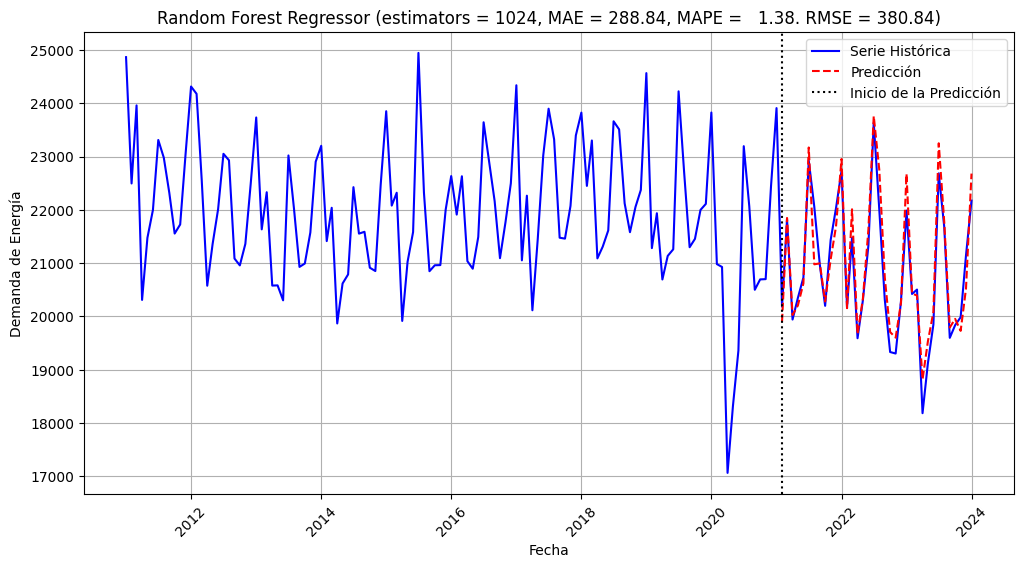

In [153]:
# Gráfico del mejor modelo: RF
train = df_final_limpio.loc['2011-01-01':'2021-01-31']
test = df_final_limpio.loc['2021-02-01':]

unir_datos = pd.concat([train['EspaniaEnergia'], test['EspaniaEnergia']])
fechas = unir_datos.index

fechas_pred = test.index

plt.figure(figsize=(12, 6))
plt.plot(fechas, unir_datos, c='b', label='Serie Histórica')
plt.plot(fechas_pred, y_pred, c='r', linestyle='--', label='Predicción')
plt.axvline(x=fechas[len(train)], color='k', linestyle=':', label='Inicio de la Predicción')
plt.xticks(rotation=45)
plt.axis('tight')
plt.legend()
plt.title("Random Forest Regressor (estimators = %i, MAE = %6.2f, MAPE = %6.2f. RMSE = %6.2f)" % (best_est, mae, mape, rmse))

plt.xlabel("Fecha")
plt.ylabel("Demanda de Energía")
plt.grid(True)
plt.show()

#### Random y Grid Search

In [154]:
# Modelo
regressor = RandomForestRegressor(random_state=0)

In [155]:
# Parámetros a analizar:
param_dist = {"n_estimators": [980, 1024, 1200], # Número de árboles.
              "max_features": [1.0, 'sqrt'], # Números de características a considerar en cada separación del dataset.
              "max_depth": [16, 12,8,4, 2,None], # Numero máximo de niveles en cada árbol.
              "min_samples_split": sp_randint(2, 50), #  Número mínimo de muestras requeridas para separar un nodo.
              "min_samples_leaf": sp_randint(1, 50), # Npumero mínimo de muestras requeridas para cada nodo de hoja.
              "bootstrap": [True, False], # Método de selcción de muestras para cada árbol.
              "criterion": ["squared_error", "absolute_error"]}

In [156]:
# Buscar los mejores parámetros del modelo
RF_rns = RandomizedSearchCV(estimator = regressor, param_distributions = param_dist,
                               n_iter = 100, cv = TimeSeriesSplit(), random_state=0, n_jobs = -1)


RF_rns.fit( X = train.drop(['EspaniaEnergia'], axis=1), y = train['EspaniaEnergia'])

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(random_state=0), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'max_depth': [16, 12, 8, 4, 2, None],
                                        'max_features': [1.0, 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe733276560>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe733275a50>,
                                        'n_estimators': [980, 1024, 1200]},
                   random_state=0)

In [157]:
# Función para mostrar los mejores parámetros
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [158]:
report(RF_rns.cv_results_, n_top = 5)

Model with rank: 1
Mean validation score: 0.817 (std: 0.145)
Parameters: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 16, 'max_features': 1.0, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 980}

Model with rank: 2
Mean validation score: 0.811 (std: 0.124)
Parameters: {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': None, 'max_features': 1.0, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1024}

Model with rank: 3
Mean validation score: 0.802 (std: 0.133)
Parameters: {'bootstrap': False, 'criterion': 'absolute_error', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 1200}

Model with rank: 4
Mean validation score: 0.744 (std: 0.164)
Parameters: {'bootstrap': False, 'criterion': 'absolute_error', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 18, 'n_estimators': 980}

Model with rank: 5
Mean validation score: 0.730 (std: 0.136)
P

In [159]:
RF_rns.best_params_

{'bootstrap': True,
 'criterion': 'squared_error',
 'max_depth': 16,
 'max_features': 1.0,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 980}

In [163]:
# Parámetros a analizar para Grid Search
param_dist = {
    "n_estimators": [800, 980, 1024],  # Número de árboles.
    "max_features": [1.0],  # Número de características a considerar en cada separación del dataset.
    "max_depth": [18, 16, 12, 4, None],  # Número máximo de niveles en cada árbol.
    "min_samples_split": [6, 10, 20],  # Número mínimo de muestras requeridas para separar un nodo.
    "min_samples_leaf": [2, 4, 8],  # Número mínimo de muestras requeridas para cada nodo de hoja.
    "bootstrap": [True]  # Método de selección de muestras para cada árbol.
}

In [164]:
# Buscar los mejores parámetros del modelo
RF_rnsgs = GridSearchCV(estimator = regressor, param_grid= param_dist, cv=TimeSeriesSplit())

RF_rnsgs.fit(X = train.drop(['EspaniaEnergia'], axis=1), y = train['EspaniaEnergia'])

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=0),
             param_grid={'bootstrap': [True],
                         'max_depth': [18, 16, 12, 4, None],
                         'max_features': [1.0], 'min_samples_leaf': [2, 4, 8],
                         'min_samples_split': [6, 10, 20],
                         'n_estimators': [800, 980, 1024]})

In [165]:
report(RF_rnsgs.cv_results_, n_top = 5)

Model with rank: 1
Mean validation score: 0.871 (std: 0.086)
Parameters: {'bootstrap': True, 'max_depth': 18, 'max_features': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 980}

Model with rank: 1
Mean validation score: 0.871 (std: 0.086)
Parameters: {'bootstrap': True, 'max_depth': 16, 'max_features': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 980}

Model with rank: 1
Mean validation score: 0.871 (std: 0.086)
Parameters: {'bootstrap': True, 'max_depth': 12, 'max_features': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 980}

Model with rank: 1
Mean validation score: 0.871 (std: 0.086)
Parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 980}

Model with rank: 5
Mean validation score: 0.871 (std: 0.086)
Parameters: {'bootstrap': True, 'max_depth': 18, 'max_features': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 1024

In [166]:
RF_rnsgs.best_estimator_

RandomForestRegressor(max_depth=18, min_samples_leaf=2, min_samples_split=6,
                      n_estimators=980, random_state=0)

In [167]:
RF_rnsgs.best_params_

{'bootstrap': True,
 'max_depth': 18,
 'max_features': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 980}

In [168]:
# Predicciones con los mejores parámetros encontrados
RF_rnsgs = RF_rnsgs.best_estimator_

RF_rnsgs.fit(X = train.drop(['EspaniaEnergia'], axis=1), y = train['EspaniaEnergia'])
y_pred = RF_rnsgs.predict(X = test.drop(['EspaniaEnergia'], axis = 1))


In [169]:
# Cálculo de errores de las predicciones
mae = mean_absolute_error(test['EspaniaEnergia'], y_pred)
print ('MAE', mae)
mape = mean_absolute_percentage_error(test['EspaniaEnergia'], y_pred) * 100
print(f"MAPE: {mape:.2f}%")
rmse = np.sqrt(mean_squared_error(test['EspaniaEnergia'], y_pred))
print(f"RMSE: {rmse:.2f}")

MAE 291.91709745853973
MAPE: 1.39%
RMSE: 385.02


In [170]:
# Características más relevantes de RF

caracteristicas = train.drop(['EspaniaEnergia'], axis=1).columns

caracteristicas_relevantes = pd.DataFrame({
    'Attributes': caracteristicas,
    'Random Forest': RF.feature_importances_
})
caracteristicas_relevantes = caracteristicas_relevantes.sort_values(by='Random Forest', ascending=False)

caracteristicas_relevantes.head(20)

Attributes  Random Forest
6            CataluniaEnergia       0.603737
0            AndaluciaEnergia       0.059639
18            ValenciaEnergia       0.054939
4   CastillaDeLaManchaEnergia       0.038312
5        CastillaYLeonEnergia       0.028129
12             LaRiojaEnergia       0.019371
1               AragonEnergia       0.019369
13              MadridEnergia       0.013482
8          ExtremaduraEnergia       0.009538
10       IslasBalearesEnergia       0.008149
9              GaliciaEnergia       0.007339
2             AsturiasEnergia       0.007176
60             Demanda_Media3       0.006610
16             NavarraEnergia       0.005696
54                  Poblacion       0.005351
17           PaisVascoEnergia       0.005120
3            CantabriaEnergia       0.005114
7                CeutaEnergia       0.004877
55                        PIB       0.004532
15              MurciaEnergia       0.004226

## Regression support vector machine (SVR)

In [171]:
X_train = train.drop(['EspaniaEnergia'], axis=1)
y_train = train['EspaniaEnergia']
X_test = test.drop(['EspaniaEnergia'], axis=1)
y_test = test['EspaniaEnergia']

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

In [172]:
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [1, 10, 100, 500],
    'gamma': ['scale', 0.01, 0.1, 1],
    'epsilon': [0.001, 0.01, 0.1],
    'degree': [2, 3, 4]  # Solo para Kernel "poly"
}

# Configurar la búsqueda de hiperparámetros con Grid Search
grid_search = GridSearchCV(
    estimator=SVR(),
    param_grid=param_grid,
    cv=TimeSeriesSplit(),
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train_scaled)

print("Mejores parámetros encontrados:", grid_search.best_params_)

Mejores parámetros encontrados: {'C': 1, 'degree': 2, 'epsilon': 0.001, 'gamma': 'scale', 'kernel': 'linear'}


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning:

invalid value encountered in cast



In [173]:
# Entrenar modelo SVR con mejores hiperparámetros
svr = SVR(**grid_search.best_params_)

svr.fit(X_train_scaled, y_train_scaled)

# Predicción
y_pred_scaled = svr.predict(X_test_scaled)

# Se invierte la escala de las predicciones
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

# Cálculo de errores de las predicciones
mae = mean_absolute_error(test['EspaniaEnergia'], y_pred)
print ('MAE', mae)
mape = mean_absolute_percentage_error(test['EspaniaEnergia'], y_pred) * 100
print(f"MAPE: {mape:.2f}%")
rmse = np.sqrt(mean_squared_error(test['EspaniaEnergia'], y_pred))
print(f"RMSE: {rmse:.2f}")


MAE 4.302616495629384
MAPE: 0.02%
RMSE: 5.05


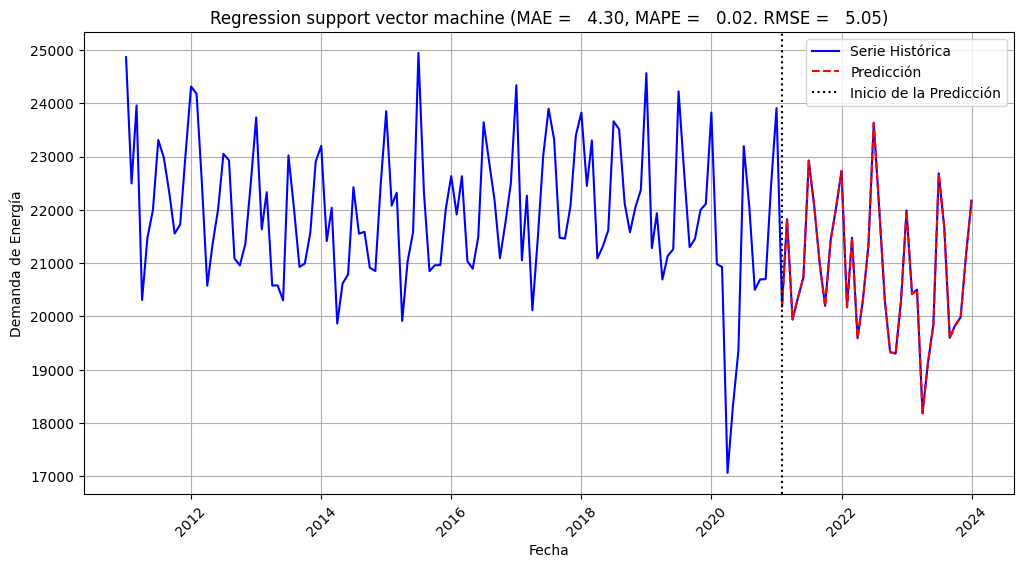

In [174]:
# Gráfico de las predicciones

train = df_final_limpio.loc['2011-01-01':'2021-01-31']
test = df_final_limpio.loc['2021-02-01':]

unir_datos = pd.concat([train['EspaniaEnergia'], test['EspaniaEnergia']])
fechas = unir_datos.index

fechas_pred = test.index

plt.figure(figsize=(12, 6))
plt.plot(fechas, unir_datos, c='b', label='Serie Histórica')
plt.plot(fechas_pred, y_pred, c='r', linestyle='--', label='Predicción')
plt.axvline(x=fechas[len(train)], color='k', linestyle=':', label='Inicio de la Predicción')
plt.xticks(rotation=45)
plt.axis('tight')
plt.legend()
plt.title("Regression support vector machine (MAE = %6.2f, MAPE = %6.2f. RMSE = %6.2f)" % (mae, mape, rmse))
plt.xlabel("Fecha")
plt.ylabel("Demanda de Energía")
plt.grid(True)
plt.show()


In [175]:
# Determinar características más relevantes
coef = svr.coef_.flatten()
caracteristicas = X_train.columns

coef_df = pd.DataFrame({'Feature': caracteristicas, 'Coefficient': coef})

coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

coef_df.head(20)

Feature  Coefficient
0              AndaluciaEnergia     0.211822
6              CataluniaEnergia     0.181625
13                MadridEnergia     0.172648
18              ValenciaEnergia     0.141541
17             PaisVascoEnergia     0.098750
10         IslasBalearesEnergia     0.092996
9                GaliciaEnergia     0.091098
11         IslasCanariasEnergia     0.084627
4     CastillaDeLaManchaEnergia     0.059198
5          CastillaYLeonEnergia     0.057263
15                MurciaEnergia     0.054619
2               AsturiasEnergia     0.054535
8            ExtremaduraEnergia     0.033010
1                 AragonEnergia     0.030904
16               NavarraEnergia     0.016483
3              CantabriaEnergia     0.016401
12               LaRiojaEnergia     0.007522
45  IslasBalearesTemperaturaMin     0.004753
38      CantabriaTemperaturaMin    -0.004212
49        MelillaTemperaturaMin     0.003914

## XGboost

In [176]:
X_train = train.drop(['EspaniaEnergia'], axis=1)
y_train = train['EspaniaEnergia']
X_test = test.drop(['EspaniaEnergia'], axis=1)
y_test = test['EspaniaEnergia']

# Modelo
xgb_sn = xgb.XGBRegressor(random_state=0)

In [177]:
# Definición de los hiperparámetros para RandomizedSearch
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 9, 11],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'min_child_weight': [1, 3, 5]
}

In [178]:
# RandomizedSearch
xgb_rns = RandomizedSearchCV(
    estimator=xgb_sn,
    param_distributions=param_dist,
    n_iter=100,
    cv=TimeSeriesSplit(),
    verbose=2,
    random_state=0,
    n_jobs=-1
)

xgb_rns.fit(X_train, y_train)

print("Mejores parámetros encontrados con RandomizedSearchCV:")
print(xgb_rns.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Mejores parámetros encontrados con RandomizedSearchCV:
{'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0.5, 'colsample_bytree': 1.0}


In [179]:
# Definición de los hiperparámetros para GridSearch
param_dist = {
    'n_estimators': [200, 250],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.2, 0.3],
    'subsample': [0.4, 0.6],
    'colsample_bytree': [1.0],
    'gamma': [0.5, 0.6],
    'min_child_weight': [1, 2]
}

In [180]:
# GridSearch
xgb_gs = GridSearchCV(
    estimator=xgb_sn,
    param_grid=param_dist,
    cv=TimeSeriesSplit(),
    verbose=2,
    n_jobs=-1
)

xgb_gs.fit(X_train, y_train)

print("Mejores parámetros encontrados con GridSearchCV:")
print(xgb_gs.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Mejores parámetros encontrados con GridSearchCV:
{'colsample_bytree': 1.0, 'gamma': 0.6, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.6}


In [181]:
xgb_rnsgs = xgb_gs.best_estimator_

y_pred = xgb_rnsgs.predict(X_test)

mae = mean_absolute_error(test['EspaniaEnergia'], y_pred)
print ('MAE', mae)
mape = mean_absolute_percentage_error(test['EspaniaEnergia'], y_pred) * 100
print(f"MAPE: {mape:.2f}%")
rmse = np.sqrt(mean_squared_error(test['EspaniaEnergia'], y_pred))
print(f"RMSE: {rmse:.2f}")

MAE 405.5367458993057
MAPE: 1.99%
RMSE: 532.62


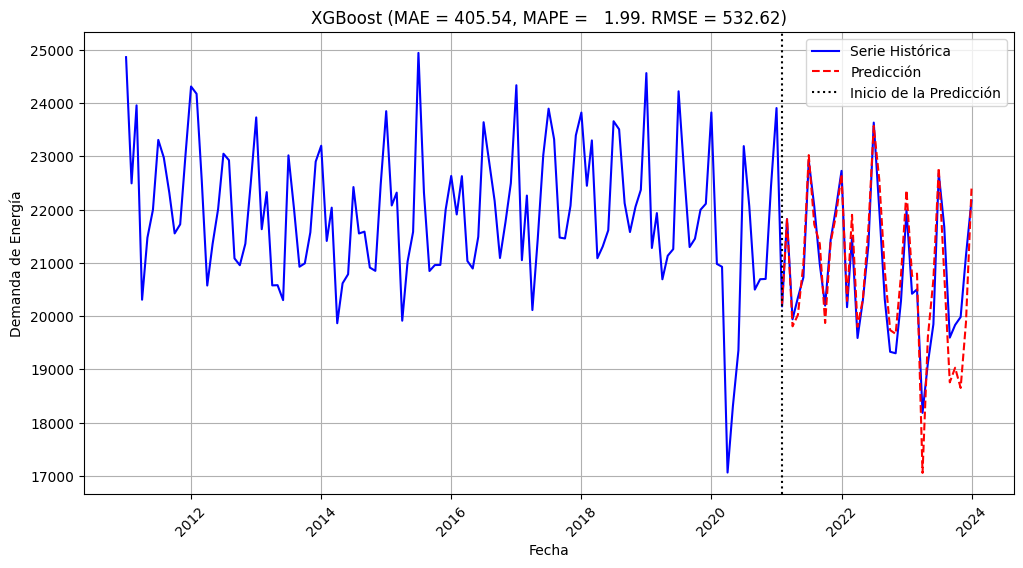

In [182]:
# Gráfico de las predicciones
train = df_final_limpio.loc['2011-01-01':'2021-01-31']
test = df_final_limpio.loc['2021-02-01':]

unir_datos = pd.concat([train['EspaniaEnergia'], test['EspaniaEnergia']])
fechas = unir_datos.index

# Crear los índices de predicción
fechas_pred = test.index
plt.figure(figsize=(12, 6))
plt.plot(fechas, unir_datos, c='b', label='Serie Histórica')
plt.plot(fechas_pred, y_pred, c='r', linestyle='--', label='Predicción')
plt.axvline(x=fechas[len(train)], color='k', linestyle=':', label='Inicio de la Predicción')
plt.xticks(rotation=45)
plt.axis('tight')
plt.legend()
plt.title("XGBoost (MAE = %6.2f, MAPE = %6.2f. RMSE = %6.2f)" % (mae, mape, rmse))
plt.xlabel("Fecha")
plt.ylabel("Demanda de Energía")
plt.grid(True)
plt.show()


In [183]:
# Características importantes
caracteristicas_importantes = xgb_rnsgs.feature_importances_

caracteristicas_importantes_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': caracteristicas_importantes
})

caracteristicas_importantes_df = caracteristicas_importantes_df.sort_values(by='Importance', ascending=False)

caracteristicas_importantes_df.head(20)

Feature  Importance
6              CataluniaEnergia    0.660924
1                 AragonEnergia    0.054347
18              ValenciaEnergia    0.051359
4     CastillaDeLaManchaEnergia    0.048058
13                MadridEnergia    0.039690
5          CastillaYLeonEnergia    0.038433
0              AndaluciaEnergia    0.034354
22      CantabriaTemperaturaMax    0.007961
12               LaRiojaEnergia    0.007916
38      CantabriaTemperaturaMin    0.007899
8            ExtremaduraEnergia    0.006854
16               NavarraEnergia    0.006172
33        NavarraTemperaturaMax    0.006064
24      CataluniaTemperaturaMax    0.003500
9                GaliciaEnergia    0.003381
61               Demanda_Media6    0.002556
2               AsturiasEnergia    0.002021
58           Estacion_Primavera    0.001531
40  CastillaYLeonTemperaturaMin    0.001500
43    ExtremaduraTemperaturaMin    0.001214


## Redes Neuronales Recurrentes


In [184]:
tf.random.set_seed(42)
np.random.seed(42)

T = 1
horizonte = 1

# Ventana deslizante
X_train_series = []
y_train_series = []

for i in range(len(X_train_scaled) - T - horizonte + 1):
    X_train_series.append(X_train_scaled[i:i + T])
    y_train_series.append(y_train_scaled[i + T + horizonte - 1])

# Convertir las listas en arrays de NumPy
X_train_series = np.array(X_train_series)
y_train_series = np.array(y_train_series)

# Modelo GRU
rnn_gru = Sequential()
rnn_gru.add(Input(shape=(T, X_train_series.shape[2])))
rnn_gru.add(GRU(100, return_sequences=True))
rnn_gru.add(GRU(50))
rnn_gru.add(Dense(horizonte, activation='linear'))

optimizer = RMSprop(learning_rate=0.006)
rnn_gru.compile(optimizer=optimizer, loss='mse')
rnn_gru.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 1, 100)              │          49,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 50)                  │          22,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,651 (283.79 KB)

 Trainable params: 72,651 (283.79 KB)

 Non-trainable params: 0 (0.00 B)

In [185]:
# EarlyStopping para el entrenamiento
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

history = rnn_gru.fit(
    X_train_series,
    y_train_series,
    batch_size=32,
    epochs=100,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

X_test_series = []
for i in range(len(X_test_scaled) - T - horizonte + 1):
    X_test_series.append(X_test_scaled[i:i + T])

X_test_series = np.array(X_test_series)

# Predicciones con datos escalados
y_pred_scaled = rnn_gru.predict(X_test_series)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - loss: 1.5147 - val_loss: 3.5196
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6372 - val_loss: 3.0788
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4020 - val_loss: 2.9715
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3806 - val_loss: 3.4913
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3387 - val_loss: 2.6733
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2359 - val_loss: 2.5227
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2401 - val_loss: 3.0384
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2854 - val_loss: 2.8367
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1694 - val_loss: 2.1837
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1914 - val_loss: 1.9604
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2561 - val_loss: 1.7597
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1501 - val_l

In [186]:
# Desescalar las predicciones
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Obtener los valores reales
y_test_real = y_test.iloc[T + horizonte - 1:].values.reshape(-1, 1)


mae = mean_absolute_error(y_test_real, y_pred)
print('MAE:', mae)
mape = mean_absolute_percentage_error(y_test_real, y_pred) * 100
print(f"MAPE: {mape:.2f}%")
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))
print(f"RMSE: {rmse:.2f}")

MAE: 898.5957386464288
MAPE: 4.46%
RMSE: 1137.34


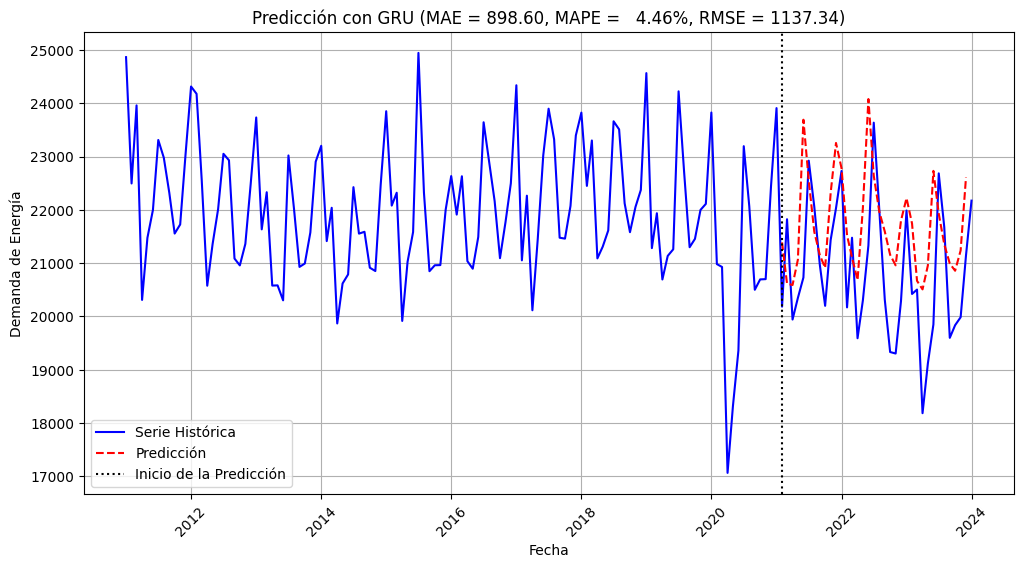

In [188]:
# Gráfico de las predicciones
train = df_final_limpio.loc['2011-01-01':'2021-01-31']
test = df_final_limpio.loc['2021-02-01':]

unir_datos = pd.concat([train['EspaniaEnergia'], test['EspaniaEnergia']])
fechas = unir_datos.index
fechas_pred = test.index

y_pred = y_pred.flatten() if len(y_pred.shape) > 1 else y_pred

if len(fechas_pred) != len(y_pred):
    print(f"Warning: Length mismatch - fechas_pred: {len(fechas_pred)}, y_pred: {len(y_pred)}")
    fechas_pred = fechas_pred[:len(y_pred)]

plt.figure(figsize=(12, 6))
plt.plot(fechas, unir_datos, c='b', label='Serie Histórica')
plt.plot(fechas_pred, y_pred, c='r', linestyle='--', label='Predicción')
plt.axvline(x=fechas[len(train)], color='k', linestyle=':', label='Inicio de la Predicción')
plt.xticks(rotation=45)
plt.axis('tight')
plt.legend()
plt.title("Predicción con GRU (MAE = %6.2f, MAPE = %6.2f%%, RMSE = %6.2f)" % (mae, mape, rmse))

plt.xlabel("Fecha")
plt.ylabel("Demanda de Energía")
plt.grid(True)
plt.show()


# Referencias

Lazzeri, F. (2020). Machine learning for time series forecasting with Python. John Wiley & Sons, Incorporated. ProQuest Ebook Central. http://ebookcentral.proquest.com/lib/universidadviu/detail.action?docID=6420045

OpenAI. (2024). Asistencia en el desarrollo de código a través de ChatGPT. https://openai.com/chatgpt

Universidad Internacional de Valencia. (2023). 07MBID_10_A_2023-24_Machine Learning [Material de clase]. En 03. Materiales del profesor. https://oncampus.universidadviu.com/?check_logged_in=1